In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [2]:
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib
import matplotlib.pyplot as plt
from abc import abstractmethod
from typing import List, Callable, Union, Any, TypeVar, Tuple
from itertools import cycle
Tensor = TypeVar('torch.tensor')

import os
import math

import numpy as np
import scipy.io as scio
from torch import optim, nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset
from tqdm import tqdm

from torchvision import transforms
import torchvision.utils as vutils


# import pytorch_lightning as pl
# from pytorch_lightning import Trainer
# from pytorch_lightning.loggers import TensorBoardLogger
# from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint

#import plotly.express as px
from sklearn.preprocessing import RobustScaler, StandardScaler, Normalizer
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, adjusted_rand_score, normalized_mutual_info_score, homogeneity_score,  completeness_score, v_measure_score
from scipy.optimize import linear_sum_assignment

import onlineVDP_suff_stat

c:\Users\MLF\anaconda3\envs\DP_VAE\lib\site-packages\scipy\__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.21.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
print("PyTorch Version: ",torch.__version__)

PyTorch Version:  2.2.2


In [4]:
class BaseVAE(nn.Module):

    def __init__(self) -> None:
        super(BaseVAE, self).__init__()

    def encode(self, input: Tensor) -> List[Tensor]:
        raise NotImplementedError

    def decode(self, input: Tensor) -> Any:
        raise NotImplementedError

    def sample(self, batch_size:int, current_device: int, **kwargs) -> Tensor:
        raise RuntimeWarning()

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        raise NotImplementedError

    @abstractmethod
    def forward(self, *inputs: Tensor) -> Tensor:
        pass

    @abstractmethod
    def loss_function(self, *inputs: Any, **kwargs) -> Tensor:
        pass

In [5]:
class DP_VAE(BaseVAE):

    def __init__(self,
                 input_dim: int,
                 latent_dim: int,
                 dpmm_param: dict,
                 hidden_layers: list,
                 output_type: str='linear',
                 **kwargs) -> None:
        
        super(DP_VAE, self).__init__()

        self.latent_dim = latent_dim
        self.input_dim = input_dim
        self.dpmm_param = dpmm_param
        self.output_type = output_type
        # the parameters of the DPGMM model
        self.current_result = {}
        self.current_suff_stat = {}
        self.opts = onlineVDP_suff_stat.mkopts_vdp(**dpmm_param)
        self.prior = {}

        self.encoder = nn.Sequential(
            nn.Linear(self.input_dim, hidden_layers[0]),
            nn.ReLU(),
            nn.Linear(hidden_layers[0], hidden_layers[1]),
            nn.ReLU(),
            nn.Linear(hidden_layers[1], hidden_layers[2]),
            nn.ReLU()
        )
        
        self.fc_mu = nn.Linear(hidden_layers[2], latent_dim)
        self.fc_log_var = nn.Linear(hidden_layers[2], latent_dim)

        # Build Decoder

        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, hidden_layers[2]),
            nn.ReLU(),
            nn.Linear(hidden_layers[2], hidden_layers[1]),
            nn.ReLU(),
            nn.Linear(hidden_layers[1], hidden_layers[0]),
            nn.ReLU(),
            nn.Linear(hidden_layers[0], self.input_dim)
        )

    def encode(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network and returns the latent codes.
        param input: (Tensor) Input tensor to encoder [N x C x H x W]
        return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        mu = self.fc_mu(result)
        log_var = self.fc_log_var(result)
        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes onto the image space.
        param z: (Tensor) [B x D]
        return: (Tensor) [B x C x H x W]
        """

        result = self.decoder(z)

        if self.output_type == 'linear':
            pass
        elif self.output_type == 'sigmoid':
            result = torch.sigmoid(result)
        else: # tahn
            result = torch.tanh(result)

        return result
    
    def reparameterize(self, mu: Tensor, log_var: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps * std + mu  
      
    # Forward propagation: inference network outputs mu(x) and log_var(x) given an input x, then use repameterization trick to sample a batch of z, which are feed to DPGMM model
    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), input, mu, log_var, z] # [recon, input, mu, log_var, z]

    def reconstruction(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input sample x, returns the reconstructed sample
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

    def fit_dpmm(self, z):
        # use the lanter variables z of the entire dataset to fit the DPGMM model
        # for the DPGMM, the dimension of input is D*N, while for the VAE, the dimension of input is N*D
        z = z.detach().cpu().t()
        prior = onlineVDP_suff_stat.mk_hp_prior(z, **self.dpmm_param)
        #self.prior = prior
        current_result = onlineVDP_suff_stat.online_vdpgmm_suffstat(z, prior, self.opts, move_dict_to_device(self.current_result, z.device))
        self.current_result = current_result
        self.current_suff_stat = current_result['sum_stat']
        current_K = self.current_result['K']

        self.calc_cluster_component_params()
        
    def calc_cluster_component_params(self):
        # expected value of mean vector and covariance matrix of each gaussian component in the DPGMM

        # means and covariance matrices
        self.comp_mu = [self.current_result['hp_posterior']['m'][:,k] for k in range(self.current_result['K']-1)]
        self.comp_var = [torch.inverse(self.current_result['hp_posterior']['lambda'][:,k]*self.current_result['hp_posterior']['W'][:,:,k]) for k in range(self.current_result['K']-1)]
        print("Log: current K", self.current_result['true_K']) # ignore the additional component
        
    # we use the entire set of lantent variables z to fit the DPGMM model, but when calculating the loss, we only use a batch of data
    # the cluster_assignments function outputs the responsibility and the hard assignments of the data in the batch

    # Backprop: calculate the loss function
    # loss = reconstruction loss + KL divergence   
    def loss_function(self,
                    *args,
                    batch_size,
                    batch_idx,
                    kl_weight) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2] # u(z|x)
        log_var = args[3] # sigma(z|x)
        z = args[4]  # batch_size * latent_dim

        # reconstruction loss
        recons_loss = F.mse_loss(recons, input, reduction='sum')

        # calculate kl divergence
        kld_weight = kl_weight # Account for the minibatch samples from the dataset
        # kl_weight = batch_size/size of the entire training set,

        #estimate the DPGMM
        if len(self.current_result) == 0:
            kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)
            loss = recons_loss + kld_weight * kld_loss
            # prior = onlineVDP_suff_stat.mk_hp_prior(z.detach().cpu().t(), **self.dpmm_param)
            # self.prior = prior
            # var = torch.exp(0.5 * log_var)**2
            # # batch_shape [batch_size], event_shape [latent_dim]
            # dist = torch.distributions.MultivariateNormal(loc=mu, covariance_matrix=torch.diag_embed(var))

            
            # covariance = torch.inverse(self.prior['lambda0']*self.prior['W0'])

            # dist_k = torch.distributions.MultivariateNormal(loc=self.prior['m0'].squeeze().to(mu.device), covariance_matrix=torch.diag_embed(torch.diag(covariance)).to(mu.device))
            # expanded_dist_k = dist_k.expand(dist.batch_shape)
            # kld = torch.distributions.kl_divergence(dist, dist_k) 
            # kld_loss = torch.mean(kld)  
            # #kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)
            # loss = recons_loss + kld_weight * kld_loss
            return {'loss': loss, 'reconstruction_loss':recons_loss, 'kld_loss': kld_loss, 'z': z}
        
        else:
            #prob_comps --> responsibilities, comps --> Z[n] cluster assignments 
            #soft assignment and hard assignment
            prob_comps, comps = self.cluster_assignments(z.detach().cpu()) # soft assignment N*K real_K = q_of_z.shape[1]-1
            #print(f"num_q_of_z:{self.current_posterior['q_of_z'].shape[1]}")
            #_ , comps = torch.max(prob_comps, dim=1) # comps: hard assignment, size = K

            # get a distribution of the latent variables
            var = torch.exp(0.5 * log_var)**2
            # batch_shape [batch_size], event_shape [latent_dim]
            dist = torch.distributions.MultivariateNormal(loc=mu, covariance_matrix=torch.diag_embed(var))  # distribution of z obtained from the encoder

            # get a distribution for each cluster
            B, K = prob_comps.shape # batch_shape (number of samples in the current minibatch), number of active clusters
            #print("Log: B, K", B, K)
            #print("Log: prob_comps", prob_comps.shape)
            kld = torch.zeros(B).to(mu.device)

            for k in range(K):
            # batch_shape [], event_shape [latent_dim]

            # responsibility to the kth component
                prob_k = prob_comps[:, k] # size = B, responsibility of the kth component
                dist_k = torch.distributions.MultivariateNormal(loc=self.comp_mu[k].to(mu.device), covariance_matrix=torch.diag_embed(torch.diag(self.comp_var[k]).to(mu.device))) # use diagonal covariance matrix here

            # batch_shape [batch_size], event_shape [latent_dim]

            # mini_batch 中每个zi都服从一个对应的multivariate normal分布zi - N(u(zi|xi),sigma(zi|xi))), 所以一共batch_size个multivariate normal分布
            # 它们分别与第k个component，即N(uk,sigmak)求KL-divergence，再取平均，得到batch的 KL loss

                expanded_dist_k = dist_k.expand(dist.batch_shape) # 把第k个component复制batch_shape次，再以tensor的形式一起计算KL divergence

                kld_k = torch.distributions.kl_divergence(dist, expanded_dist_k)   #  shape [batch_shape, ]

                #print(f"prob_k_shape:{prob_k.shape}, kld_k_shape:{kld_k.shape}")

                kld += prob_k.to(mu.device) * kld_k

        # 最终的 KL loss是minibatch中每个sample的KL loss的平均
        kld_loss = torch.mean(kld)

        loss = recons_loss + kld_weight * kld_loss
        loss = loss.to(input.device)
        return {'loss': loss, 'reconstruction_loss':recons_loss, 'kld_loss': kld_loss, 'z': z, 'comps': comps}

    def cluster_assignments(self, z):
        # z: batch_size * latent_dim --> z.t(): latent_dim * batch_size
        q_of_z, _, _ = onlineVDP_suff_stat.mk_q_of_z(z.t(), self.current_result['hp_posterior'], self.current_result['hp_prior'], self.opts)
        # Here, responsibility is a 2D array of size N x K. here N is batch size, K active clusters
        # Each entry resp[n, k] gives the probability that data atom n is assigned to cluster k under the posterior.
        resp = q_of_z[:,:-1]
        # To convert to hard assignments
        Z = resp.argmax(axis=1)
        return resp, Z

torch.Size([2000, 1000])
number of total classes: 8


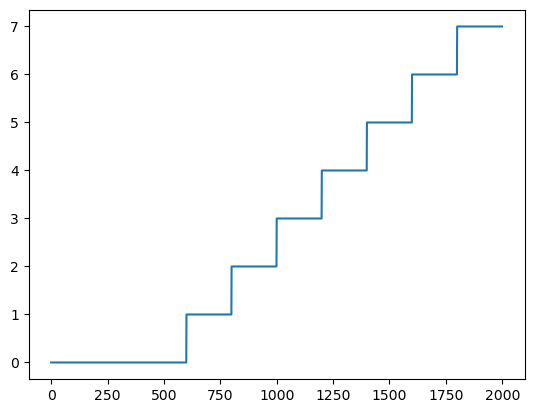

In [6]:
batch_size = 32
seed = 12345
torch.manual_seed(seed)  # ensure reproducible results

'''use a numerical dataset to test the model
label  damaged_floor     damage_extent         number_of_samples
0           0            0%                     600
1           1            5%                     200
2           1            10%                    200
3           2,4          10%, 10%               200
4           1,3,5        10%,15%,20%            200
5           2,4,6        15%,20%,25%            200
6           1,3,5,7      10%,15%,20%,25%        200
7           1,2,4,6,8    10%,15%,20%,25%,30%    200

'''
# Read data from CSV
features = pd.read_csv("TF_mag_numerical_8classes.csv")
features = features.astype("float32")
# # # Convert DataFrame to PyTorch tensors
X = torch.tensor(features.values[:7500,:])
X1 = X[1000:1500,:]
X2 = X[1800:2300,:]
X = torch.cat([X1, X2], dim=0)
X = X.t()
# scaler = StandardScaler()
# X =  torch.tensor(scaler.fit_transform(X)).detach().float()

input_dim = X.shape[1]
print(X.shape)

y0 = torch.tensor(features.values[7500,:])
y0 = y0.unsqueeze(1)
y = [int(_) for _ in y0] #+ 0.01*y0.mean()*torch.randn(y0.shape[0], 1)
y = torch.tensor(y)
num_classes = y.max().item() + 1
print(f"number of total classes: {num_classes}")

# create datasets for each class (for incremental learning)
datasets = [TensorDataset(X[y==i], y[y==i]) for i in range(num_classes)]

# use the dataset with 5 classes initially
init_dataset = ConcatDataset(datasets[:1])
current_dataset = init_dataset

train_size = int(0.8 * len(current_dataset))
test_size = int(0.1 * len(current_dataset))
valid_size = len(current_dataset) - train_size - test_size
train_dataset, test_dataset, valid_dataset = random_split(current_dataset, [train_size, test_size, valid_size])

# Accessing the tensors from train_dataset and test_dataset
# x_train, y_train = train_dataset[:]
# x_valid, y_valid = valid_dataset[:]
# # Optionally, you can also access the test set
# x_test, y_test = test_dataset[:]

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

plt.plot(y)
plt.show()

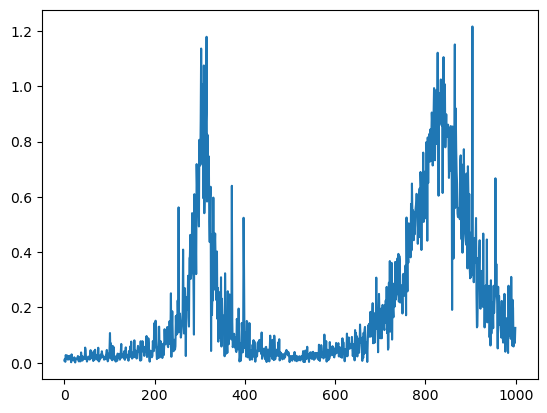

In [7]:
plt.plot(X[0,:])

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
latent_dim = 10
model_params = dict(
    input_dim = input_dim,
    latent_dim = latent_dim,
    hidden_layers = [500, 500, 2000],
    dpmm_param = dict(
        alpha=torch.tensor(10.0),
        beta0=torch.tensor(0.01),
        max_iter_merge = 10,
        max_iter_split = 3,
        max_merge = 10,
        max_split = 5,
        ite = 100,
    )
)

# MLP format
model = DP_VAE(**model_params).to(device)
print(model.state_dict)

cpu
<bound method Module.state_dict of DP_VAE(
  (encoder): Sequential(
    (0): Linear(in_features=1000, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=2000, bias=True)
    (5): ReLU()
  )
  (fc_mu): Linear(in_features=2000, out_features=10, bias=True)
  (fc_log_var): Linear(in_features=2000, out_features=10, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=2000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2000, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=500, bias=True)
    (5): ReLU()
    (6): Linear(in_features=500, out_features=1000, bias=True)
  )
)>


In [8]:
def move_dict_to_device(state_dict, device):
    '''move all tensors in state_dict to the device'''
    new_state_dict = {}
    for k, v in state_dict.items():
        if isinstance(v, torch.Tensor):
            new_state_dict[k] = v.to(device)
        else:
            new_state_dict[k] = v
    return new_state_dict

def forward(model, input: Tensor, **kwargs) -> Tensor:
    return model(input, **kwargs)
    
    
def training_step(model, batch_samples, batch_labels, batch_idx, kl_weight):
    curr_device = batch_samples.device

    batch_size = batch_samples.size(0)
    results = forward(model, batch_samples, labels = batch_labels)
    train_loss = model.loss_function(*results, batch_size = batch_size, batch_idx = batch_idx,
                                              kl_weight = kl_weight,
                                              )
    #for name, metric in train_loss.items():
        #if "loss" in name:
            #log("train_" + name, metric.mean().item(), on_step=False, on_epoch=True, prog_bar=True)

    train_loss.update({'labels': batch_labels})
    #print(f"train_loss:{train_loss}")
    return train_loss    # latent encoding

def training_epoch_end(model, current_epoch, total_epochs, dpmm_init_epoch, outputs):
    if current_epoch >= dpmm_init_epoch:
        z = torch.cat([outputs[i]['z'] for i in range(0, len(outputs))])
        model.fit_dpmm(z)
    
    if "comps" in outputs[0]:
        comps = []
        for i in range(0, len(outputs)):
            comps.extend(outputs[i]['comps'])
        comps = np.array(comps)
        #comps = np.array([outputs[i]['comps'] for i in range(0, len(outputs))]).flatten()
        labels = torch.cat([outputs[i]['labels'] for i in range(0, len(outputs))]).cpu()
        #print(f"labels:{labels}")
        #print(f"comps:{comps}")
        acc, assignment_training = unsupervised_clustering_accuracy(labels.numpy(), comps)
        ars = adjusted_rand_score(labels.numpy(), comps)
        nmi = normalized_mutual_info_score(labels.numpy(), comps)

        mapping = {}
        try:
            for i,j in assignment_training:
                mapping[i] = j
            training_mapped_labels = [mapping[i] for i in comps.numpy()]
        except:
            training_mapped_labels = labels.numpy().astype(int)

        dda_training = damage_detection_acc(labels.numpy().astype(int), np.array(training_mapped_labels))
        #self.log("train_clustering_acc", acc, on_step=False, on_epoch=True, prog_bar=True)
        #self.log("Number_of_DP_Comps", int(self.model.bnp_model.obsModel.K), on_step=False, on_epoch=True, prog_bar=True)
        print(f"train_clustering_acc:{acc}", f"train_ars:{ars}", f"train_nmi:{nmi}", f"train_dda: {dda_training}")
        print(f"Number_of_DP_Comps:{model.current_result['true_K']}")
        print(f"Nk:{model.current_result['sum_stat']['Nk']}")

        return comps, labels, acc, dda_training[0]
    
def validation_step(model, batch_samples, batch_labels, batch_idx, kl_weight):
    batch_size = batch_samples.size(0)
    results = forward(model, batch_samples, labels = batch_labels)
    val_loss = model.loss_function(*results, batch_size = batch_size, batch_idx = batch_idx, kl_weight = kl_weight)
                                        
    val_loss.update({'labels': batch_labels})
    
    return val_loss

def validation_epoch_end(current_epoch, total_epochs, outputs):
    
    print(f"====================== Validation Epoch: {current_epoch+1} ========================")

    if "comps" in outputs[0]:
        comps = []
        for i in range(0, len(outputs)):
            comps.extend(outputs[i]['comps'])
        comps = np.array(comps)
        labels = torch.cat([outputs[i]['labels'] for i in range(0, len(outputs))]).cpu()
        acc, assignment_valid = unsupervised_clustering_accuracy(labels.numpy(), comps)
        ars = adjusted_rand_score(labels.numpy(), comps)
        nmi = normalized_mutual_info_score(labels.numpy(), comps)

        mapping = {}
        try:
            for i,j in assignment_valid:
                mapping[i] = j
            valid_mapped_labels = [mapping[i] for i in comps.numpy()]
        except:
            valid_mapped_labels = labels.numpy().astype(int)

        dda_val = damage_detection_acc(labels.numpy().astype(int), np.array(valid_mapped_labels))

        print(f"valid_clustering_acc:{acc}", f"valid_ars:{ars}", f"valid_nmi:{nmi}", f"valid_dda: {dda_val}")
        return acc, dda_val[0]
    
def test_epoch(current_epoch, total_epochs, outputs):
    
    if "comps" in outputs[0]:
        comps = []
        for i in range(0, len(outputs)):
            comps.extend(outputs[i]['comps'])
        comps = np.array(comps)
        labels = torch.cat([outputs[i]['labels'] for i in range(0, len(outputs))]).cpu()
        acc, assignment_test = unsupervised_clustering_accuracy(labels.numpy(), comps)
        ars = adjusted_rand_score(labels.numpy(), comps)
        nmi = normalized_mutual_info_score(labels.numpy(), comps)

        mapping = {}
        try:
            for i,j in assignment_test:
                mapping[i] = j
            test_mapped_labels = [mapping[i] for i in comps.numpy()]
        except:
            test_mapped_labels = labels.numpy().astype(int)

        dda_test = damage_detection_acc(labels.numpy().astype(int), np.array(test_mapped_labels))

        print(f"test_clustering_acc:{acc}", f"test_ars:{ars}", f"test_nmi:{nmi}", f"test_dda: {dda_test}")
        return acc, dda_test[0]
        
def unsupervised_clustering_accuracy(y: Union[np.ndarray, torch.Tensor], y_pred: Union[np.ndarray, torch.Tensor]) -> tuple:
        """Unsupervised Clustering Accuracy
        """
        assert len(y_pred) == len(y)
        u = np.unique(y)
        n_true_clusters = len(u)
        v = np.unique(y_pred)
        n_pred_clusters = len(v)
        map_u = dict(zip(u, range(n_true_clusters)))
        map_v = dict(zip(v, range(n_pred_clusters)))
        inv_map_u = {v: k for k, v in map_u.items()}
        inv_map_v = {v: k for k, v in map_v.items()}
        r = np.zeros((n_pred_clusters, n_true_clusters), dtype=np.int64)
        for y_pred_, y_ in zip(y_pred, y):
            if y_ in map_u:
                r[map_v[y_pred_], map_u[y_]] += 1
        reward_matrix  = np.concatenate((r, r, r), axis=1)
        cost_matrix = reward_matrix.max() - reward_matrix
        row_assign, col_assign = linear_sum_assignment(cost_matrix)

        # Construct optimal assignments matrix
        row_assign = row_assign.reshape((-1, 1))  # (n,) to (n, 1) reshape
        col_assign = col_assign.reshape((-1, 1))  # (n,) to (n, 1) reshape
        assignments = np.concatenate((row_assign, col_assign), axis=1)
        assignments = [[inv_map_v[x], inv_map_u[y%n_true_clusters]] for x, y in assignments]

        optimal_reward = reward_matrix[row_assign, col_assign].sum() * 1.0
        return optimal_reward / y_pred.size, assignments       

In [9]:
def damage_detection_acc(y, y_pred):
    y = y.astype(int)
    y_pred = y_pred.astype(int)
    
    fn = 0
    fp = 0
    most_tru = np.bincount(y).argmax()
    #most_pre = 3
    most_pre = np.bincount(y_pred).argmax()


    for i in range(len(y)):
        if y[i] == most_tru and y_pred[i] != most_pre:
            fp += 1
        if y[i] != most_tru and y_pred[i] == most_pre:
            fn += 1
        dda = 1 - (fn + fp) / len(y)        
    return dda, fn, fp

current_epoch 0/301: 100%|██████████| 15/15 [00:01<00:00, 10.75it/s]


training_loss:3550.3559 reconstruction_loss:3550.3399 kl_loss:0.0161
### greedy splitting ###
free_energy not decreased after splitting
F=5437.7;    Nk=[480.00, 0.00];
merge step is not implemented
Log: current K 1
torch.Size([480, 10])


current_epoch 1/301: 100%|██████████| 15/15 [00:00<00:00, 24.96it/s]


training_loss:2514.6241 reconstruction_loss:2514.4060 kl_loss:0.2182
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=5915.4;    Nk=[466.08, 13.92, 0.00];
### merge step ###
less than 2 components
Log: current K 1
train_clustering_acc:1.0 train_ars:1.0 train_nmi:1.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[480.,   0.]])
====================== Validation Epoch: 2 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:1741.7304 val_reconstruction_loss:1741.5359 val_kl_loss:0.1945


current_epoch 2/301: 100%|██████████| 15/15 [00:00<00:00, 28.96it/s]


training_loss:1362.2231 reconstruction_loss:1361.9526 kl_loss:0.2705
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=6379.8;    Nk=[464.22, 15.78, 0.00];
### merge step ###
less than 2 components
Log: current K 1
train_clustering_acc:1.0 train_ars:1.0 train_nmi:1.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[480.,   0.]])
====================== Validation Epoch: 3 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:887.1780 val_reconstruction_loss:887.1457 val_kl_loss:0.0323


current_epoch 3/301: 100%|██████████| 15/15 [00:00<00:00, 30.63it/s]


training_loss:709.7362 reconstruction_loss:709.6891 kl_loss:0.0472
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=6284.5;    Nk=[480.00, 0.00];
merge step is not implemented
Log: current K 1
train_clustering_acc:1.0 train_ars:1.0 train_nmi:1.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[480.,   0.]])
====================== Validation Epoch: 4 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:612.3182 val_reconstruction_loss:612.2542 val_kl_loss:0.0641


current_epoch 4/301: 100%|██████████| 15/15 [00:00<00:00, 27.89it/s]


training_loss:528.3915 reconstruction_loss:528.3065 kl_loss:0.0850
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=6019.6;    Nk=[468.04, 11.96, 0.00];
### merge step ###
less than 2 components
Log: current K 1
train_clustering_acc:1.0 train_ars:1.0 train_nmi:1.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[480.,   0.]])
====================== Validation Epoch: 5 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:493.2984 val_reconstruction_loss:493.2737 val_kl_loss:0.0246


current_epoch 5/301: 100%|██████████| 15/15 [00:00<00:00, 27.68it/s]


training_loss:472.5841 reconstruction_loss:472.5558 kl_loss:0.0282
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=5935.4;    Nk=[480.00, 0.00];
merge step is not implemented
Log: current K 1
train_clustering_acc:1.0 train_ars:1.0 train_nmi:1.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[480.,   0.]])
====================== Validation Epoch: 6 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:487.2291 val_reconstruction_loss:487.1918 val_kl_loss:0.0373


current_epoch 6/301: 100%|██████████| 15/15 [00:00<00:00, 28.41it/s]


training_loss:447.1349 reconstruction_loss:447.0770 kl_loss:0.0579
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=5810.7;    Nk=[480.00, 0.00];
merge step is not implemented
Log: current K 1
train_clustering_acc:1.0 train_ars:1.0 train_nmi:1.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[480.,   0.]])
====================== Validation Epoch: 7 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:483.9943 val_reconstruction_loss:483.9005 val_kl_loss:0.0938


current_epoch 7/301: 100%|██████████| 15/15 [00:00<00:00, 28.16it/s]


training_loss:451.6622 reconstruction_loss:451.4695 kl_loss:0.1927
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=5649;    Nk=[460.08, 11.93, 8.00, 0.00];
### merge step ###
less than 2 components
Log: current K 1
train_clustering_acc:1.0 train_ars:1.0 train_nmi:1.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[480.,   0.]])
====================== Validation Epoch: 8 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:450.1722 val_reconstruction_loss:450.0922 val_kl_loss:0.0800


current_epoch 8/301: 100%|██████████| 15/15 [00:00<00:00, 29.92it/s]


training_loss:429.3989 reconstruction_loss:429.1280 kl_loss:0.2708
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=5569.5;    Nk=[460.78, 19.22, 0.00];
### merge step ###
less than 2 components
Log: current K 1
train_clustering_acc:1.0 train_ars:1.0 train_nmi:1.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[480.,   0.]])
====================== Validation Epoch: 9 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:431.5661 val_reconstruction_loss:431.3671 val_kl_loss:0.1990


current_epoch 9/301: 100%|██████████| 15/15 [00:00<00:00, 29.59it/s]


training_loss:412.0729 reconstruction_loss:411.1558 kl_loss:0.9172
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=5283.4;    Nk=[443.57, 36.43, 0.00];
### merge step ###
less than 2 components
Log: current K 1
train_clustering_acc:1.0 train_ars:1.0 train_nmi:1.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[480.,   0.]])
====================== Validation Epoch: 10 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:392.2425 val_reconstruction_loss:391.8299 val_kl_loss:0.4126


current_epoch 10/301: 100%|██████████| 15/15 [00:00<00:00, 30.69it/s]


training_loss:378.6670 reconstruction_loss:376.9008 kl_loss:1.7663
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=4314.2;    Nk=[463.28, 16.72, 0.00];
### merge step ###
less than 2 components
Log: current K 1
train_clustering_acc:1.0 train_ars:1.0 train_nmi:1.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[480.,   0.]])
====================== Validation Epoch: 11 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:371.2724 val_reconstruction_loss:370.6146 val_kl_loss:0.6578
torch.Size([480, 10])


current_epoch 11/301: 100%|██████████| 15/15 [00:00<00:00, 28.46it/s]


training_loss:360.0520 reconstruction_loss:358.4921 kl_loss:1.5599
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=3736.2;    Nk=[450.19, 16.81, 7.99, 5.00, 0.00];
### merge step ###
less than 2 components
Log: current K 1
train_clustering_acc:1.0 train_ars:1.0 train_nmi:1.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[480.,   0.]])
====================== Validation Epoch: 12 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:366.4405 val_reconstruction_loss:365.9449 val_kl_loss:0.4956


current_epoch 12/301: 100%|██████████| 15/15 [00:00<00:00, 28.57it/s]


training_loss:353.2920 reconstruction_loss:352.4216 kl_loss:0.8705
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=3063.5;    Nk=[455.75, 24.25, 0.00];
### merge step ###
less than 2 components
Log: current K 1
train_clustering_acc:1.0 train_ars:1.0 train_nmi:1.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[480.,   0.]])
====================== Validation Epoch: 13 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:363.6985 val_reconstruction_loss:363.3834 val_kl_loss:0.3151


current_epoch 13/301: 100%|██████████| 15/15 [00:00<00:00, 27.18it/s]


training_loss:349.3377 reconstruction_loss:348.8319 kl_loss:0.5058
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=2629.6;    Nk=[458.87, 21.13, 0.00];
### merge step ###
less than 2 components
Log: current K 1
train_clustering_acc:1.0 train_ars:1.0 train_nmi:1.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[480.,   0.]])
====================== Validation Epoch: 14 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:362.5789 val_reconstruction_loss:362.4019 val_kl_loss:0.1770


current_epoch 14/301: 100%|██████████| 15/15 [00:00<00:00, 28.12it/s]


training_loss:347.5576 reconstruction_loss:347.3000 kl_loss:0.2576
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=2239.8;    Nk=[480.00, 0.00];
merge step is not implemented
Log: current K 1
train_clustering_acc:1.0 train_ars:1.0 train_nmi:1.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[480.,   0.]])
====================== Validation Epoch: 15 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:360.8704 val_reconstruction_loss:360.4255 val_kl_loss:0.4449


current_epoch 15/301: 100%|██████████| 15/15 [00:00<00:00, 30.69it/s]


training_loss:346.9991 reconstruction_loss:346.5620 kl_loss:0.4371
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=2085.8;    Nk=[460.62, 19.38, 0.00];
### merge step ###
less than 2 components
Log: current K 1
train_clustering_acc:1.0 train_ars:1.0 train_nmi:1.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[480.,   0.]])
====================== Validation Epoch: 16 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:360.4630 val_reconstruction_loss:360.2181 val_kl_loss:0.2449


current_epoch 16/301: 100%|██████████| 15/15 [00:00<00:00, 29.65it/s]


training_loss:346.7099 reconstruction_loss:346.4163 kl_loss:0.2937
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=1733.4;    Nk=[480.00, 0.00];
merge step is not implemented
Log: current K 1
train_clustering_acc:1.0 train_ars:1.0 train_nmi:1.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[480.,   0.]])
====================== Validation Epoch: 17 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:360.4162 val_reconstruction_loss:359.8465 val_kl_loss:0.5697


current_epoch 17/301: 100%|██████████| 15/15 [00:00<00:00, 32.72it/s]


training_loss:346.0247 reconstruction_loss:345.6055 kl_loss:0.4192
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=1553.6;    Nk=[480.00, 0.00];
merge step is not implemented
Log: current K 1
train_clustering_acc:1.0 train_ars:1.0 train_nmi:1.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[480.,   0.]])
====================== Validation Epoch: 18 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:360.0121 val_reconstruction_loss:359.5407 val_kl_loss:0.4714


current_epoch 18/301: 100%|██████████| 15/15 [00:00<00:00, 31.86it/s]


training_loss:346.1577 reconstruction_loss:345.6408 kl_loss:0.5169
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=1378.2;    Nk=[455.45, 24.55, 0.00];
### merge step ###
less than 2 components
Log: current K 1
train_clustering_acc:1.0 train_ars:1.0 train_nmi:1.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[480.,   0.]])
====================== Validation Epoch: 19 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:358.6196 val_reconstruction_loss:358.2136 val_kl_loss:0.4060


current_epoch 19/301: 100%|██████████| 15/15 [00:00<00:00, 30.39it/s]


training_loss:345.2051 reconstruction_loss:344.8240 kl_loss:0.3811
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=1095.2;    Nk=[480.00, 0.00];
merge step is not implemented
Log: current K 1
train_clustering_acc:1.0 train_ars:1.0 train_nmi:1.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[480.,   0.]])
====================== Validation Epoch: 20 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:358.8290 val_reconstruction_loss:358.3809 val_kl_loss:0.4481


current_epoch 20/301: 100%|██████████| 15/15 [00:00<00:00, 30.74it/s]


training_loss:345.0175 reconstruction_loss:344.5954 kl_loss:0.4220
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=940.46;    Nk=[480.00, 0.00];
merge step is not implemented
Log: current K 1
train_clustering_acc:1.0 train_ars:1.0 train_nmi:1.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[480.,   0.]])
====================== Validation Epoch: 21 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:359.3415 val_reconstruction_loss:358.8247 val_kl_loss:0.5168
torch.Size([480, 10])


current_epoch 21/301: 100%|██████████| 15/15 [00:00<00:00, 30.55it/s]


training_loss:345.2151 reconstruction_loss:344.7284 kl_loss:0.4868
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=848.97;    Nk=[480.00, 0.00];
merge step is not implemented
Log: current K 1
train_clustering_acc:1.0 train_ars:1.0 train_nmi:1.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[480.,   0.]])
====================== Validation Epoch: 22 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:358.6051 val_reconstruction_loss:358.0310 val_kl_loss:0.5741


current_epoch 22/301: 100%|██████████| 15/15 [00:00<00:00, 30.65it/s]


training_loss:344.9812 reconstruction_loss:344.4265 kl_loss:0.5547
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=705.66;    Nk=[480.00, 0.00];
merge step is not implemented
Log: current K 1
train_clustering_acc:1.0 train_ars:1.0 train_nmi:1.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[480.,   0.]])
====================== Validation Epoch: 23 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:358.6878 val_reconstruction_loss:358.0968 val_kl_loss:0.5911


current_epoch 23/301: 100%|██████████| 15/15 [00:00<00:00, 28.33it/s]


training_loss:345.1590 reconstruction_loss:344.5589 kl_loss:0.6001
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=610.71;    Nk=[456.01, 23.99, 0.00];
### merge step ###
less than 2 components
Log: current K 1
train_clustering_acc:1.0 train_ars:1.0 train_nmi:1.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[480.,   0.]])
====================== Validation Epoch: 24 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:358.4814 val_reconstruction_loss:358.0299 val_kl_loss:0.4515


current_epoch 24/301: 100%|██████████| 15/15 [00:00<00:00, 29.86it/s]


training_loss:344.7635 reconstruction_loss:344.3267 kl_loss:0.4368
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=474.36;    Nk=[480.00, 0.00];
merge step is not implemented
Log: current K 1
train_clustering_acc:1.0 train_ars:1.0 train_nmi:1.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[480.,   0.]])
====================== Validation Epoch: 25 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:358.9325 val_reconstruction_loss:358.4867 val_kl_loss:0.4458


current_epoch 25/301: 100%|██████████| 15/15 [00:00<00:00, 30.48it/s]


training_loss:344.9398 reconstruction_loss:344.4975 kl_loss:0.4422
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=380.04;    Nk=[480.00, 0.00];
merge step is not implemented
Log: current K 1
train_clustering_acc:1.0 train_ars:1.0 train_nmi:1.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[480.,   0.]])
====================== Validation Epoch: 26 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:358.3137 val_reconstruction_loss:357.8262 val_kl_loss:0.4874


current_epoch 26/301: 100%|██████████| 15/15 [00:00<00:00, 28.96it/s]


training_loss:344.8627 reconstruction_loss:344.3832 kl_loss:0.4795
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=244.1;    Nk=[480.00, 0.00];
merge step is not implemented
Log: current K 1
train_clustering_acc:1.0 train_ars:1.0 train_nmi:1.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[480.,   0.]])
====================== Validation Epoch: 27 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:358.6089 val_reconstruction_loss:358.0982 val_kl_loss:0.5107


current_epoch 27/301: 100%|██████████| 15/15 [00:00<00:00, 30.62it/s]


training_loss:344.8261 reconstruction_loss:344.3015 kl_loss:0.5246
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=208.21;    Nk=[480.00, 0.00];
merge step is not implemented
Log: current K 1
train_clustering_acc:1.0 train_ars:1.0 train_nmi:1.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[480.,   0.]])
====================== Validation Epoch: 28 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:359.3049 val_reconstruction_loss:358.6674 val_kl_loss:0.6375


current_epoch 28/301: 100%|██████████| 15/15 [00:00<00:00, 32.11it/s]


training_loss:344.6237 reconstruction_loss:344.0937 kl_loss:0.5300
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=208.15;    Nk=[480.00, 0.00];
merge step is not implemented
Log: current K 1
train_clustering_acc:1.0 train_ars:1.0 train_nmi:1.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[480.,   0.]])
====================== Validation Epoch: 29 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:357.8307 val_reconstruction_loss:357.2792 val_kl_loss:0.5515


current_epoch 29/301: 100%|██████████| 15/15 [00:00<00:00, 30.71it/s]


training_loss:344.6851 reconstruction_loss:344.1629 kl_loss:0.5222
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=174.37;    Nk=[468.26, 11.74, 0.00];
### merge step ###
less than 2 components
Log: current K 1
train_clustering_acc:1.0 train_ars:1.0 train_nmi:1.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[480.,   0.]])
====================== Validation Epoch: 30 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:358.7051 val_reconstruction_loss:358.1997 val_kl_loss:0.5054


current_epoch 30/301: 100%|██████████| 15/15 [00:00<00:00, 31.28it/s]


training_loss:344.7251 reconstruction_loss:344.2579 kl_loss:0.4671
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=108.17;    Nk=[480.00, 0.00];
merge step is not implemented
Log: current K 1
train_clustering_acc:1.0 train_ars:1.0 train_nmi:1.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[480.,   0.]])
====================== Validation Epoch: 31 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:359.0096 val_reconstruction_loss:358.4808 val_kl_loss:0.5288
torch.Size([480, 10])


current_epoch 31/301: 100%|██████████| 15/15 [00:00<00:00, 28.15it/s]


training_loss:344.4943 reconstruction_loss:344.0212 kl_loss:0.4730
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-137.02;    Nk=[480.00, 0.00];
merge step is not implemented
Log: current K 1
train_clustering_acc:1.0 train_ars:1.0 train_nmi:1.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[480.,   0.]])
====================== Validation Epoch: 32 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:358.3856 val_reconstruction_loss:357.8553 val_kl_loss:0.5303


current_epoch 32/301: 100%|██████████| 15/15 [00:00<00:00, 31.65it/s]


training_loss:344.7126 reconstruction_loss:344.1875 kl_loss:0.5251
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-55.739;    Nk=[480.00, 0.00];
merge step is not implemented
Log: current K 1
train_clustering_acc:1.0 train_ars:1.0 train_nmi:1.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[480.,   0.]])
====================== Validation Epoch: 33 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:358.8467 val_reconstruction_loss:358.1959 val_kl_loss:0.6508


current_epoch 33/301: 100%|██████████| 15/15 [00:00<00:00, 29.61it/s]


training_loss:344.6171 reconstruction_loss:344.0725 kl_loss:0.5446
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-194.04;    Nk=[480.00, 0.00];
merge step is not implemented
Log: current K 1
train_clustering_acc:1.0 train_ars:1.0 train_nmi:1.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[480.,   0.]])
====================== Validation Epoch: 34 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:357.9515 val_reconstruction_loss:357.3856 val_kl_loss:0.5659


current_epoch 34/301: 100%|██████████| 15/15 [00:00<00:00, 31.37it/s]


training_loss:344.6168 reconstruction_loss:344.1147 kl_loss:0.5021
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-190.17;    Nk=[480.00, 0.00];
merge step is not implemented
Log: current K 1
train_clustering_acc:1.0 train_ars:1.0 train_nmi:1.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[480.,   0.]])
====================== Validation Epoch: 35 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:358.4061 val_reconstruction_loss:357.8608 val_kl_loss:0.5452


current_epoch 35/301: 100%|██████████| 15/15 [00:00<00:00, 30.67it/s]


training_loss:344.4719 reconstruction_loss:343.9728 kl_loss:0.4991
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-297.87;    Nk=[480.00, 0.00];
merge step is not implemented
Log: current K 1
train_clustering_acc:1.0 train_ars:1.0 train_nmi:1.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[480.,   0.]])
====================== Validation Epoch: 36 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:358.3606 val_reconstruction_loss:357.8253 val_kl_loss:0.5353


current_epoch 36/301: 100%|██████████| 15/15 [00:00<00:00, 30.62it/s]


training_loss:344.5010 reconstruction_loss:343.9864 kl_loss:0.5145
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-154.48;    Nk=[480.00, 0.00];
merge step is not implemented
Log: current K 1
train_clustering_acc:1.0 train_ars:1.0 train_nmi:1.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[480.,   0.]])
====================== Validation Epoch: 37 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:358.1513 val_reconstruction_loss:357.5799 val_kl_loss:0.5714


current_epoch 37/301: 100%|██████████| 15/15 [00:00<00:00, 28.86it/s]


training_loss:344.4541 reconstruction_loss:343.9592 kl_loss:0.4949
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-138.41;    Nk=[480.00, 0.00];
merge step is not implemented
Log: current K 1
train_clustering_acc:1.0 train_ars:1.0 train_nmi:1.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[480.,   0.]])
====================== Validation Epoch: 38 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:358.6506 val_reconstruction_loss:358.0941 val_kl_loss:0.5564


current_epoch 38/301: 100%|██████████| 15/15 [00:00<00:00, 30.66it/s]


training_loss:344.5307 reconstruction_loss:344.0526 kl_loss:0.4782
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-200.98;    Nk=[480.00, 0.00];
merge step is not implemented
Log: current K 1
train_clustering_acc:1.0 train_ars:1.0 train_nmi:1.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[480.,   0.]])
====================== Validation Epoch: 39 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:358.1649 val_reconstruction_loss:357.6010 val_kl_loss:0.5639


current_epoch 39/301: 100%|██████████| 15/15 [00:00<00:00, 29.60it/s]


training_loss:344.5510 reconstruction_loss:344.0570 kl_loss:0.4940
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-184.03;    Nk=[480.00, 0.00];
merge step is not implemented
Log: current K 1
train_clustering_acc:1.0 train_ars:1.0 train_nmi:1.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[480.,   0.]])
====================== Validation Epoch: 40 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:358.0075 val_reconstruction_loss:357.4498 val_kl_loss:0.5577


current_epoch 40/301: 100%|██████████| 25/25 [00:00<00:00, 30.61it/s]


training_loss:447.2736 reconstruction_loss:446.4967 kl_loss:0.7769
test_clustering_acc:0.65 test_ars:0.0 test_nmi:0.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-446.35;    Nk=[779.86, 20.14, 0.00];
### merge step ###
less than 2 components
Log: current K 1
train_clustering_acc:0.59125 train_ars:0.0 train_nmi:0.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[800.,   0.]])
====================== Validation Epoch: 41 ========================
valid_clustering_acc:0.62 valid_ars:0.0 valid_nmi:0.0 valid_dda: (1.0, 0, 0)
valid_loss:362.8834 val_reconstruction_loss:362.3585 val_kl_loss:0.5249
torch.Size([800, 10])


current_epoch 41/301: 100%|██████████| 25/25 [00:00<00:00, 29.29it/s]


training_loss:437.7173 reconstruction_loss:437.1517 kl_loss:0.5655
test_clustering_acc:0.65 test_ars:0.0 test_nmi:0.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-675.55;    Nk=[800.00, 0.00];
merge step is not implemented
Log: current K 1
train_clustering_acc:0.59125 train_ars:0.0 train_nmi:0.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[800.,   0.]])
====================== Validation Epoch: 42 ========================
valid_clustering_acc:0.62 valid_ars:0.0 valid_nmi:0.0 valid_dda: (1.0, 0, 0)
valid_loss:360.7737 val_reconstruction_loss:360.3081 val_kl_loss:0.4655


current_epoch 42/301: 100%|██████████| 25/25 [00:00<00:00, 29.19it/s]


training_loss:437.0957 reconstruction_loss:436.5603 kl_loss:0.5354
test_clustering_acc:0.65 test_ars:0.0 test_nmi:0.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-731.12;    Nk=[800.00, 0.00];
merge step is not implemented
Log: current K 1
train_clustering_acc:0.59125 train_ars:0.0 train_nmi:0.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[800.,   0.]])
====================== Validation Epoch: 43 ========================
valid_clustering_acc:0.62 valid_ars:0.0 valid_nmi:0.0 valid_dda: (1.0, 0, 0)
valid_loss:361.0015 val_reconstruction_loss:360.4667 val_kl_loss:0.5348


current_epoch 43/301: 100%|██████████| 25/25 [00:00<00:00, 26.52it/s]


training_loss:437.1282 reconstruction_loss:436.5808 kl_loss:0.5473
test_clustering_acc:0.65 test_ars:0.0 test_nmi:0.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-941.49;    Nk=[800.00, 0.00];
merge step is not implemented
Log: current K 1
train_clustering_acc:0.59125 train_ars:0.0 train_nmi:0.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[800.,   0.]])
====================== Validation Epoch: 44 ========================
valid_clustering_acc:0.62 valid_ars:0.0 valid_nmi:0.0 valid_dda: (1.0, 0, 0)
valid_loss:361.1100 val_reconstruction_loss:360.6156 val_kl_loss:0.4945


current_epoch 44/301: 100%|██████████| 25/25 [00:01<00:00, 24.73it/s]


training_loss:437.2689 reconstruction_loss:436.7417 kl_loss:0.5272
test_clustering_acc:0.65 test_ars:0.0 test_nmi:0.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-1097;    Nk=[800.00, 0.00];
merge step is not implemented
Log: current K 1
train_clustering_acc:0.59125 train_ars:0.0 train_nmi:0.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[800.,   0.]])
====================== Validation Epoch: 45 ========================
valid_clustering_acc:0.62 valid_ars:0.0 valid_nmi:0.0 valid_dda: (1.0, 0, 0)
valid_loss:361.0969 val_reconstruction_loss:360.6440 val_kl_loss:0.4529


current_epoch 45/301: 100%|██████████| 25/25 [00:01<00:00, 24.68it/s]


training_loss:436.9363 reconstruction_loss:436.4178 kl_loss:0.5185
test_clustering_acc:0.65 test_ars:0.0 test_nmi:0.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-878.39;    Nk=[800.00, 0.00];
merge step is not implemented
Log: current K 1
train_clustering_acc:0.59125 train_ars:0.0 train_nmi:0.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[800.,   0.]])
====================== Validation Epoch: 46 ========================
valid_clustering_acc:0.62 valid_ars:0.0 valid_nmi:0.0 valid_dda: (1.0, 0, 0)
valid_loss:360.6645 val_reconstruction_loss:360.2205 val_kl_loss:0.4440


current_epoch 46/301: 100%|██████████| 25/25 [00:01<00:00, 22.49it/s]


training_loss:437.2842 reconstruction_loss:436.7633 kl_loss:0.5209
test_clustering_acc:0.65 test_ars:0.0 test_nmi:0.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-983.34;    Nk=[800.00, 0.00];
merge step is not implemented
Log: current K 1
train_clustering_acc:0.59125 train_ars:0.0 train_nmi:0.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[800.,   0.]])
====================== Validation Epoch: 47 ========================
valid_clustering_acc:0.62 valid_ars:0.0 valid_nmi:0.0 valid_dda: (1.0, 0, 0)
valid_loss:361.1885 val_reconstruction_loss:360.7323 val_kl_loss:0.4562


current_epoch 47/301: 100%|██████████| 25/25 [00:01<00:00, 22.56it/s]


training_loss:437.0477 reconstruction_loss:436.5121 kl_loss:0.5356
test_clustering_acc:0.65 test_ars:0.0 test_nmi:0.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-953.44;    Nk=[800.00, 0.00];
merge step is not implemented
Log: current K 1
train_clustering_acc:0.59125 train_ars:0.0 train_nmi:0.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[800.,   0.]])
====================== Validation Epoch: 48 ========================
valid_clustering_acc:0.62 valid_ars:0.0 valid_nmi:0.0 valid_dda: (1.0, 0, 0)
valid_loss:361.0320 val_reconstruction_loss:360.5517 val_kl_loss:0.4803


current_epoch 48/301: 100%|██████████| 25/25 [00:01<00:00, 14.31it/s]


training_loss:437.4518 reconstruction_loss:436.9148 kl_loss:0.5371
test_clustering_acc:0.65 test_ars:0.0 test_nmi:0.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-896.76;    Nk=[800.00, 0.00];
merge step is not implemented
Log: current K 1
train_clustering_acc:0.59125 train_ars:0.0 train_nmi:0.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[800.,   0.]])
====================== Validation Epoch: 49 ========================
valid_clustering_acc:0.62 valid_ars:0.0 valid_nmi:0.0 valid_dda: (1.0, 0, 0)
valid_loss:361.2751 val_reconstruction_loss:360.8179 val_kl_loss:0.4572


current_epoch 49/301: 100%|██████████| 25/25 [00:01<00:00, 19.00it/s]


training_loss:436.9772 reconstruction_loss:436.4292 kl_loss:0.5480
test_clustering_acc:0.65 test_ars:0.0 test_nmi:0.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-852.15;    Nk=[800.00, 0.00];
merge step is not implemented
Log: current K 1
train_clustering_acc:0.59125 train_ars:0.0 train_nmi:0.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[800.,   0.]])
====================== Validation Epoch: 50 ========================
valid_clustering_acc:0.62 valid_ars:0.0 valid_nmi:0.0 valid_dda: (1.0, 0, 0)
valid_loss:361.0782 val_reconstruction_loss:360.6104 val_kl_loss:0.4678


current_epoch 50/301: 100%|██████████| 25/25 [00:01<00:00, 21.72it/s]


training_loss:437.0520 reconstruction_loss:436.5160 kl_loss:0.5361
test_clustering_acc:0.65 test_ars:0.0 test_nmi:0.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-870.42;    Nk=[800.00, 0.00];
merge step is not implemented
Log: current K 1
train_clustering_acc:0.59125 train_ars:0.0 train_nmi:0.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[800.,   0.]])
====================== Validation Epoch: 51 ========================
valid_clustering_acc:0.62 valid_ars:0.0 valid_nmi:0.0 valid_dda: (1.0, 0, 0)
valid_loss:360.8028 val_reconstruction_loss:360.3250 val_kl_loss:0.4778
torch.Size([800, 10])


current_epoch 51/301: 100%|██████████| 25/25 [00:01<00:00, 20.81it/s]


training_loss:436.9989 reconstruction_loss:436.4644 kl_loss:0.5345
test_clustering_acc:0.65 test_ars:0.0 test_nmi:0.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-896.86;    Nk=[800.00, 0.00];
merge step is not implemented
Log: current K 1
train_clustering_acc:0.59125 train_ars:0.0 train_nmi:0.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[800.,   0.]])
====================== Validation Epoch: 52 ========================
valid_clustering_acc:0.62 valid_ars:0.0 valid_nmi:0.0 valid_dda: (1.0, 0, 0)
valid_loss:360.9344 val_reconstruction_loss:360.4502 val_kl_loss:0.4842


current_epoch 52/301: 100%|██████████| 25/25 [00:01<00:00, 16.03it/s]


training_loss:437.2594 reconstruction_loss:436.6965 kl_loss:0.5629
test_clustering_acc:0.65 test_ars:0.0 test_nmi:0.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-979.43;    Nk=[800.00, 0.00];
merge step is not implemented
Log: current K 1
train_clustering_acc:0.59125 train_ars:0.0 train_nmi:0.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[800.,   0.]])
====================== Validation Epoch: 53 ========================
valid_clustering_acc:0.62 valid_ars:0.0 valid_nmi:0.0 valid_dda: (1.0, 0, 0)
valid_loss:361.6261 val_reconstruction_loss:361.1584 val_kl_loss:0.4677


current_epoch 53/301: 100%|██████████| 25/25 [00:01<00:00, 14.64it/s]


training_loss:437.0628 reconstruction_loss:436.5124 kl_loss:0.5504
test_clustering_acc:0.65 test_ars:0.0 test_nmi:0.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-858.16;    Nk=[800.00, 0.00];
merge step is not implemented
Log: current K 1
train_clustering_acc:0.59125 train_ars:0.0 train_nmi:0.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[800.,   0.]])
====================== Validation Epoch: 54 ========================
valid_clustering_acc:0.62 valid_ars:0.0 valid_nmi:0.0 valid_dda: (1.0, 0, 0)
valid_loss:360.9524 val_reconstruction_loss:360.4462 val_kl_loss:0.5062


current_epoch 54/301: 100%|██████████| 25/25 [00:01<00:00, 19.50it/s]


training_loss:436.9460 reconstruction_loss:436.3825 kl_loss:0.5634
test_clustering_acc:0.65 test_ars:0.0 test_nmi:0.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-924.12;    Nk=[800.00, 0.00];
merge step is not implemented
Log: current K 1
train_clustering_acc:0.59125 train_ars:0.0 train_nmi:0.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[800.,   0.]])
====================== Validation Epoch: 55 ========================
valid_clustering_acc:0.62 valid_ars:0.0 valid_nmi:0.0 valid_dda: (1.0, 0, 0)
valid_loss:360.7382 val_reconstruction_loss:360.2437 val_kl_loss:0.4945


current_epoch 55/301: 100%|██████████| 25/25 [00:01<00:00, 19.50it/s]


training_loss:436.6895 reconstruction_loss:436.0939 kl_loss:0.5956
test_clustering_acc:0.65 test_ars:0.0 test_nmi:0.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-1003;    Nk=[800.00, 0.00];
merge step is not implemented
Log: current K 1
train_clustering_acc:0.59125 train_ars:0.0 train_nmi:0.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[800.,   0.]])
====================== Validation Epoch: 56 ========================
valid_clustering_acc:0.62 valid_ars:0.0 valid_nmi:0.0 valid_dda: (1.0, 0, 0)
valid_loss:360.7300 val_reconstruction_loss:360.1914 val_kl_loss:0.5386


current_epoch 56/301: 100%|██████████| 25/25 [00:01<00:00, 22.62it/s]


training_loss:436.6118 reconstruction_loss:435.9265 kl_loss:0.6853
test_clustering_acc:0.65 test_ars:0.0 test_nmi:0.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-867.01;    Nk=[800.00, 0.00];
merge step is not implemented
Log: current K 1
train_clustering_acc:0.59125 train_ars:0.0 train_nmi:0.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[800.,   0.]])
====================== Validation Epoch: 57 ========================
valid_clustering_acc:0.62 valid_ars:0.0 valid_nmi:0.0 valid_dda: (1.0, 0, 0)
valid_loss:360.2837 val_reconstruction_loss:359.6344 val_kl_loss:0.6493


current_epoch 57/301: 100%|██████████| 25/25 [00:01<00:00, 22.27it/s]


training_loss:436.2262 reconstruction_loss:435.3750 kl_loss:0.8513
test_clustering_acc:0.65 test_ars:0.0 test_nmi:0.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-675.6;    Nk=[800.00, 0.00];
merge step is not implemented
Log: current K 1
train_clustering_acc:0.59125 train_ars:0.0 train_nmi:0.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[800.,   0.]])
====================== Validation Epoch: 58 ========================
valid_clustering_acc:0.62 valid_ars:0.0 valid_nmi:0.0 valid_dda: (1.0, 0, 0)
valid_loss:360.2822 val_reconstruction_loss:359.3837 val_kl_loss:0.8985


current_epoch 58/301: 100%|██████████| 25/25 [00:01<00:00, 22.39it/s]


training_loss:434.9747 reconstruction_loss:433.7219 kl_loss:1.2528
test_clustering_acc:0.65 test_ars:0.0 test_nmi:0.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-525.26;    Nk=[769.63, 17.49, 12.88, 0.00];
### merge step ###
less than 2 components
Log: current K 1
train_clustering_acc:0.59125 train_ars:0.0 train_nmi:0.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[800.,   0.]])
====================== Validation Epoch: 59 ========================
valid_clustering_acc:0.62 valid_ars:0.0 valid_nmi:0.0 valid_dda: (1.0, 0, 0)
valid_loss:358.8961 val_reconstruction_loss:357.6611 val_kl_loss:1.2350


current_epoch 59/301: 100%|██████████| 25/25 [00:01<00:00, 20.71it/s]


training_loss:432.8516 reconstruction_loss:430.9635 kl_loss:1.8881
test_clustering_acc:0.65 test_ars:0.0 test_nmi:0.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-484.34;    Nk=[554.94, 245.06, 0.00];
### merge step ###
less than 2 components
Log: current K 1
train_clustering_acc:0.59125 train_ars:0.0 train_nmi:0.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[800.,   0.]])
====================== Validation Epoch: 60 ========================
valid_clustering_acc:0.62 valid_ars:0.0 valid_nmi:0.0 valid_dda: (1.0, 0, 0)
valid_loss:356.7868 val_reconstruction_loss:354.8069 val_kl_loss:1.9800


current_epoch 60/301: 100%|██████████| 25/25 [00:01<00:00, 15.97it/s]


training_loss:428.9183 reconstruction_loss:426.2030 kl_loss:2.7153
test_clustering_acc:0.65 test_ars:0.0 test_nmi:0.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-486.85;    Nk=[475.77, 324.23, 0.00];
### merge step ###
less than 2 components
Log: current K 1
train_clustering_acc:0.59125 train_ars:0.0 train_nmi:0.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[800.,   0.]])
====================== Validation Epoch: 61 ========================
valid_clustering_acc:0.62 valid_ars:0.0 valid_nmi:0.0 valid_dda: (1.0, 0, 0)
valid_loss:353.2366 val_reconstruction_loss:350.6358 val_kl_loss:2.6007
torch.Size([800, 10])


current_epoch 61/301: 100%|██████████| 25/25 [00:01<00:00, 21.12it/s]


training_loss:423.0838 reconstruction_loss:419.8144 kl_loss:3.2694
test_clustering_acc:0.65 test_ars:0.0 test_nmi:0.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-531.46;    Nk=[452.74, 347.26, 0.00];
### merge step ###
free_energy not decreased after merging
F=-531.46;    Nk=[452.74, 347.26, 0.00];
Log: current K 2
train_clustering_acc:0.59125 train_ars:0.0 train_nmi:0.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:2
Nk:tensor([[452.7404, 347.2596,   0.0000]])
====================== Validation Epoch: 62 ========================
valid_clustering_acc:0.8 valid_ars:0.7258028595608214 valid_nmi:0.6330181690801184 valid_dda: (1.0, 0, 0)
valid_loss:344.9343 val_reconstruction_loss:343.2410 val_kl_loss:1.6933


current_epoch 62/301: 100%|██████████| 25/25 [00:01<00:00, 17.13it/s]


training_loss:409.5489 reconstruction_loss:407.2821 kl_loss:2.2668
test_clustering_acc:0.82 test_ars:0.8368464151623333 test_nmi:0.7798127278407181 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-683.19;    Nk=[479.05, 164.34, 156.62, 0.00];
### merge step ###
free_energy not decreased after merging
F=-683.19;    Nk=[479.05, 164.34, 156.62, 0.00];
Log: current K 3
train_clustering_acc:0.78875 train_ars:0.7867824800645892 train_nmi:0.738413979048408 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:3
Nk:tensor([[479.0453, 164.3365, 156.6182,   0.0000]])
====================== Validation Epoch: 63 ========================
valid_clustering_acc:0.99 valid_ars:0.9849068029073215 valid_nmi:0.957463431517014 valid_dda: (1.0, 0, 0)
valid_loss:333.2845 val_reconstruction_loss:332.3225 val_kl_loss:0.9620


current_epoch 63/301: 100%|██████████| 25/25 [00:01<00:00, 20.54it/s]


training_loss:394.3038 reconstruction_loss:393.0642 kl_loss:1.2395
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-1467;    Nk=[469.14, 165.85, 153.14, 11.87, 0.00];
### merge step ###
free_energy not decreased after merging
F=-1496.2;    Nk=[468.65, 167.22, 164.13, 0.00];
Log: current K 3
train_clustering_acc:0.9925 train_ars:0.9778608817871379 train_nmi:0.9560968489114455 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:3
Nk:tensor([[468.6470, 167.2237, 164.1293,   0.0000]])
====================== Validation Epoch: 64 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:322.1944 val_reconstruction_loss:321.3863 val_kl_loss:0.8081


current_epoch 64/301: 100%|██████████| 25/25 [00:01<00:00, 20.82it/s]


training_loss:384.9165 reconstruction_loss:383.9258 kl_loss:0.9907
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-2065.2;    Nk=[472.95, 164.00, 93.06, 69.98, 0.00];
### merge step ###
free_energy not decreased after merging
F=-2135.8;    Nk=[472.92, 164.00, 163.08, 0.00];
Log: current K 3
train_clustering_acc:1.0 train_ars:1.0 train_nmi:1.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:3
Nk:tensor([[472.9195, 164.0004, 163.0801,   0.0000]])
====================== Validation Epoch: 65 ========================
valid_clustering_acc:0.99 valid_ars:0.9673099938797044 valid_nmi:0.9513003891924737 valid_dda: (1.0, 0, 0)
valid_loss:317.9543 val_reconstruction_loss:316.9067 val_kl_loss:1.0476


current_epoch 65/301: 100%|██████████| 25/25 [00:01<00:00, 21.64it/s]


training_loss:381.2257 reconstruction_loss:380.3026 kl_loss:0.9231
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-2580.6;    Nk=[473.03, 164.96, 129.03, 32.98, 0.00];
### merge step ###
free_energy not decreased after merging
F=-2626.6;    Nk=[473.00, 164.89, 162.11, 0.00];
Log: current K 3
train_clustering_acc:1.0 train_ars:1.0 train_nmi:0.9999999999999999 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:3
Nk:tensor([[472.9951, 164.8941, 162.1108,   0.0000]])
====================== Validation Epoch: 66 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:315.7950 val_reconstruction_loss:314.7645 val_kl_loss:1.0304


current_epoch 66/301: 100%|██████████| 25/25 [00:01<00:00, 20.09it/s]


training_loss:380.0942 reconstruction_loss:379.1498 kl_loss:0.9444
test_clustering_acc:0.99 test_ars:0.9667813130113644 test_nmi:0.9493148409338942 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-2944.3;    Nk=[472.11, 163.89, 111.64, 52.36, 0.00];
### merge step ###
free_energy not decreased after merging
F=-2992.6;    Nk=[472.11, 164.00, 163.89, 0.00];
Log: current K 3
train_clustering_acc:1.0 train_ars:1.0 train_nmi:0.9999999999999999 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:3
Nk:tensor([[472.1115, 164.0000, 163.8886,   0.0000]])
====================== Validation Epoch: 67 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:315.6205 val_reconstruction_loss:314.7051 val_kl_loss:0.9155


current_epoch 67/301: 100%|██████████| 25/25 [00:01<00:00, 20.95it/s]


training_loss:379.6770 reconstruction_loss:378.6982 kl_loss:0.9789
test_clustering_acc:0.99 test_ars:0.9667813130113644 test_nmi:0.9493148409338942 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-3281.4;    Nk=[473.00, 164.03, 129.69, 33.28, 0.00];
### merge step ###
free_energy not decreased after merging
F=-3323.5;    Nk=[472.67, 164.03, 163.31, 0.00];
Log: current K 3
train_clustering_acc:1.0 train_ars:1.0 train_nmi:0.9999999999999999 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:3
Nk:tensor([[472.6672, 164.0252, 163.3076,   0.0000]])
====================== Validation Epoch: 68 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:315.1736 val_reconstruction_loss:314.2251 val_kl_loss:0.9485


current_epoch 68/301: 100%|██████████| 25/25 [00:01<00:00, 21.42it/s]


training_loss:379.2586 reconstruction_loss:378.3474 kl_loss:0.9112
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-3536.7;    Nk=[472.89, 163.11, 107.02, 56.98, 0.00];
### merge step ###
free_energy not decreased after merging
F=-3580.2;    Nk=[472.89, 164.00, 163.11, 0.00];
Log: current K 3
train_clustering_acc:1.0 train_ars:1.0 train_nmi:0.9999999999999999 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:3
Nk:tensor([[472.8851, 164.0000, 163.1149,   0.0000]])
====================== Validation Epoch: 69 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:314.7467 val_reconstruction_loss:313.8393 val_kl_loss:0.9073


current_epoch 69/301: 100%|██████████| 25/25 [00:01<00:00, 21.25it/s]


training_loss:379.2292 reconstruction_loss:378.2828 kl_loss:0.9464
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-3805.7;    Nk=[474.00, 164.00, 127.09, 34.91, 0.00];
### merge step ###
free_energy not decreased after merging
F=-3839.6;    Nk=[473.08, 164.00, 162.92, 0.00];
Log: current K 3
train_clustering_acc:0.99875 train_ars:0.995953392842094 train_nmi:0.9913646487617261 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:3
Nk:tensor([[473.0766, 164.0000, 162.9234,   0.0000]])
====================== Validation Epoch: 70 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:314.0884 val_reconstruction_loss:313.1319 val_kl_loss:0.9565


current_epoch 70/301: 100%|██████████| 25/25 [00:01<00:00, 20.85it/s]


training_loss:379.0140 reconstruction_loss:378.0558 kl_loss:0.9582
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-4012.2;    Nk=[472.02, 164.00, 117.52, 46.46, 0.00];
### merge step ###
free_energy not decreased after merging
F=-4048.3;    Nk=[472.04, 164.00, 163.96, 0.00];
Log: current K 3
train_clustering_acc:0.99875 train_ars:0.9959512302760628 train_nmi:0.9913740060146551 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:3
Nk:tensor([[472.0350, 164.0000, 163.9650,   0.0000]])
====================== Validation Epoch: 71 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:314.5010 val_reconstruction_loss:313.5817 val_kl_loss:0.9193
torch.Size([800, 10])


current_epoch 71/301: 100%|██████████| 25/25 [00:01<00:00, 20.99it/s]


training_loss:379.0665 reconstruction_loss:378.0978 kl_loss:0.9687
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-4182.7;    Nk=[473.95, 164.00, 96.01, 66.04, 0.00];
### merge step ###
free_energy not decreased after merging
F=-4224.8;    Nk=[473.30, 164.00, 162.70, 0.00];
Log: current K 3
train_clustering_acc:0.9975 train_ars:0.9919173653549178 train_nmi:0.9827440797431041 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:3
Nk:tensor([[473.2981, 164.0000, 162.7020,   0.0000]])
====================== Validation Epoch: 72 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:314.8778 val_reconstruction_loss:313.9574 val_kl_loss:0.9204


current_epoch 72/301: 100%|██████████| 25/25 [00:01<00:00, 22.04it/s]


training_loss:378.8539 reconstruction_loss:377.9261 kl_loss:0.9278
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-4239.1;    Nk=[471.96, 164.04, 93.36, 70.64, 0.00];
### merge step ###
free_energy not decreased after merging
F=-4283.3;    Nk=[471.95, 164.05, 164.00, 0.00];
Log: current K 3
train_clustering_acc:0.99875 train_ars:0.9959512302760628 train_nmi:0.9913740060146551 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:3
Nk:tensor([[471.9543, 164.0457, 164.0000,   0.0000]])
====================== Validation Epoch: 73 ========================
valid_clustering_acc:0.99 valid_ars:0.9673099938797044 valid_nmi:0.9513003891924737 valid_dda: (1.0, 0, 0)
valid_loss:315.0339 val_reconstruction_loss:313.9197 val_kl_loss:1.1142


current_epoch 73/301: 100%|██████████| 25/25 [00:01<00:00, 21.57it/s]


training_loss:378.9338 reconstruction_loss:377.9288 kl_loss:1.0050
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-4606.2;    Nk=[471.00, 164.00, 122.13, 42.87, 0.00];
### merge step ###
free_energy not decreased after merging
F=-4643.4;    Nk=[471.00, 165.00, 164.00, 0.00];
Log: current K 3
train_clustering_acc:0.9975 train_ars:0.991913072608434 train_nmi:0.9845603490500717 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:3
Nk:tensor([[471.0011, 164.9989, 164.0000,   0.0000]])
====================== Validation Epoch: 74 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:315.2306 val_reconstruction_loss:314.1196 val_kl_loss:1.1110


current_epoch 74/301: 100%|██████████| 25/25 [00:01<00:00, 21.96it/s]


training_loss:378.9415 reconstruction_loss:377.9534 kl_loss:0.9881
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-4722.8;    Nk=[472.99, 163.01, 99.62, 64.38, 0.00];
### merge step ###
free_energy not decreased after merging
F=-4773.4;    Nk=[472.99, 164.00, 163.01, 0.00];
Log: current K 3
train_clustering_acc:1.0 train_ars:1.0 train_nmi:1.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:3
Nk:tensor([[472.9929, 164.0000, 163.0071,   0.0000]])
====================== Validation Epoch: 75 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:314.7586 val_reconstruction_loss:313.7593 val_kl_loss:0.9992


current_epoch 75/301: 100%|██████████| 25/25 [00:01<00:00, 21.97it/s]


training_loss:378.7921 reconstruction_loss:377.8440 kl_loss:0.9481
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-4960;    Nk=[473.00, 163.00, 121.41, 42.59, 0.00];
### merge step ###
free_energy not decreased after merging
F=-4994.6;    Nk=[473.00, 164.00, 163.00, 0.00];
Log: current K 3
train_clustering_acc:1.0 train_ars:1.0 train_nmi:0.9999999999999999 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:3
Nk:tensor([[472.9991, 164.0000, 163.0009,   0.0000]])
====================== Validation Epoch: 76 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:314.7253 val_reconstruction_loss:313.7771 val_kl_loss:0.9482


current_epoch 76/301: 100%|██████████| 25/25 [00:01<00:00, 21.66it/s]


training_loss:378.6766 reconstruction_loss:377.7407 kl_loss:0.9360
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-5102;    Nk=[473.99, 162.01, 89.70, 74.30, 0.00];
### merge step ###
free_energy not decreased after merging
F=-5142;    Nk=[473.99, 164.00, 162.01, 0.00];
Log: current K 3
train_clustering_acc:0.99875 train_ars:0.995953392842094 train_nmi:0.9913646487617261 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:3
Nk:tensor([[473.9900, 164.0000, 162.0100,   0.0000]])
====================== Validation Epoch: 77 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:314.8309 val_reconstruction_loss:313.8016 val_kl_loss:1.0293


current_epoch 77/301: 100%|██████████| 25/25 [00:01<00:00, 20.82it/s]


training_loss:378.6181 reconstruction_loss:377.6875 kl_loss:0.9306
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-5137.2;    Nk=[473.00, 164.00, 127.96, 35.04, 0.00];
### merge step ###
free_energy not decreased after merging
F=-5163.4;    Nk=[473.00, 164.00, 163.00, 0.00];
Log: current K 3
train_clustering_acc:1.0 train_ars:1.0 train_nmi:0.9999999999999999 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:3
Nk:tensor([[472.9999, 164.0000, 163.0001,   0.0000]])
====================== Validation Epoch: 78 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:314.3435 val_reconstruction_loss:313.3792 val_kl_loss:0.9643


current_epoch 78/301: 100%|██████████| 25/25 [00:01<00:00, 20.87it/s]


training_loss:378.5150 reconstruction_loss:377.5851 kl_loss:0.9299
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-5309.6;    Nk=[473.00, 164.00, 88.41, 74.59, 0.00];
### merge step ###
free_energy not decreased after merging
F=-5347.9;    Nk=[473.00, 164.00, 163.00, 0.00];
Log: current K 3
train_clustering_acc:1.0 train_ars:1.0 train_nmi:0.9999999999999999 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:3
Nk:tensor([[473., 164., 163.,   0.]])
====================== Validation Epoch: 79 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:314.6512 val_reconstruction_loss:313.7103 val_kl_loss:0.9409


current_epoch 79/301: 100%|██████████| 25/25 [00:01<00:00, 21.14it/s]


training_loss:378.7484 reconstruction_loss:377.7825 kl_loss:0.9660
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-5247.9;    Nk=[473.00, 163.00, 87.46, 76.54, 0.00];
### merge step ###
free_energy not decreased after merging
F=-5300.3;    Nk=[473.00, 164.00, 163.00, 0.00];
Log: current K 3
train_clustering_acc:1.0 train_ars:1.0 train_nmi:0.9999999999999999 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:3
Nk:tensor([[473.0001, 164.0001, 162.9999,   0.0000]])
====================== Validation Epoch: 80 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:314.9498 val_reconstruction_loss:313.8030 val_kl_loss:1.1469


current_epoch 80/301: 100%|██████████| 35/35 [00:02<00:00, 12.38it/s]


training_loss:496.0069 reconstruction_loss:487.8329 kl_loss:8.1740
test_clustering_acc:0.7214285714285714 test_ars:0.6218254028789337 test_nmi:0.7784983728750363 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-5877.8;    Nk=[434.64, 233.48, 228.98, 193.53, 29.37, 0.00];
### merge step ###
free_energy not decreased after merging
F=-5905.4;    Nk=[439.70, 273.98, 223.36, 182.95, 0.00];
Log: current K 4
train_clustering_acc:0.7017857142857142 train_ars:0.6343925110900617 train_nmi:0.6524391623896659 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[439.7021, 273.9834, 223.3596, 182.9549,   0.0000]])
====================== Validation Epoch: 81 ========================
valid_clustering_acc:0.8071428571428572 valid_ars:0.7704957642084643 valid_nmi:0.7494828455940244 valid_dda: (1.0, 0, 0)
valid_loss:386.8233 val_reconstruction_loss:382.6530 val_kl_loss:4.1703
torch.Size([1120, 10])


current_epoch 81/301: 100%|██████████| 35/35 [00:01<00:00, 20.52it/s]


training_loss:440.6899 reconstruction_loss:437.1560 kl_loss:3.5338
test_clustering_acc:0.8857142857142857 test_ars:0.90987527023395 test_nmi:0.8791265046386645 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-7128.9;    Nk=[479.99, 275.27, 163.59, 160.00, 41.16, 0.00];
### merge step ###
free_energy not decreased after merging
F=-7144.6;    Nk=[479.98, 316.42, 163.60, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8267857142857142 train_ars:0.83154017930823 train_nmi:0.7908313473197038 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[479.9767, 316.4232, 163.6001, 160.0000,   0.0000]])
====================== Validation Epoch: 82 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:366.9656 val_reconstruction_loss:365.4210 val_kl_loss:1.5446


current_epoch 82/301: 100%|██████████| 35/35 [00:01<00:00, 20.54it/s]


training_loss:427.6905 reconstruction_loss:426.2104 kl_loss:1.4801
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-7611.1;    Nk=[480.00, 315.87, 164.12, 136.23, 23.77, 0.00];
### merge step ###
free_energy not decreased after merging
F=-7650.4;    Nk=[480.00, 315.87, 164.13, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8607142857142858 train_ars:0.8963537905491143 train_nmi:0.9124480323686105 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480.0008, 315.8741, 164.1250, 160.0000,   0.0000]])
====================== Validation Epoch: 83 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:361.7952 val_reconstruction_loss:360.2634 val_kl_loss:1.5317


current_epoch 83/301: 100%|██████████| 35/35 [00:01<00:00, 19.79it/s]


training_loss:422.8203 reconstruction_loss:421.5088 kl_loss:1.3115
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-8137.3;    Nk=[480.00, 189.77, 161.99, 160.00, 128.23, 0.00];
### merge step ###
free_energy not decreased after merging
F=-8177.5;    Nk=[480.00, 317.96, 162.04, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8616071428571429 train_ars:0.900001080971213 train_nmi:0.9246160564408197 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480.0000, 317.9596, 162.0404, 160.0000,   0.0000]])
====================== Validation Epoch: 84 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:357.3287 val_reconstruction_loss:355.9687 val_kl_loss:1.3600


current_epoch 84/301: 100%|██████████| 35/35 [00:01<00:00, 20.51it/s]


training_loss:420.1659 reconstruction_loss:418.8847 kl_loss:1.2812
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-8479.7;    Nk=[480.01, 190.94, 163.08, 160.00, 125.97, 0.00];
### merge step ###
free_energy not decreased after merging
F=-8520.4;    Nk=[480.01, 316.74, 163.25, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480.0051, 316.7438, 163.2511, 160.0000,   0.0000]])
====================== Validation Epoch: 85 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:355.7988 val_reconstruction_loss:354.4085 val_kl_loss:1.3903


current_epoch 85/301: 100%|██████████| 35/35 [00:01<00:00, 21.16it/s]


training_loss:418.4364 reconstruction_loss:417.1693 kl_loss:1.2672
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-8874.2;    Nk=[480.00, 163.29, 163.00, 160.00, 153.71, 0.00];
### merge step ###
free_energy not decreased after merging
F=-8907.9;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[479.9999, 317.0009, 162.9992, 160.0000,   0.0000]])
====================== Validation Epoch: 86 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:354.8663 val_reconstruction_loss:353.3599 val_kl_loss:1.5064


current_epoch 86/301: 100%|██████████| 35/35 [00:01<00:00, 20.41it/s]


training_loss:417.7872 reconstruction_loss:416.5306 kl_loss:1.2566
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-9160.7;    Nk=[480.00, 192.60, 163.00, 160.00, 124.40, 0.00];
### merge step ###
free_energy not decreased after merging
F=-9191.3;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480.0000, 317.0002, 162.9998, 160.0000,   0.0000]])
====================== Validation Epoch: 87 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:354.0834 val_reconstruction_loss:352.7148 val_kl_loss:1.3686


current_epoch 87/301: 100%|██████████| 35/35 [00:01<00:00, 20.83it/s]


training_loss:417.3504 reconstruction_loss:416.1145 kl_loss:1.2359
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-9340;    Nk=[480.00, 184.06, 163.04, 160.00, 132.91, 0.00];
### merge step ###
free_energy not decreased after merging
F=-9379.6;    Nk=[480.00, 316.97, 163.03, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[479.9999, 316.9652, 163.0349, 160.0000,   0.0000]])
====================== Validation Epoch: 88 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:353.7433 val_reconstruction_loss:352.3977 val_kl_loss:1.3456


current_epoch 88/301: 100%|██████████| 35/35 [00:01<00:00, 20.75it/s]


training_loss:416.9105 reconstruction_loss:415.7146 kl_loss:1.1959
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-9612.7;    Nk=[480.00, 171.87, 163.00, 160.00, 145.13, 0.00];
### merge step ###
free_energy not decreased after merging
F=-9641.1;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480.0000, 317.0000, 163.0000, 160.0000,   0.0000]])
====================== Validation Epoch: 89 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:353.6429 val_reconstruction_loss:352.2815 val_kl_loss:1.3614


current_epoch 89/301: 100%|██████████| 35/35 [00:01<00:00, 20.78it/s]


training_loss:416.6087 reconstruction_loss:415.3417 kl_loss:1.2670
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-9722.6;    Nk=[480.00, 173.64, 163.00, 160.00, 143.37, 0.00];
### merge step ###
free_energy not decreased after merging
F=-9758.4;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[479.9996, 317.0027, 162.9977, 160.0000,   0.0000]])
====================== Validation Epoch: 90 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:353.4827 val_reconstruction_loss:352.1603 val_kl_loss:1.3224


current_epoch 90/301: 100%|██████████| 35/35 [00:01<00:00, 20.07it/s]


training_loss:416.4777 reconstruction_loss:415.2933 kl_loss:1.1844
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-9688.5;    Nk=[480.00, 165.83, 163.00, 160.00, 151.17, 0.00];
### merge step ###
free_energy not decreased after merging
F=-9717.8;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480.0000, 316.9998, 163.0002, 160.0000,   0.0000]])
====================== Validation Epoch: 91 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:353.7181 val_reconstruction_loss:352.4244 val_kl_loss:1.2937
torch.Size([1120, 10])


current_epoch 91/301: 100%|██████████| 35/35 [00:01<00:00, 19.55it/s]


training_loss:416.5845 reconstruction_loss:415.4006 kl_loss:1.1840
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-9907.1;    Nk=[480.00, 251.66, 163.00, 160.00, 65.35, 0.00];
### merge step ###
free_energy not decreased after merging
F=-9940;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480.0000, 317.0017, 162.9983, 160.0000,   0.0000]])
====================== Validation Epoch: 92 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:353.5533 val_reconstruction_loss:352.2045 val_kl_loss:1.3488


current_epoch 92/301: 100%|██████████| 35/35 [00:01<00:00, 19.78it/s]


training_loss:416.3797 reconstruction_loss:415.1991 kl_loss:1.1805
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-10095;    Nk=[480.00, 166.36, 163.00, 160.00, 150.65, 0.00];
### merge step ###
free_energy not decreased after merging
F=-10122;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480.0000, 317.0009, 162.9991, 160.0000,   0.0000]])
====================== Validation Epoch: 93 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:353.6012 val_reconstruction_loss:352.2462 val_kl_loss:1.3550


current_epoch 93/301: 100%|██████████| 35/35 [00:01<00:00, 21.41it/s]


training_loss:416.0677 reconstruction_loss:414.8832 kl_loss:1.1846
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-10084;    Nk=[480.00, 226.08, 163.00, 160.00, 90.92, 0.00];
### merge step ###
free_energy not decreased after merging
F=-10127;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480.0000, 317.0027, 162.9973, 160.0000,   0.0000]])
====================== Validation Epoch: 94 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:353.1249 val_reconstruction_loss:351.7829 val_kl_loss:1.3420


current_epoch 94/301: 100%|██████████| 35/35 [00:01<00:00, 19.98it/s]


training_loss:416.0465 reconstruction_loss:414.8838 kl_loss:1.1627
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-10184;    Nk=[480.00, 180.84, 163.00, 160.00, 136.16, 0.00];
### merge step ###
free_energy not decreased after merging
F=-10218;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480.0000, 317.0001, 162.9999, 160.0000,   0.0000]])
====================== Validation Epoch: 95 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:353.0527 val_reconstruction_loss:351.7270 val_kl_loss:1.3257


current_epoch 95/301: 100%|██████████| 35/35 [00:01<00:00, 24.74it/s]


training_loss:415.9145 reconstruction_loss:414.7618 kl_loss:1.1527
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-10295;    Nk=[480.00, 210.97, 163.00, 160.00, 106.03, 0.00];
### merge step ###
free_energy not decreased after merging
F=-10331;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480.0000, 317.0002, 162.9998, 160.0000,   0.0000]])
====================== Validation Epoch: 96 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:353.0397 val_reconstruction_loss:351.7680 val_kl_loss:1.2718


current_epoch 96/301: 100%|██████████| 35/35 [00:01<00:00, 23.12it/s]


training_loss:415.7856 reconstruction_loss:414.6730 kl_loss:1.1126
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-10344;    Nk=[480.00, 191.78, 163.00, 160.00, 125.22, 0.00];
### merge step ###
free_energy not decreased after merging
F=-10382;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480.0000, 317.0048, 162.9952, 160.0000,   0.0000]])
====================== Validation Epoch: 97 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:353.1921 val_reconstruction_loss:351.8595 val_kl_loss:1.3326


current_epoch 97/301: 100%|██████████| 35/35 [00:01<00:00, 25.07it/s]


training_loss:416.0073 reconstruction_loss:414.8248 kl_loss:1.1825
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-10323;    Nk=[480.00, 228.88, 163.75, 160.00, 87.38, 0.00];
### merge step ###
free_energy not decreased after merging
F=-10363;    Nk=[480.00, 316.95, 163.05, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480.0000, 316.9526, 163.0473, 160.0000,   0.0000]])
====================== Validation Epoch: 98 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:353.3694 val_reconstruction_loss:352.0729 val_kl_loss:1.2965


current_epoch 98/301: 100%|██████████| 35/35 [00:01<00:00, 23.15it/s]


training_loss:416.2221 reconstruction_loss:415.0821 kl_loss:1.1400
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-10465;    Nk=[480.00, 184.88, 163.00, 160.00, 132.12, 0.00];
### merge step ###
free_energy not decreased after merging
F=-10502;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480.0000, 317.0002, 162.9998, 160.0000,   0.0000]])
====================== Validation Epoch: 99 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:353.0841 val_reconstruction_loss:351.8174 val_kl_loss:1.2666


current_epoch 99/301: 100%|██████████| 35/35 [00:01<00:00, 24.65it/s]


training_loss:415.9009 reconstruction_loss:414.7876 kl_loss:1.1133
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-10657;    Nk=[480.00, 171.31, 163.00, 160.00, 145.69, 0.00];
### merge step ###
free_energy not decreased after merging
F=-10686;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480.0000, 317.0000, 163.0000, 160.0000,   0.0000]])
====================== Validation Epoch: 100 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:353.3623 val_reconstruction_loss:352.1052 val_kl_loss:1.2571


current_epoch 100/301: 100%|██████████| 35/35 [00:01<00:00, 23.90it/s]


training_loss:415.8909 reconstruction_loss:414.7506 kl_loss:1.1403
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-10696;    Nk=[480.00, 176.35, 163.00, 160.00, 140.65, 0.00];
### merge step ###
free_energy not decreased after merging
F=-10727;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[479.9998, 317.0000, 163.0003, 160.0000,   0.0000]])
====================== Validation Epoch: 101 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:352.7518 val_reconstruction_loss:351.4295 val_kl_loss:1.3224
torch.Size([1120, 10])


current_epoch 101/301: 100%|██████████| 35/35 [00:01<00:00, 23.09it/s]


training_loss:415.9522 reconstruction_loss:414.8150 kl_loss:1.1372
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-10700;    Nk=[480.00, 174.90, 163.00, 160.00, 142.10, 0.00];
### merge step ###
free_energy not decreased after merging
F=-10744;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480.0000, 317.0001, 162.9999, 160.0000,   0.0000]])
====================== Validation Epoch: 102 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:353.2574 val_reconstruction_loss:351.9844 val_kl_loss:1.2730


current_epoch 102/301: 100%|██████████| 35/35 [00:01<00:00, 25.55it/s]


training_loss:415.7091 reconstruction_loss:414.6005 kl_loss:1.1087
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-10711;    Nk=[480.00, 204.65, 163.00, 160.00, 112.35, 0.00];
### merge step ###
free_energy not decreased after merging
F=-10753;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480.0000, 317.0000, 163.0000, 160.0000,   0.0000]])
====================== Validation Epoch: 103 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:352.9111 val_reconstruction_loss:351.5630 val_kl_loss:1.3481


current_epoch 103/301: 100%|██████████| 35/35 [00:01<00:00, 24.01it/s]


training_loss:415.7567 reconstruction_loss:414.6185 kl_loss:1.1382
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-10761;    Nk=[480.00, 220.27, 163.00, 160.00, 96.73, 0.00];
### merge step ###
free_energy not decreased after merging
F=-10778;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480., 317., 163., 160.,   0.]])
====================== Validation Epoch: 104 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:353.1489 val_reconstruction_loss:351.8911 val_kl_loss:1.2579


current_epoch 104/301: 100%|██████████| 35/35 [00:01<00:00, 23.22it/s]


training_loss:415.8126 reconstruction_loss:414.6729 kl_loss:1.1397
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-10866;    Nk=[480.00, 169.00, 163.00, 160.00, 148.00, 0.00];
### merge step ###
free_energy not decreased after merging
F=-10897;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480.0000, 317.0027, 162.9973, 160.0000,   0.0000]])
====================== Validation Epoch: 105 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:353.5757 val_reconstruction_loss:352.2038 val_kl_loss:1.3719


current_epoch 105/301: 100%|██████████| 35/35 [00:01<00:00, 25.12it/s]


training_loss:415.8748 reconstruction_loss:414.7130 kl_loss:1.1618
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-10931;    Nk=[480.00, 193.42, 162.93, 160.00, 123.64, 0.00];
### merge step ###
free_energy not decreased after merging
F=-10968;    Nk=[480.00, 317.69, 162.31, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480.0000, 317.6890, 162.3110, 160.0000,   0.0000]])
====================== Validation Epoch: 106 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:353.0793 val_reconstruction_loss:351.8236 val_kl_loss:1.2557


current_epoch 106/301: 100%|██████████| 35/35 [00:01<00:00, 19.75it/s]


training_loss:415.6272 reconstruction_loss:414.5264 kl_loss:1.1008
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-10952;    Nk=[480.00, 164.02, 163.00, 160.00, 152.98, 0.00];
### merge step ###
free_energy not decreased after merging
F=-10998;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480.0000, 317.0002, 162.9998, 160.0000,   0.0000]])
====================== Validation Epoch: 107 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:353.2533 val_reconstruction_loss:351.8688 val_kl_loss:1.3846


current_epoch 107/301: 100%|██████████| 35/35 [00:01<00:00, 22.36it/s]


training_loss:415.8521 reconstruction_loss:414.6813 kl_loss:1.1708
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-10953;    Nk=[480.00, 211.94, 163.00, 160.00, 105.06, 0.00];
### merge step ###
free_energy not decreased after merging
F=-10996;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480., 317., 163., 160.,   0.]])
====================== Validation Epoch: 108 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:353.1627 val_reconstruction_loss:351.8337 val_kl_loss:1.3290


current_epoch 108/301: 100%|██████████| 35/35 [00:01<00:00, 24.49it/s]


training_loss:415.7176 reconstruction_loss:414.5832 kl_loss:1.1344
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11074;    Nk=[480.00, 201.13, 163.00, 160.00, 115.87, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11097;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480.0000, 316.9999, 163.0000, 160.0000,   0.0000]])
====================== Validation Epoch: 109 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:353.0100 val_reconstruction_loss:351.7182 val_kl_loss:1.2918


current_epoch 109/301: 100%|██████████| 35/35 [00:01<00:00, 24.99it/s]


training_loss:415.6883 reconstruction_loss:414.5695 kl_loss:1.1188
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11031;    Nk=[480.00, 206.49, 163.00, 160.00, 110.51, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11059;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480.0000, 317.0006, 162.9994, 160.0000,   0.0000]])
====================== Validation Epoch: 110 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:352.7007 val_reconstruction_loss:351.4066 val_kl_loss:1.2941


current_epoch 110/301: 100%|██████████| 35/35 [00:01<00:00, 24.43it/s]


training_loss:415.5717 reconstruction_loss:414.4405 kl_loss:1.1313
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11105;    Nk=[480.00, 189.10, 162.92, 160.00, 127.99, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11147;    Nk=[480.00, 317.04, 162.96, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480.0000, 317.0410, 162.9590, 160.0000,   0.0000]])
====================== Validation Epoch: 111 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:352.9268 val_reconstruction_loss:351.6252 val_kl_loss:1.3016
torch.Size([1120, 10])


current_epoch 111/301: 100%|██████████| 35/35 [00:01<00:00, 24.29it/s]


training_loss:415.5350 reconstruction_loss:414.4269 kl_loss:1.1081
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11053;    Nk=[480.00, 183.20, 163.00, 160.00, 133.80, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11083;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480.0000, 317.0000, 163.0000, 160.0000,   0.0000]])
====================== Validation Epoch: 112 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:353.1358 val_reconstruction_loss:351.8764 val_kl_loss:1.2594


current_epoch 112/301: 100%|██████████| 35/35 [00:01<00:00, 23.90it/s]


training_loss:415.4831 reconstruction_loss:414.3816 kl_loss:1.1015
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11322;    Nk=[480.00, 180.28, 163.00, 160.00, 136.72, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11355;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480.0000, 317.0001, 162.9999, 160.0000,   0.0000]])
====================== Validation Epoch: 113 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:353.1039 val_reconstruction_loss:351.7958 val_kl_loss:1.3081


current_epoch 113/301: 100%|██████████| 35/35 [00:01<00:00, 23.68it/s]


training_loss:415.5165 reconstruction_loss:414.3489 kl_loss:1.1677
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11114;    Nk=[480.00, 240.88, 163.00, 160.00, 76.12, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11147;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480.0000, 317.0000, 163.0000, 160.0000,   0.0000]])
====================== Validation Epoch: 114 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:353.2432 val_reconstruction_loss:351.6808 val_kl_loss:1.5624


current_epoch 114/301: 100%|██████████| 35/35 [00:01<00:00, 24.68it/s]


training_loss:415.6121 reconstruction_loss:414.4520 kl_loss:1.1600
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11088;    Nk=[480.00, 221.78, 163.00, 160.00, 95.22, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11128;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480.0000, 317.0002, 162.9998, 160.0000,   0.0000]])
====================== Validation Epoch: 115 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:352.9026 val_reconstruction_loss:351.6188 val_kl_loss:1.2838


current_epoch 115/301: 100%|██████████| 35/35 [00:01<00:00, 25.41it/s]


training_loss:415.3095 reconstruction_loss:414.2101 kl_loss:1.0994
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11059;    Nk=[480.00, 247.83, 163.00, 160.00, 69.17, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11077;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480.0000, 317.0001, 162.9999, 160.0000,   0.0000]])
====================== Validation Epoch: 116 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:352.8031 val_reconstruction_loss:351.5691 val_kl_loss:1.2340


current_epoch 116/301: 100%|██████████| 35/35 [00:01<00:00, 24.19it/s]


training_loss:415.4007 reconstruction_loss:414.2954 kl_loss:1.1054
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11285;    Nk=[480.00, 181.62, 163.00, 160.00, 135.38, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11318;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480., 317., 163., 160.,   0.]])
====================== Validation Epoch: 117 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:352.9539 val_reconstruction_loss:351.5873 val_kl_loss:1.3666


current_epoch 117/301: 100%|██████████| 35/35 [00:01<00:00, 22.53it/s]


training_loss:415.2674 reconstruction_loss:414.1140 kl_loss:1.1533
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11061;    Nk=[480.00, 171.52, 163.00, 160.00, 145.48, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11097;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[479.9996, 317.0000, 163.0004, 160.0000,   0.0000]])
====================== Validation Epoch: 118 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:352.7236 val_reconstruction_loss:351.5136 val_kl_loss:1.2100


current_epoch 118/301: 100%|██████████| 35/35 [00:01<00:00, 24.31it/s]


training_loss:415.2164 reconstruction_loss:414.1917 kl_loss:1.0247
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11112;    Nk=[480.00, 197.22, 163.00, 160.00, 119.78, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11145;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480.0000, 317.0001, 162.9999, 160.0000,   0.0000]])
====================== Validation Epoch: 119 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:353.1164 val_reconstruction_loss:351.7735 val_kl_loss:1.3428


current_epoch 119/301: 100%|██████████| 35/35 [00:01<00:00, 25.08it/s]


training_loss:415.1682 reconstruction_loss:414.0831 kl_loss:1.0851
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11240;    Nk=[480.00, 163.00, 162.10, 160.00, 154.90, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11272;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480., 317., 163., 160.,   0.]])
====================== Validation Epoch: 120 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:353.1094 val_reconstruction_loss:351.8703 val_kl_loss:1.2391


current_epoch 120/301: 100%|██████████| 35/35 [00:01<00:00, 24.64it/s]


training_loss:415.0471 reconstruction_loss:413.9973 kl_loss:1.0498
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11219;    Nk=[480.00, 241.49, 163.00, 160.00, 75.51, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11244;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480., 317., 163., 160.,   0.]])
====================== Validation Epoch: 121 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:353.0196 val_reconstruction_loss:351.7217 val_kl_loss:1.2979
torch.Size([1120, 10])


current_epoch 121/301: 100%|██████████| 35/35 [00:01<00:00, 24.13it/s]


training_loss:415.4229 reconstruction_loss:414.3551 kl_loss:1.0678
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11204;    Nk=[480.00, 192.82, 163.00, 160.00, 124.18, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11224;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480.0000, 317.0000, 163.0000, 160.0000,   0.0000]])
====================== Validation Epoch: 122 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:352.8551 val_reconstruction_loss:351.5497 val_kl_loss:1.3054


current_epoch 122/301: 100%|██████████| 35/35 [00:01<00:00, 24.10it/s]


training_loss:415.1606 reconstruction_loss:414.0907 kl_loss:1.0699
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11269;    Nk=[480.00, 246.89, 163.00, 160.00, 70.11, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11298;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480., 317., 163., 160.,   0.]])
====================== Validation Epoch: 123 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:352.6658 val_reconstruction_loss:351.3314 val_kl_loss:1.3344


current_epoch 123/301: 100%|██████████| 35/35 [00:01<00:00, 24.72it/s]


training_loss:415.2168 reconstruction_loss:414.1351 kl_loss:1.0818
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11394;    Nk=[480.00, 171.93, 163.00, 160.00, 145.07, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11437;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480., 317., 163., 160.,   0.]])
====================== Validation Epoch: 124 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:353.4938 val_reconstruction_loss:352.1217 val_kl_loss:1.3721


current_epoch 124/301: 100%|██████████| 35/35 [00:01<00:00, 24.73it/s]


training_loss:415.2398 reconstruction_loss:414.0864 kl_loss:1.1534
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11331;    Nk=[480.00, 178.56, 163.00, 160.00, 138.44, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11373;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480.0000, 317.0000, 163.0000, 160.0000,   0.0000]])
====================== Validation Epoch: 125 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:352.8702 val_reconstruction_loss:351.5760 val_kl_loss:1.2943


current_epoch 125/301: 100%|██████████| 35/35 [00:01<00:00, 24.85it/s]


training_loss:415.2228 reconstruction_loss:414.1233 kl_loss:1.0995
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11207;    Nk=[480.00, 201.66, 163.00, 160.00, 115.34, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11246;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480.0000, 317.0001, 162.9999, 160.0000,   0.0000]])
====================== Validation Epoch: 126 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:352.5614 val_reconstruction_loss:351.2815 val_kl_loss:1.2800


current_epoch 126/301: 100%|██████████| 35/35 [00:01<00:00, 24.63it/s]


training_loss:415.1201 reconstruction_loss:414.0220 kl_loss:1.0980
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11314;    Nk=[480.00, 170.93, 163.00, 160.00, 146.07, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11359;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480.0000, 317.0043, 162.9957, 160.0000,   0.0000]])
====================== Validation Epoch: 127 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:352.7434 val_reconstruction_loss:351.5140 val_kl_loss:1.2294


current_epoch 127/301: 100%|██████████| 35/35 [00:01<00:00, 23.98it/s]


training_loss:414.9509 reconstruction_loss:413.8892 kl_loss:1.0617
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11352;    Nk=[480.00, 209.70, 163.00, 160.00, 107.30, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11375;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480., 317., 163., 160.,   0.]])
====================== Validation Epoch: 128 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:352.7028 val_reconstruction_loss:351.4622 val_kl_loss:1.2406


current_epoch 128/301: 100%|██████████| 35/35 [00:01<00:00, 24.89it/s]


training_loss:414.9228 reconstruction_loss:413.8559 kl_loss:1.0669
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11417;    Nk=[480.00, 177.09, 163.00, 160.00, 139.91, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11441;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480., 317., 163., 160.,   0.]])
====================== Validation Epoch: 129 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:352.9297 val_reconstruction_loss:351.6709 val_kl_loss:1.2588


current_epoch 129/301: 100%|██████████| 35/35 [00:01<00:00, 24.73it/s]


training_loss:414.9709 reconstruction_loss:413.8611 kl_loss:1.1098
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11343;    Nk=[480.00, 245.69, 163.00, 160.00, 71.31, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11366;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[479.9997, 317.0001, 163.0002, 160.0000,   0.0000]])
====================== Validation Epoch: 130 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:352.2846 val_reconstruction_loss:351.0018 val_kl_loss:1.2828


current_epoch 130/301: 100%|██████████| 35/35 [00:01<00:00, 24.08it/s]


training_loss:414.7991 reconstruction_loss:413.7184 kl_loss:1.0806
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11499;    Nk=[480.00, 187.42, 163.00, 160.00, 129.58, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11544;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480.0000, 317.0000, 163.0000, 160.0000,   0.0000]])
====================== Validation Epoch: 131 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:352.7300 val_reconstruction_loss:351.3761 val_kl_loss:1.3539
torch.Size([1120, 10])


current_epoch 131/301: 100%|██████████| 35/35 [00:01<00:00, 24.54it/s]


training_loss:414.8771 reconstruction_loss:413.7822 kl_loss:1.0950
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11454;    Nk=[480.00, 188.30, 163.00, 160.00, 128.70, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11488;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480., 317., 163., 160.,   0.]])
====================== Validation Epoch: 132 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:352.7721 val_reconstruction_loss:351.4599 val_kl_loss:1.3122


current_epoch 132/301: 100%|██████████| 35/35 [00:01<00:00, 24.88it/s]


training_loss:414.7531 reconstruction_loss:413.6887 kl_loss:1.0643
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11450;    Nk=[480.00, 197.82, 163.00, 160.00, 119.18, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11483;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480.0000, 317.0000, 163.0000, 160.0000,   0.0000]])
====================== Validation Epoch: 133 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:352.2870 val_reconstruction_loss:351.0657 val_kl_loss:1.2213


current_epoch 133/301: 100%|██████████| 35/35 [00:01<00:00, 24.18it/s]


training_loss:414.7702 reconstruction_loss:413.6626 kl_loss:1.1076
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11522;    Nk=[480.00, 163.00, 162.80, 160.00, 154.20, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11559;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480., 317., 163., 160.,   0.]])
====================== Validation Epoch: 134 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:352.3950 val_reconstruction_loss:351.0862 val_kl_loss:1.3087


current_epoch 134/301: 100%|██████████| 35/35 [00:01<00:00, 24.46it/s]


training_loss:414.7206 reconstruction_loss:413.6429 kl_loss:1.0776
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11554;    Nk=[480.00, 165.53, 163.00, 160.00, 151.47, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11574;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480.0000, 317.0032, 162.9968, 160.0000,   0.0000]])
====================== Validation Epoch: 135 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:352.4640 val_reconstruction_loss:351.0721 val_kl_loss:1.3919


current_epoch 135/301: 100%|██████████| 35/35 [00:01<00:00, 25.20it/s]


training_loss:414.6147 reconstruction_loss:413.5401 kl_loss:1.0746
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11582;    Nk=[480.00, 183.80, 163.00, 160.00, 133.20, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11618;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480., 317., 163., 160.,   0.]])
====================== Validation Epoch: 136 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:352.4546 val_reconstruction_loss:351.0792 val_kl_loss:1.3754


current_epoch 136/301: 100%|██████████| 35/35 [00:01<00:00, 24.67it/s]


training_loss:414.6472 reconstruction_loss:413.5692 kl_loss:1.0780
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11671;    Nk=[480.00, 165.68, 163.00, 160.00, 151.32, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11708;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480., 317., 163., 160.,   0.]])
====================== Validation Epoch: 137 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:352.8024 val_reconstruction_loss:351.4640 val_kl_loss:1.3384


current_epoch 137/301: 100%|██████████| 35/35 [00:01<00:00, 25.02it/s]


training_loss:414.6517 reconstruction_loss:413.5673 kl_loss:1.0844
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11693;    Nk=[480.00, 175.66, 163.00, 160.00, 141.34, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11727;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480.0000, 317.0001, 162.9999, 160.0000,   0.0000]])
====================== Validation Epoch: 138 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:352.1171 val_reconstruction_loss:350.8036 val_kl_loss:1.3134


current_epoch 138/301: 100%|██████████| 35/35 [00:01<00:00, 23.25it/s]


training_loss:414.3480 reconstruction_loss:413.2406 kl_loss:1.1074
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11692;    Nk=[480.00, 203.46, 163.00, 160.00, 113.54, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11733;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480.0000, 317.0001, 162.9999, 160.0000,   0.0000]])
====================== Validation Epoch: 139 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:351.6861 val_reconstruction_loss:350.3588 val_kl_loss:1.3272


current_epoch 139/301: 100%|██████████| 35/35 [00:01<00:00, 25.30it/s]


training_loss:414.4327 reconstruction_loss:413.3026 kl_loss:1.1302
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11721;    Nk=[480.00, 171.30, 163.00, 160.00, 145.70, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11733;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480., 317., 163., 160.,   0.]])
====================== Validation Epoch: 140 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:352.4674 val_reconstruction_loss:351.1219 val_kl_loss:1.3454


current_epoch 140/301: 100%|██████████| 35/35 [00:01<00:00, 24.87it/s]


training_loss:414.4227 reconstruction_loss:413.3068 kl_loss:1.1159
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11613;    Nk=[480.00, 179.60, 163.00, 160.00, 137.40, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11638;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480., 317., 163., 160.,   0.]])
====================== Validation Epoch: 141 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:352.5602 val_reconstruction_loss:351.1425 val_kl_loss:1.4178
torch.Size([1120, 10])


current_epoch 141/301: 100%|██████████| 35/35 [00:01<00:00, 22.64it/s]


training_loss:414.4034 reconstruction_loss:413.3158 kl_loss:1.0876
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11701;    Nk=[480.00, 163.00, 161.30, 160.00, 155.70, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11736;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480.0000, 317.0002, 162.9998, 160.0000,   0.0000]])
====================== Validation Epoch: 142 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:352.4039 val_reconstruction_loss:351.0283 val_kl_loss:1.3756


current_epoch 142/301: 100%|██████████| 35/35 [00:01<00:00, 25.54it/s]


training_loss:414.4170 reconstruction_loss:413.2999 kl_loss:1.1170
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11557;    Nk=[480.00, 183.46, 163.00, 160.00, 133.54, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11580;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480.0000, 317.0001, 162.9999, 160.0000,   0.0000]])
====================== Validation Epoch: 143 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:352.2469 val_reconstruction_loss:350.9475 val_kl_loss:1.2994


current_epoch 143/301: 100%|██████████| 35/35 [00:01<00:00, 24.95it/s]


training_loss:414.3993 reconstruction_loss:413.2494 kl_loss:1.1499
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11482;    Nk=[480.00, 176.52, 163.00, 160.00, 140.48, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11522;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480., 317., 163., 160.,   0.]])
====================== Validation Epoch: 144 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:352.2948 val_reconstruction_loss:350.8985 val_kl_loss:1.3963


current_epoch 144/301: 100%|██████████| 35/35 [00:01<00:00, 25.28it/s]


training_loss:414.2837 reconstruction_loss:413.1548 kl_loss:1.1290
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11447;    Nk=[480.00, 166.96, 163.00, 160.00, 150.04, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11479;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480.0000, 317.0001, 163.0000, 160.0000,   0.0000]])
====================== Validation Epoch: 145 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:352.2585 val_reconstruction_loss:350.9478 val_kl_loss:1.3108


current_epoch 145/301: 100%|██████████| 35/35 [00:01<00:00, 25.01it/s]


training_loss:414.2126 reconstruction_loss:413.1198 kl_loss:1.0928
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11452;    Nk=[480.00, 180.73, 163.00, 160.00, 136.27, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11468;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480., 317., 163., 160.,   0.]])
====================== Validation Epoch: 146 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:351.8494 val_reconstruction_loss:350.4831 val_kl_loss:1.3663


current_epoch 146/301: 100%|██████████| 35/35 [00:01<00:00, 24.36it/s]


training_loss:414.1299 reconstruction_loss:413.0317 kl_loss:1.0982
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11465;    Nk=[480.00, 166.46, 163.00, 160.00, 150.54, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11468;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480., 317., 163., 160.,   0.]])
====================== Validation Epoch: 147 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:351.8519 val_reconstruction_loss:350.4650 val_kl_loss:1.3870


current_epoch 147/301: 100%|██████████| 35/35 [00:01<00:00, 23.90it/s]


training_loss:413.9676 reconstruction_loss:412.8558 kl_loss:1.1118
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11534;    Nk=[480.00, 195.00, 163.00, 160.00, 122.00, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11549;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480.0000, 317.0000, 163.0000, 160.0000,   0.0000]])
====================== Validation Epoch: 148 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:351.8678 val_reconstruction_loss:350.4869 val_kl_loss:1.3809


current_epoch 148/301: 100%|██████████| 35/35 [00:01<00:00, 23.84it/s]


training_loss:414.0790 reconstruction_loss:412.9192 kl_loss:1.1598
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11535;    Nk=[480.00, 184.59, 163.00, 160.00, 132.41, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11550;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480., 317., 163., 160.,   0.]])
====================== Validation Epoch: 149 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:352.4769 val_reconstruction_loss:351.0885 val_kl_loss:1.3885


current_epoch 149/301: 100%|██████████| 35/35 [00:01<00:00, 24.38it/s]


training_loss:413.9093 reconstruction_loss:412.7458 kl_loss:1.1635
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11442;    Nk=[480.00, 175.53, 163.00, 160.00, 141.47, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11450;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480., 317., 163., 160.,   0.]])
====================== Validation Epoch: 150 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:351.8041 val_reconstruction_loss:350.4388 val_kl_loss:1.3653


current_epoch 150/301: 100%|██████████| 35/35 [00:01<00:00, 23.86it/s]


training_loss:413.8598 reconstruction_loss:412.7215 kl_loss:1.1384
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11574;    Nk=[480.00, 174.35, 163.00, 160.00, 142.65, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11579;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480., 317., 163., 160.,   0.]])
====================== Validation Epoch: 151 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:351.9678 val_reconstruction_loss:350.5904 val_kl_loss:1.3774
torch.Size([1120, 10])


current_epoch 151/301: 100%|██████████| 35/35 [00:01<00:00, 23.52it/s]


training_loss:413.8239 reconstruction_loss:412.6327 kl_loss:1.1912
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11479;    Nk=[480.00, 176.62, 163.00, 160.00, 140.38, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11488;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480.0000, 317.0001, 162.9999, 160.0000,   0.0000]])
====================== Validation Epoch: 152 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:351.7651 val_reconstruction_loss:350.2749 val_kl_loss:1.4902


current_epoch 152/301: 100%|██████████| 35/35 [00:01<00:00, 23.84it/s]


training_loss:413.6285 reconstruction_loss:412.4242 kl_loss:1.2043
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11477;    Nk=[480.00, 168.41, 163.00, 160.00, 148.59, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11490;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480., 317., 163., 160.,   0.]])
====================== Validation Epoch: 153 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:351.6536 val_reconstruction_loss:350.2190 val_kl_loss:1.4346


current_epoch 153/301: 100%|██████████| 35/35 [00:01<00:00, 24.40it/s]


training_loss:413.6063 reconstruction_loss:412.3938 kl_loss:1.2125
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11465;    Nk=[480.00, 169.28, 163.00, 160.00, 147.72, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11467;    Nk=[480.00, 317.00, 163.00, 160.00, 0.00];
Log: current K 4
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:4
Nk:tensor([[480., 317., 163., 160.,   0.]])
====================== Validation Epoch: 154 ========================
valid_clustering_acc:0.8428571428571429 valid_ars:0.846920154612258 valid_nmi:0.9090677516389378 valid_dda: (1.0, 0, 0)
valid_loss:351.9339 val_reconstruction_loss:350.4489 val_kl_loss:1.4850


current_epoch 154/301: 100%|██████████| 35/35 [00:01<00:00, 24.43it/s]


training_loss:413.4232 reconstruction_loss:412.2137 kl_loss:1.2095
test_clustering_acc:0.8928571428571429 test_ars:0.9319313328073564 test_nmi:0.9407027963061053 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11511;    Nk=[480.00, 171.17, 163.00, 160.00, 145.83, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11511;    Nk=[480.00, 171.17, 163.00, 160.00, 145.83, 0.00];
Log: current K 5
train_clustering_acc:0.8625 train_ars:0.9018455553707214 train_nmi:0.9287991557108629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:5
Nk:tensor([[480.0000, 171.1715, 163.0000, 160.0000, 145.8286,   0.0000]])
====================== Validation Epoch: 155 ========================
valid_clustering_acc:0.9928571428571429 valid_ars:0.9868610530106644 valid_nmi:0.9795276586281227 valid_dda: (1.0, 0, 0)
valid_loss:351.6824 val_reconstruction_loss:350.4858 val_kl_loss:1.1966


current_epoch 155/301: 100%|██████████| 35/35 [00:01<00:00, 23.56it/s]


training_loss:413.2626 reconstruction_loss:412.1935 kl_loss:1.0691
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11433;    Nk=[399.50, 166.01, 163.00, 160.00, 150.99, 80.50, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11481;    Nk=[480.00, 165.99, 163.00, 160.00, 151.01, 0.00];
Log: current K 5
train_clustering_acc:0.99375 train_ars:0.9911050770517799 train_nmi:0.9808291525601857 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:5
Nk:tensor([[480.0000, 165.9934, 162.9963, 160.0000, 151.0103,   0.0000]])
====================== Validation Epoch: 156 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:350.9586 val_reconstruction_loss:349.7551 val_kl_loss:1.2035


current_epoch 156/301: 100%|██████████| 35/35 [00:01<00:00, 23.61it/s]


training_loss:413.0467 reconstruction_loss:411.9767 kl_loss:1.0700
test_clustering_acc:0.9928571428571429 test_ars:0.9916707974724551 test_nmi:0.9812881267988546 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11432;    Nk=[321.42, 168.79, 163.00, 160.00, 158.58, 148.21, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11495;    Nk=[480.00, 168.81, 163.00, 160.00, 148.19, 0.00];
Log: current K 5
train_clustering_acc:0.99375 train_ars:0.9911040473969469 train_nmi:0.9796962623337382 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:5
Nk:tensor([[480.0000, 168.8063, 163.0000, 160.0000, 148.1937,   0.0000]])
====================== Validation Epoch: 157 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:351.3534 val_reconstruction_loss:350.0853 val_kl_loss:1.2681


current_epoch 157/301: 100%|██████████| 35/35 [00:01<00:00, 24.06it/s]


training_loss:412.9703 reconstruction_loss:411.9470 kl_loss:1.0233
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11619;    Nk=[292.84, 187.16, 167.69, 163.00, 160.00, 149.31, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11685;    Nk=[480.00, 167.71, 163.00, 160.00, 149.29, 0.00];
Log: current K 5
train_clustering_acc:0.9964285714285714 train_ars:0.9948678201667318 train_nmi:0.9886699858217599 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:5
Nk:tensor([[479.9999, 167.7071, 163.0001, 160.0000, 149.2929,   0.0000]])
====================== Validation Epoch: 158 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:351.2299 val_reconstruction_loss:349.9077 val_kl_loss:1.3222


current_epoch 158/301: 100%|██████████| 35/35 [00:01<00:00, 22.82it/s]


training_loss:412.6580 reconstruction_loss:411.5432 kl_loss:1.1148
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11623;    Nk=[379.07, 169.23, 163.00, 160.00, 147.77, 100.93, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11682;    Nk=[480.00, 169.23, 163.00, 160.00, 147.77, 0.00];
Log: current K 5
train_clustering_acc:0.99375 train_ars:0.9911057976683543 train_nmi:0.9825441547790613 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:5
Nk:tensor([[480.0000, 169.2263, 163.0000, 160.0000, 147.7738,   0.0000]])
====================== Validation Epoch: 159 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:350.9623 val_reconstruction_loss:349.6554 val_kl_loss:1.3069


current_epoch 159/301: 100%|██████████| 35/35 [00:01<00:00, 21.77it/s]


training_loss:412.5839 reconstruction_loss:411.4892 kl_loss:1.0947
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11592;    Nk=[304.96, 175.04, 166.04, 163.00, 160.00, 150.96, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11645;    Nk=[480.00, 166.04, 163.00, 160.00, 150.96, 0.00];
Log: current K 5
train_clustering_acc:0.9973214285714286 train_ars:0.9961384483781547 train_nmi:0.9909800140646015 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:5
Nk:tensor([[480.0000, 166.0419, 163.0000, 160.0000, 150.9581,   0.0000]])
====================== Validation Epoch: 160 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:350.8410 val_reconstruction_loss:349.3618 val_kl_loss:1.4792


current_epoch 160/301: 100%|██████████| 35/35 [00:01<00:00, 23.31it/s]


training_loss:412.2679 reconstruction_loss:411.1647 kl_loss:1.1032
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11581;    Nk=[309.77, 170.23, 168.32, 163.00, 160.00, 148.68, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11651;    Nk=[480.00, 168.33, 163.00, 160.00, 148.67, 0.00];
Log: current K 5
train_clustering_acc:0.9964285714285714 train_ars:0.9948678201667318 train_nmi:0.9886699858217599 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:5
Nk:tensor([[480.0000, 168.3283, 162.9999, 160.0000, 148.6718,   0.0000]])
====================== Validation Epoch: 161 ========================
valid_clustering_acc:0.9857142857142858 valid_ars:0.974208194497958 valid_nmi:0.965785384344593 valid_dda: (1.0, 0, 0)
valid_loss:350.6524 val_reconstruction_loss:349.2940 val_kl_loss:1.3584
torch.Size([1120, 10])


current_epoch 161/301: 100%|██████████| 35/35 [00:01<00:00, 22.70it/s]


training_loss:411.9472 reconstruction_loss:410.8415 kl_loss:1.1058
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11667;    Nk=[399.19, 168.09, 163.00, 160.00, 148.91, 80.81, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11713;    Nk=[479.00, 168.09, 164.00, 160.00, 148.91, 0.00];
Log: current K 5
train_clustering_acc:0.9964285714285714 train_ars:0.9948678201667318 train_nmi:0.9886699858217599 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:5
Nk:tensor([[479.0020, 168.0920, 163.9980, 160.0000, 148.9080,   0.0000]])
====================== Validation Epoch: 162 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:349.8066 val_reconstruction_loss:348.6016 val_kl_loss:1.2050


current_epoch 162/301: 100%|██████████| 35/35 [00:01<00:00, 23.84it/s]


training_loss:411.9013 reconstruction_loss:410.7573 kl_loss:1.1440
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11625;    Nk=[309.90, 170.10, 165.79, 162.91, 160.00, 151.31, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11691;    Nk=[480.00, 165.79, 162.91, 160.00, 151.30, 0.00];
Log: current K 5
train_clustering_acc:0.9973214285714286 train_ars:0.9961384483781547 train_nmi:0.9909800140646015 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:5
Nk:tensor([[480.0000, 165.7875, 162.9085, 160.0000, 151.3040,   0.0000]])
====================== Validation Epoch: 163 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:349.7256 val_reconstruction_loss:348.3995 val_kl_loss:1.3261


current_epoch 163/301: 100%|██████████| 35/35 [00:01<00:00, 23.58it/s]


training_loss:411.5740 reconstruction_loss:410.4052 kl_loss:1.1687
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11567;    Nk=[383.40, 167.10, 163.00, 160.00, 149.90, 96.60, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11626;    Nk=[479.97, 167.10, 163.03, 160.00, 149.90, 0.00];
Log: current K 5
train_clustering_acc:0.9964285714285714 train_ars:0.9948678201667318 train_nmi:0.9886699858217599 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:5
Nk:tensor([[479.9683, 167.1040, 163.0317, 160.0000, 149.8961,   0.0000]])
====================== Validation Epoch: 164 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:349.5030 val_reconstruction_loss:348.1337 val_kl_loss:1.3693


current_epoch 164/301: 100%|██████████| 35/35 [00:01<00:00, 23.85it/s]


training_loss:411.1351 reconstruction_loss:410.0053 kl_loss:1.1298
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11688;    Nk=[246.23, 233.77, 168.77, 163.00, 160.00, 148.23, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11741;    Nk=[480.00, 168.78, 163.00, 160.00, 148.22, 0.00];
Log: current K 5
train_clustering_acc:0.9946428571428572 train_ars:0.9923514811636378 train_nmi:0.9844778416148856 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:5
Nk:tensor([[480.0000, 168.7782, 163.0000, 160.0000, 148.2218,   0.0000]])
====================== Validation Epoch: 165 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:349.1430 val_reconstruction_loss:347.8763 val_kl_loss:1.2667


current_epoch 165/301: 100%|██████████| 35/35 [00:01<00:00, 23.76it/s]


training_loss:411.0363 reconstruction_loss:409.8911 kl_loss:1.1452
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11708;    Nk=[310.44, 169.56, 166.17, 163.00, 160.00, 150.83, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11764;    Nk=[480.00, 166.17, 163.00, 160.00, 150.83, 0.00];
Log: current K 5
train_clustering_acc:0.9973214285714286 train_ars:0.9961384483781547 train_nmi:0.9909800140646015 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:5
Nk:tensor([[480.0000, 166.1671, 163.0000, 160.0000, 150.8330,   0.0000]])
====================== Validation Epoch: 166 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:349.2833 val_reconstruction_loss:348.0112 val_kl_loss:1.2722


current_epoch 166/301: 100%|██████████| 35/35 [00:01<00:00, 23.56it/s]


training_loss:410.7887 reconstruction_loss:409.5662 kl_loss:1.2225
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11638;    Nk=[322.50, 165.93, 163.00, 160.00, 157.50, 151.07, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11707;    Nk=[480.00, 165.93, 163.00, 160.00, 151.07, 0.00];
Log: current K 5
train_clustering_acc:0.9964285714285714 train_ars:0.9948675231292273 train_nmi:0.9873198156408752 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:5
Nk:tensor([[480.0000, 165.9290, 163.0000, 160.0000, 151.0710,   0.0000]])
====================== Validation Epoch: 167 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:349.1641 val_reconstruction_loss:347.8699 val_kl_loss:1.2942


current_epoch 167/301: 100%|██████████| 35/35 [00:01<00:00, 22.64it/s]


training_loss:410.9241 reconstruction_loss:409.7141 kl_loss:1.2099
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11552;    Nk=[310.87, 169.13, 165.00, 163.00, 160.00, 152.00, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11609;    Nk=[480.00, 165.00, 163.00, 160.00, 152.00, 0.00];
Log: current K 5
train_clustering_acc:0.9973214285714286 train_ars:0.9961384483781547 train_nmi:0.9909800140646015 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:5
Nk:tensor([[480.0000, 164.9992, 162.9992, 160.0000, 152.0015,   0.0000]])
====================== Validation Epoch: 168 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:348.8171 val_reconstruction_loss:347.4305 val_kl_loss:1.3866


current_epoch 168/301: 100%|██████████| 35/35 [00:01<00:00, 23.44it/s]


training_loss:410.4436 reconstruction_loss:409.2419 kl_loss:1.2017
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11618;    Nk=[351.93, 163.98, 163.00, 160.00, 153.02, 128.07, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11668;    Nk=[480.00, 163.98, 163.00, 160.00, 153.02, 0.00];
Log: current K 5
train_clustering_acc:0.9991071428571429 train_ars:0.9987045525241637 train_nmi:0.9963282804168352 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:5
Nk:tensor([[480.0000, 163.9763, 163.0000, 160.0000, 153.0237,   0.0000]])
====================== Validation Epoch: 169 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:348.4464 val_reconstruction_loss:347.1432 val_kl_loss:1.3032


current_epoch 169/301: 100%|██████████| 35/35 [00:01<00:00, 23.84it/s]


training_loss:410.1425 reconstruction_loss:408.9471 kl_loss:1.1954
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11771;    Nk=[362.20, 164.41, 163.00, 160.00, 152.59, 117.80, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11823;    Nk=[480.00, 164.41, 163.00, 160.00, 152.59, 0.00];
Log: current K 5
train_clustering_acc:0.9982142857142857 train_ars:0.9974173638749307 train_nmi:0.9934957645298623 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:5
Nk:tensor([[480.0000, 164.4099, 162.9999, 160.0000, 152.5902,   0.0000]])
====================== Validation Epoch: 170 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:348.2360 val_reconstruction_loss:346.7831 val_kl_loss:1.4529


current_epoch 170/301: 100%|██████████| 35/35 [00:01<00:00, 24.08it/s]


training_loss:409.9037 reconstruction_loss:408.6932 kl_loss:1.2105
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11516;    Nk=[328.46, 165.90, 163.00, 160.00, 151.54, 151.10, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11589;    Nk=[480.00, 165.90, 163.00, 160.00, 151.10, 0.00];
Log: current K 5
train_clustering_acc:0.9973214285714286 train_ars:0.9961384483781547 train_nmi:0.9909800140646015 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:5
Nk:tensor([[480.0000, 165.8986, 163.0000, 160.0000, 151.1014,   0.0000]])
====================== Validation Epoch: 171 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:347.8964 val_reconstruction_loss:346.4438 val_kl_loss:1.4526
torch.Size([1120, 10])


current_epoch 171/301: 100%|██████████| 35/35 [00:01<00:00, 21.82it/s]


training_loss:409.7819 reconstruction_loss:408.5463 kl_loss:1.2355
test_clustering_acc:0.9928571428571429 test_ars:0.9916707974724551 test_nmi:0.9812881267988546 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11585;    Nk=[251.95, 228.05, 165.04, 163.00, 160.00, 151.96, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11644;    Nk=[480.00, 165.05, 163.00, 160.00, 151.95, 0.00];
Log: current K 5
train_clustering_acc:0.9982142857142857 train_ars:0.9974173638749307 train_nmi:0.9934957645298623 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:5
Nk:tensor([[480.0000, 165.0452, 163.0000, 160.0000, 151.9548,   0.0000]])
====================== Validation Epoch: 172 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:347.8136 val_reconstruction_loss:346.2859 val_kl_loss:1.5277


current_epoch 172/301: 100%|██████████| 35/35 [00:01<00:00, 23.87it/s]


training_loss:409.7828 reconstruction_loss:408.5341 kl_loss:1.2488
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11677;    Nk=[335.42, 164.15, 163.00, 160.00, 152.85, 144.58, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11732;    Nk=[479.97, 164.15, 163.03, 160.00, 152.85, 0.00];
Log: current K 5
train_clustering_acc:0.9991071428571429 train_ars:0.9987045525241637 train_nmi:0.9963282804168352 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:5
Nk:tensor([[479.9715, 164.1514, 163.0285, 160.0000, 152.8486,   0.0000]])
====================== Validation Epoch: 173 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:347.4914 val_reconstruction_loss:346.1417 val_kl_loss:1.3497


current_epoch 173/301: 100%|██████████| 35/35 [00:01<00:00, 21.66it/s]


training_loss:409.5991 reconstruction_loss:408.3269 kl_loss:1.2721
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11473;    Nk=[350.76, 165.00, 163.00, 160.00, 152.00, 129.24, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11527;    Nk=[480.00, 165.00, 163.00, 160.00, 152.00, 0.00];
Log: current K 5
train_clustering_acc:0.9982142857142857 train_ars:0.9974173638749307 train_nmi:0.9934957645298623 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:5
Nk:tensor([[479.9992, 165.0006, 163.0008, 160.0000, 151.9994,   0.0000]])
====================== Validation Epoch: 174 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:347.6145 val_reconstruction_loss:346.3510 val_kl_loss:1.2635


current_epoch 174/301: 100%|██████████| 35/35 [00:01<00:00, 24.56it/s]


training_loss:409.2747 reconstruction_loss:408.0559 kl_loss:1.2188
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11483;    Nk=[288.21, 191.79, 164.09, 163.00, 160.00, 152.91, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11554;    Nk=[480.00, 164.09, 163.00, 160.00, 152.91, 0.00];
Log: current K 5
train_clustering_acc:0.9991071428571429 train_ars:0.9987045525241637 train_nmi:0.9963282804168352 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:5
Nk:tensor([[480.0000, 164.0878, 163.0000, 160.0000, 152.9122,   0.0000]])
====================== Validation Epoch: 175 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:347.7173 val_reconstruction_loss:346.3748 val_kl_loss:1.3425


current_epoch 175/301: 100%|██████████| 35/35 [00:01<00:00, 23.91it/s]


training_loss:409.1581 reconstruction_loss:407.9054 kl_loss:1.2527
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11486;    Nk=[296.80, 183.20, 165.09, 163.00, 160.00, 151.91, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11534;    Nk=[480.00, 165.10, 163.00, 160.00, 151.90, 0.00];
Log: current K 5
train_clustering_acc:0.9982142857142857 train_ars:0.9974173638749307 train_nmi:0.9934957645298623 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:5
Nk:tensor([[480.0000, 165.1001, 163.0000, 160.0000, 151.8999,   0.0000]])
====================== Validation Epoch: 176 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:347.6780 val_reconstruction_loss:346.1790 val_kl_loss:1.4990


current_epoch 176/301: 100%|██████████| 35/35 [00:01<00:00, 24.23it/s]


training_loss:409.0570 reconstruction_loss:407.7594 kl_loss:1.2976
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11555;    Nk=[379.75, 165.15, 163.00, 160.00, 151.85, 100.25, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11605;    Nk=[480.00, 165.15, 163.00, 160.00, 151.85, 0.00];
Log: current K 5
train_clustering_acc:0.9973214285714286 train_ars:0.9961384483781547 train_nmi:0.9909800140646015 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:5
Nk:tensor([[480.0000, 165.1500, 163.0000, 160.0000, 151.8500,   0.0000]])
====================== Validation Epoch: 177 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:347.6148 val_reconstruction_loss:346.1768 val_kl_loss:1.4380


current_epoch 177/301: 100%|██████████| 35/35 [00:01<00:00, 24.40it/s]


training_loss:409.1000 reconstruction_loss:407.7351 kl_loss:1.3648
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11444;    Nk=[260.86, 219.14, 167.58, 163.00, 160.00, 149.42, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11513;    Nk=[480.00, 167.59, 163.00, 160.00, 149.41, 0.00];
Log: current K 5
train_clustering_acc:0.9964285714285714 train_ars:0.9948678201667318 train_nmi:0.9886699858217599 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:5
Nk:tensor([[480.0000, 167.5940, 163.0000, 160.0000, 149.4060,   0.0000]])
====================== Validation Epoch: 178 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:347.7094 val_reconstruction_loss:346.3488 val_kl_loss:1.3605


current_epoch 178/301: 100%|██████████| 35/35 [00:01<00:00, 24.32it/s]


training_loss:408.8809 reconstruction_loss:407.6261 kl_loss:1.2548
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11322;    Nk=[242.18, 237.82, 165.08, 162.98, 160.00, 151.94, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11377;    Nk=[480.00, 165.08, 162.98, 160.00, 151.94, 0.00];
Log: current K 5
train_clustering_acc:0.9982142857142857 train_ars:0.9974173638749307 train_nmi:0.9934957645298623 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:5
Nk:tensor([[480.0000, 165.0839, 162.9756, 160.0000, 151.9405,   0.0000]])
====================== Validation Epoch: 179 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:347.5236 val_reconstruction_loss:346.2069 val_kl_loss:1.3167


current_epoch 179/301: 100%|██████████| 35/35 [00:01<00:00, 24.34it/s]


training_loss:408.8527 reconstruction_loss:407.5575 kl_loss:1.2953
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11395;    Nk=[353.14, 165.77, 163.00, 160.00, 151.23, 126.86, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11449;    Nk=[480.00, 165.77, 163.00, 160.00, 151.23, 0.00];
Log: current K 5
train_clustering_acc:0.9982142857142857 train_ars:0.9974173638749307 train_nmi:0.9934957645298623 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:5
Nk:tensor([[480.0000, 165.7732, 163.0000, 160.0000, 151.2268,   0.0000]])
====================== Validation Epoch: 180 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:347.3540 val_reconstruction_loss:345.9075 val_kl_loss:1.4464


current_epoch 180/301: 100%|██████████| 35/35 [00:01<00:00, 23.65it/s]


training_loss:408.5500 reconstruction_loss:407.2715 kl_loss:1.2784
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11486;    Nk=[316.78, 166.98, 163.22, 163.00, 160.00, 150.02, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11538;    Nk=[480.00, 166.98, 163.00, 160.00, 150.02, 0.00];
Log: current K 5
train_clustering_acc:0.9973214285714286 train_ars:0.9961384483781547 train_nmi:0.9909800140646015 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:5
Nk:tensor([[479.9999, 166.9766, 163.0001, 160.0000, 150.0234,   0.0000]])
====================== Validation Epoch: 181 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:347.4588 val_reconstruction_loss:345.9498 val_kl_loss:1.5090
torch.Size([1120, 10])


current_epoch 181/301: 100%|██████████| 35/35 [00:01<00:00, 23.19it/s]


training_loss:408.5164 reconstruction_loss:407.2024 kl_loss:1.3140
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11439;    Nk=[336.98, 165.02, 163.00, 160.00, 151.98, 143.02, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11504;    Nk=[480.00, 165.02, 163.00, 160.00, 151.98, 0.00];
Log: current K 5
train_clustering_acc:0.9982142857142857 train_ars:0.9974173638749307 train_nmi:0.9934957645298623 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:5
Nk:tensor([[480.0000, 165.0157, 163.0000, 160.0000, 151.9843,   0.0000]])
====================== Validation Epoch: 182 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:346.9419 val_reconstruction_loss:345.5884 val_kl_loss:1.3534


current_epoch 182/301: 100%|██████████| 35/35 [00:01<00:00, 23.89it/s]


training_loss:408.1857 reconstruction_loss:406.9101 kl_loss:1.2756
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11292;    Nk=[341.37, 164.93, 163.00, 160.00, 152.07, 138.63, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11348;    Nk=[480.00, 164.93, 163.00, 160.00, 152.07, 0.00];
Log: current K 5
train_clustering_acc:0.9982142857142857 train_ars:0.9974173638749307 train_nmi:0.9934957645298623 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:5
Nk:tensor([[479.9999, 164.9294, 163.0001, 160.0000, 152.0706,   0.0000]])
====================== Validation Epoch: 183 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:347.0111 val_reconstruction_loss:345.6732 val_kl_loss:1.3379


current_epoch 183/301: 100%|██████████| 35/35 [00:01<00:00, 21.80it/s]


training_loss:408.4997 reconstruction_loss:407.2276 kl_loss:1.2721
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11373;    Nk=[248.04, 231.96, 164.23, 163.00, 160.00, 152.77, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11427;    Nk=[480.00, 164.24, 163.00, 160.00, 152.76, 0.00];
Log: current K 5
train_clustering_acc:0.9982142857142857 train_ars:0.9974173638749307 train_nmi:0.9934957645298623 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:5
Nk:tensor([[480.0000, 164.2350, 163.0000, 160.0000, 152.7650,   0.0000]])
====================== Validation Epoch: 184 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:346.8606 val_reconstruction_loss:345.4881 val_kl_loss:1.3725


current_epoch 184/301: 100%|██████████| 35/35 [00:01<00:00, 24.63it/s]


training_loss:408.1510 reconstruction_loss:406.8560 kl_loss:1.2950
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11392;    Nk=[425.21, 164.09, 163.00, 160.00, 152.91, 54.79, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11437;    Nk=[480.00, 164.09, 163.00, 160.00, 152.91, 0.00];
Log: current K 5
train_clustering_acc:0.9991071428571429 train_ars:0.9987045525241637 train_nmi:0.9963282804168352 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:5
Nk:tensor([[480.0000, 164.0889, 163.0000, 160.0000, 152.9111,   0.0000]])
====================== Validation Epoch: 185 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:346.3598 val_reconstruction_loss:344.9780 val_kl_loss:1.3818


current_epoch 185/301: 100%|██████████| 35/35 [00:01<00:00, 23.42it/s]


training_loss:408.2443 reconstruction_loss:406.9683 kl_loss:1.2760
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11570;    Nk=[480.00, 163.00, 160.00, 153.30, 152.01, 11.69, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11570;    Nk=[480.00, 163.00, 160.00, 153.30, 152.01, 11.69, 0.00];
Log: current K 6
train_clustering_acc:0.9982142857142857 train_ars:0.9974173638749307 train_nmi:0.9934957645298623 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:6
Nk:tensor([[479.9998, 163.0001, 160.0000, 153.3039, 152.0077,  11.6885,   0.0000]])
====================== Validation Epoch: 186 ========================
valid_clustering_acc:1.0 valid_ars:0.9943484917003066 valid_nmi:0.9902101772098234 valid_dda: (1.0, 0, 0)
valid_loss:346.9738 val_reconstruction_loss:345.5796 val_kl_loss:1.3942


current_epoch 186/301: 100%|██████████| 35/35 [00:01<00:00, 21.95it/s]


training_loss:408.5150 reconstruction_loss:407.1229 kl_loss:1.3921
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11565;    Nk=[335.47, 163.00, 160.01, 160.00, 152.01, 144.53, 4.99, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11628;    Nk=[398.19, 165.02, 163.00, 160.00, 151.98, 81.81, 0.00];
Log: current K 6
train_clustering_acc:0.9991071428571429 train_ars:0.9942443726051945 train_nmi:0.9877069049396042 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:6
Nk:tensor([[398.1926, 165.0232, 163.0000, 160.0000, 151.9768,  81.8074,   0.0000]])
====================== Validation Epoch: 187 ========================
valid_clustering_acc:1.0 valid_ars:0.8512583552430941 valid_nmi:0.9359195883511301 valid_dda: (1.0, 0, 0)
valid_loss:347.1219 val_reconstruction_loss:345.5637 val_kl_loss:1.5581


current_epoch 187/301: 100%|██████████| 35/35 [00:01<00:00, 22.67it/s]


training_loss:408.1109 reconstruction_loss:406.7257 kl_loss:1.3852
test_clustering_acc:1.0 test_ars:0.9232257876966906 test_nmi:0.9589644582024457 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11502;    Nk=[335.44, 164.08, 163.00, 160.00, 152.92, 138.83, 5.73, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11579;    Nk=[480.00, 164.08, 163.00, 160.00, 152.92, 0.00];
Log: current K 5
train_clustering_acc:0.9991071428571429 train_ars:0.8966303381263664 train_nmi:0.9467764579901761 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:5
Nk:tensor([[480.0000, 164.0799, 163.0000, 160.0000, 152.9201,   0.0000]])
====================== Validation Epoch: 188 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:346.9298 val_reconstruction_loss:345.4884 val_kl_loss:1.4413


current_epoch 188/301: 100%|██████████| 35/35 [00:01<00:00, 24.25it/s]


training_loss:408.1408 reconstruction_loss:406.7813 kl_loss:1.3595
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11647;    Nk=[378.28, 164.85, 163.00, 160.00, 152.15, 101.72, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11693;    Nk=[480.00, 164.85, 163.00, 160.00, 152.15, 0.00];
Log: current K 5
train_clustering_acc:0.9982142857142857 train_ars:0.9974173638749307 train_nmi:0.9934957645298623 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:5
Nk:tensor([[479.9966, 164.8530, 163.0033, 160.0000, 152.1472,   0.0000]])
====================== Validation Epoch: 189 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:347.2088 val_reconstruction_loss:345.7435 val_kl_loss:1.4653


current_epoch 189/301: 100%|██████████| 35/35 [00:01<00:00, 24.29it/s]


training_loss:407.9836 reconstruction_loss:406.5899 kl_loss:1.3936
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11638;    Nk=[268.28, 211.72, 165.14, 163.00, 160.00, 151.86, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11695;    Nk=[480.00, 165.15, 163.00, 160.00, 151.85, 0.00];
Log: current K 5
train_clustering_acc:0.9991071428571429 train_ars:0.9987045525241637 train_nmi:0.9963282804168352 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:5
Nk:tensor([[480.0000, 165.1469, 163.0000, 160.0000, 151.8531,   0.0000]])
====================== Validation Epoch: 190 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:346.6137 val_reconstruction_loss:345.1108 val_kl_loss:1.5028


current_epoch 190/301: 100%|██████████| 50/50 [00:02<00:00, 22.26it/s]


training_loss:657.5998 reconstruction_loss:641.6576 kl_loss:15.9422
test_clustering_acc:0.63 test_ars:0.6318148374564221 test_nmi:0.7848358254784393 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-13536;    Nk=[430.27, 290.70, 240.12, 167.78, 166.17, 166.06, 98.17, 40.71, 0.00];
### merge step ###
free_energy not decreased after merging
F=-13536;    Nk=[430.27, 290.70, 240.12, 167.78, 166.17, 166.06, 98.17, 40.71, 0.00];
Log: current K 8
train_clustering_acc:0.649375 train_ars:0.609652509873825 train_nmi:0.773353878532713 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:8
Nk:tensor([[430.2697, 290.7036, 240.1235, 167.7835, 166.1694, 166.0627,  98.1730,
          40.7147,   0.0000]])
====================== Validation Epoch: 191 ========================
valid_clustering_acc:0.82 valid_ars:0.8193575932935439 valid_nmi:0.8818776007597523 valid_dda: (1.0, 0, 0)
valid_loss:480.3298 val_reconstruction_loss:476.7565 val_kl_loss:3.5733
torch.Size([1600, 10])

current_epoch 191/301: 100%|██████████| 50/50 [00:02<00:00, 21.74it/s]


training_loss:493.6632 reconstruction_loss:489.9723 kl_loss:3.6909
test_clustering_acc:0.83 test_ars:0.8677854179726264 test_nmi:0.9104260554909036 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-14396;    Nk=[470.00, 173.40, 168.01, 160.59, 159.97, 159.03, 152.24, 122.58, 34.19, 0.00];
### merge step ###
free_energy not decreased after merging
F=-14439;    Nk=[470.00, 309.00, 173.38, 168.01, 160.61, 159.97, 159.03, 0.00];
Log: current K 7
train_clustering_acc:0.816875 train_ars:0.859136483663887 train_nmi:0.9070068789372547 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:7
Nk:tensor([[470.0001, 309.0037, 173.3796, 168.0063, 160.6140, 159.9702, 159.0261,
           0.0000]])
====================== Validation Epoch: 192 ========================
valid_clustering_acc:0.9 valid_ars:0.8918084375962689 valid_nmi:0.9532148160634145 valid_dda: (1.0, 0, 0)
valid_loss:440.7484 val_reconstruction_loss:438.2150 val_kl_loss:2.5334


current_epoch 192/301: 100%|██████████| 50/50 [00:02<00:00, 24.17it/s]


training_loss:467.8997 reconstruction_loss:465.5511 kl_loss:2.3486
test_clustering_acc:0.91 test_ars:0.9322338749098761 test_nmi:0.9536758198033264 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-15090;    Nk=[468.05, 169.95, 169.54, 164.46, 160.00, 159.00, 158.00, 151.00, 0.00];
### merge step ###
free_energy not decreased after merging
F=-15090;    Nk=[468.05, 169.95, 169.54, 164.46, 160.00, 159.00, 158.00, 151.00, 0.00];
Log: current K 8
train_clustering_acc:0.901875 train_ars:0.9254423810741883 train_nmi:0.9549559755656793 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:8
Nk:tensor([[468.0548, 169.9453, 169.5379, 164.4620, 160.0000, 159.0000, 158.0000,
         151.0000,   0.0000]])
====================== Validation Epoch: 193 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:429.8803 val_reconstruction_loss:428.1531 val_kl_loss:1.7272


current_epoch 193/301: 100%|██████████| 50/50 [00:02<00:00, 22.49it/s]


training_loss:459.1734 reconstruction_loss:457.3494 kl_loss:1.8240
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-15409;    Nk=[461.78, 169.24, 168.00, 164.76, 160.00, 159.00, 158.00, 151.00, 8.22, 0.00];
### merge step ###
free_energy not decreased after merging
F=-15429;    Nk=[470.00, 169.24, 168.00, 164.76, 160.00, 159.00, 158.00, 151.00, 0.00];
Log: current K 8
train_clustering_acc:0.99875 train_ars:0.9980401477056406 train_nmi:0.9965740477233629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:8
Nk:tensor([[470.0000, 169.2416, 168.0000, 164.7585, 160.0000, 159.0000, 158.0000,
         151.0000,   0.0000]])
====================== Validation Epoch: 194 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:423.9968 val_reconstruction_loss:422.0522 val_kl_loss:1.9445


current_epoch 194/301: 100%|██████████| 50/50 [00:02<00:00, 23.55it/s]


training_loss:453.6260 reconstruction_loss:451.8430 kl_loss:1.7830
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-15607;    Nk=[470.00, 169.45, 168.00, 164.55, 160.00, 159.00, 158.00, 151.00, 0.00];
### merge step ###
free_energy not decreased after merging
F=-15607;    Nk=[470.00, 169.45, 168.00, 164.55, 160.00, 159.00, 158.00, 151.00, 0.00];
Log: current K 8
train_clustering_acc:0.998125 train_ars:0.9970691059755453 train_nmi:0.9952451740535866 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:8
Nk:tensor([[470.0000, 169.4477, 168.0000, 164.5523, 160.0000, 159.0000, 158.0000,
         151.0000,   0.0000]])
====================== Validation Epoch: 195 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:418.7177 val_reconstruction_loss:416.8091 val_kl_loss:1.9085


current_epoch 195/301: 100%|██████████| 50/50 [00:02<00:00, 23.22it/s]


training_loss:449.8257 reconstruction_loss:448.1094 kl_loss:1.7163
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-15710;    Nk=[254.79, 215.21, 170.74, 168.00, 163.26, 160.00, 159.00, 158.00, 151.00, 0.00];
### merge step ###
free_energy not decreased after merging
F=-15793;    Nk=[470.00, 170.74, 168.00, 163.26, 160.00, 159.00, 158.00, 151.00, 0.00];
Log: current K 8
train_clustering_acc:0.998125 train_ars:0.9970691059755453 train_nmi:0.9952451740535866 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:8
Nk:tensor([[469.9998, 170.7369, 168.0002, 163.2631, 160.0000, 159.0000, 158.0000,
         151.0000,   0.0000]])
====================== Validation Epoch: 196 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:416.4704 val_reconstruction_loss:414.5659 val_kl_loss:1.9045


current_epoch 196/301: 100%|██████████| 50/50 [00:02<00:00, 23.35it/s]


training_loss:447.6707 reconstruction_loss:445.9761 kl_loss:1.6946
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-15802;    Nk=[467.28, 169.46, 168.00, 164.54, 160.00, 159.00, 158.00, 151.00, 2.72, 0.00];
### merge step ###
free_energy not decreased after merging
F=-15825;    Nk=[470.00, 169.46, 168.00, 164.54, 160.00, 159.00, 158.00, 151.00, 0.00];
Log: current K 8
train_clustering_acc:0.9975 train_ars:0.9961040027221915 train_nmi:0.9940236082850382 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:8
Nk:tensor([[470.0000, 169.4593, 168.0000, 164.5407, 160.0000, 159.0000, 158.0000,
         151.0000,   0.0000]])
====================== Validation Epoch: 197 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:415.3590 val_reconstruction_loss:413.4216 val_kl_loss:1.9374


current_epoch 197/301: 100%|██████████| 50/50 [00:02<00:00, 23.51it/s]


training_loss:446.1507 reconstruction_loss:444.5429 kl_loss:1.6079
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-15793;    Nk=[462.17, 170.27, 168.00, 163.73, 160.00, 159.00, 158.00, 151.00, 7.83, 0.00];
### merge step ###
free_energy not decreased after merging
F=-15818;    Nk=[470.00, 170.27, 168.00, 163.73, 160.00, 159.00, 158.00, 151.00, 0.00];
Log: current K 8
train_clustering_acc:0.998125 train_ars:0.9970691059755453 train_nmi:0.9952451740535866 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:8
Nk:tensor([[470.0000, 170.2723, 168.0000, 163.7277, 160.0000, 159.0000, 158.0000,
         151.0000,   0.0000]])
====================== Validation Epoch: 198 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:414.8319 val_reconstruction_loss:412.9017 val_kl_loss:1.9302


current_epoch 198/301: 100%|██████████| 50/50 [00:02<00:00, 23.10it/s]


training_loss:445.4073 reconstruction_loss:443.7553 kl_loss:1.6520
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-15832;    Nk=[470.00, 168.48, 168.00, 165.52, 160.00, 159.00, 158.00, 151.00, 0.00];
### merge step ###
free_energy not decreased after merging
F=-15832;    Nk=[470.00, 168.48, 168.00, 165.52, 160.00, 159.00, 158.00, 151.00, 0.00];
Log: current K 8
train_clustering_acc:0.99875 train_ars:0.9980401477056406 train_nmi:0.9965740477233629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:8
Nk:tensor([[469.9973, 168.4828, 168.0027, 165.5172, 160.0000, 159.0000, 158.0000,
         151.0000,   0.0000]])
====================== Validation Epoch: 199 ========================
valid_clustering_acc:0.995 valid_ars:0.9941663908038867 valid_nmi:0.9901939680222381 valid_dda: (1.0, 0, 0)
valid_loss:413.3087 val_reconstruction_loss:411.4158 val_kl_loss:1.8929


current_epoch 199/301: 100%|██████████| 50/50 [00:02<00:00, 23.57it/s]


training_loss:444.1001 reconstruction_loss:442.5378 kl_loss:1.5623
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-15786;    Nk=[465.32, 171.05, 168.00, 162.95, 160.00, 159.00, 158.00, 151.00, 4.68, 0.00];
### merge step ###
free_energy not decreased after merging
F=-15807;    Nk=[470.00, 171.05, 168.00, 162.95, 160.00, 159.00, 158.00, 151.00, 0.00];
Log: current K 8
train_clustering_acc:0.9975 train_ars:0.9961040027221915 train_nmi:0.9940236082850382 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:8
Nk:tensor([[469.9951, 171.0504, 168.0046, 162.9499, 160.0000, 159.0000, 158.0000,
         151.0000,   0.0000]])
====================== Validation Epoch: 200 ========================
valid_clustering_acc:0.995 valid_ars:0.9941663908038867 valid_nmi:0.9901939680222381 valid_dda: (1.0, 0, 0)
valid_loss:412.3830 val_reconstruction_loss:410.5073 val_kl_loss:1.8757


current_epoch 200/301: 100%|██████████| 50/50 [00:02<00:00, 22.71it/s]


training_loss:443.6004 reconstruction_loss:442.0201 kl_loss:1.5803
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-15811;    Nk=[470.00, 169.79, 168.00, 164.21, 160.00, 159.00, 158.00, 151.00, 0.00];
### merge step ###
free_energy not decreased after merging
F=-15811;    Nk=[470.00, 169.79, 168.00, 164.21, 160.00, 159.00, 158.00, 151.00, 0.00];
Log: current K 8
train_clustering_acc:0.99875 train_ars:0.9980401477056406 train_nmi:0.9965740477233629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:8
Nk:tensor([[470.0000, 169.7926, 168.0000, 164.2074, 160.0000, 159.0000, 158.0000,
         151.0000,   0.0000]])
====================== Validation Epoch: 201 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:412.0652 val_reconstruction_loss:410.1895 val_kl_loss:1.8757
torch.Size([1600, 10])


C:\Users\DELL\AppData\Local\Temp\ipykernel_3256\618455724.py:209: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(6, 5))
current_epoch 201/301: 100%|██████████| 50/50 [00:02<00:00, 22.37it/s]


training_loss:443.2668 reconstruction_loss:441.7260 kl_loss:1.5408
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-15694;    Nk=[465.17, 169.17, 168.00, 164.83, 160.00, 159.00, 158.00, 151.00, 4.83, 0.00];
### merge step ###
free_energy not decreased after merging
F=-15722;    Nk=[470.00, 169.17, 168.00, 164.83, 160.00, 159.00, 158.00, 151.00, 0.00];
Log: current K 8
train_clustering_acc:0.998125 train_ars:0.9970691059755453 train_nmi:0.9952451740535866 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:8
Nk:tensor([[469.9995, 169.1664, 168.0004, 164.8337, 160.0000, 159.0000, 158.0000,
         151.0000,   0.0000]])
====================== Validation Epoch: 202 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:412.4486 val_reconstruction_loss:410.5790 val_kl_loss:1.8697


current_epoch 202/301: 100%|██████████| 50/50 [00:02<00:00, 23.27it/s]


training_loss:442.8027 reconstruction_loss:441.2632 kl_loss:1.5394
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-15468;    Nk=[377.03, 168.36, 168.00, 165.64, 160.00, 159.00, 158.00, 151.00, 92.97, 0.00];
### merge step ###
free_energy not decreased after merging
F=-15539;    Nk=[470.00, 168.36, 168.00, 165.64, 160.00, 159.00, 158.00, 151.00, 0.00];
Log: current K 8
train_clustering_acc:0.99875 train_ars:0.9980401477056406 train_nmi:0.9965740477233629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:8
Nk:tensor([[470.0000, 168.3588, 168.0000, 165.6413, 160.0000, 159.0000, 158.0000,
         151.0000,   0.0000]])
====================== Validation Epoch: 203 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:411.6669 val_reconstruction_loss:409.8003 val_kl_loss:1.8666


current_epoch 203/301: 100%|██████████| 50/50 [00:02<00:00, 23.28it/s]


training_loss:442.6248 reconstruction_loss:441.0181 kl_loss:1.6067
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-15468;    Nk=[271.22, 198.78, 169.25, 168.00, 164.75, 160.00, 159.00, 158.00, 151.00, 0.00];
### merge step ###
free_energy not decreased after merging
F=-15548;    Nk=[470.00, 169.25, 168.00, 164.75, 160.00, 159.00, 158.00, 151.00, 0.00];
Log: current K 8
train_clustering_acc:0.998125 train_ars:0.9970691059755453 train_nmi:0.9952451740535866 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:8
Nk:tensor([[470.0000, 169.2536, 168.0000, 164.7464, 160.0000, 159.0000, 158.0000,
         151.0000,   0.0000]])
====================== Validation Epoch: 204 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:411.3409 val_reconstruction_loss:409.4682 val_kl_loss:1.8727


current_epoch 204/301: 100%|██████████| 50/50 [00:02<00:00, 21.84it/s]


training_loss:442.1044 reconstruction_loss:440.5216 kl_loss:1.5828
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-15355;    Nk=[458.99, 169.55, 168.00, 164.45, 160.00, 159.00, 158.00, 151.00, 11.01, 0.00];
### merge step ###
free_energy not decreased after merging
F=-15383;    Nk=[470.00, 169.55, 168.00, 164.45, 160.00, 159.00, 158.00, 151.00, 0.00];
Log: current K 8
train_clustering_acc:0.99875 train_ars:0.9980401477056406 train_nmi:0.9965740477233629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:8
Nk:tensor([[469.9984, 169.5517, 168.0016, 164.4483, 160.0000, 159.0000, 158.0000,
         151.0000,   0.0000]])
====================== Validation Epoch: 205 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:410.9376 val_reconstruction_loss:409.0312 val_kl_loss:1.9064


current_epoch 205/301: 100%|██████████| 50/50 [00:02<00:00, 22.50it/s]


training_loss:441.9393 reconstruction_loss:440.3808 kl_loss:1.5584
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-15488;    Nk=[467.10, 169.16, 168.00, 164.84, 160.00, 159.00, 158.00, 151.00, 2.90, 0.00];
### merge step ###
free_energy not decreased after merging
F=-15506;    Nk=[470.00, 169.16, 168.00, 164.84, 160.00, 159.00, 158.00, 151.00, 0.00];
Log: current K 8
train_clustering_acc:0.99875 train_ars:0.9980401477056406 train_nmi:0.9965740477233629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:8
Nk:tensor([[469.9995, 169.1586, 168.0006, 164.8414, 160.0000, 159.0000, 158.0000,
         151.0000,   0.0000]])
====================== Validation Epoch: 206 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:411.3926 val_reconstruction_loss:409.4556 val_kl_loss:1.9370


current_epoch 206/301: 100%|██████████| 50/50 [00:02<00:00, 21.36it/s]


training_loss:441.6432 reconstruction_loss:440.0759 kl_loss:1.5672
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-15393;    Nk=[470.00, 168.07, 168.00, 165.93, 160.00, 159.00, 158.00, 151.00, 0.00];
### merge step ###
free_energy not decreased after merging
F=-15393;    Nk=[470.00, 168.07, 168.00, 165.93, 160.00, 159.00, 158.00, 151.00, 0.00];
Log: current K 8
train_clustering_acc:0.999375 train_ars:0.9990171162995484 train_nmi:0.9980681511669574 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:8
Nk:tensor([[470.0000, 168.0672, 168.0000, 165.9328, 160.0000, 159.0000, 158.0000,
         151.0000,   0.0000]])
====================== Validation Epoch: 207 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:410.9846 val_reconstruction_loss:408.9957 val_kl_loss:1.9890


current_epoch 207/301: 100%|██████████| 50/50 [00:02<00:00, 21.47it/s]


training_loss:441.5969 reconstruction_loss:439.9658 kl_loss:1.6311
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-15305;    Nk=[452.53, 169.35, 168.00, 164.65, 160.00, 159.00, 158.00, 151.00, 17.47, 0.00];
### merge step ###
free_energy not decreased after merging
F=-15335;    Nk=[469.84, 169.35, 168.16, 164.65, 160.00, 159.00, 158.00, 151.00, 0.00];
Log: current K 8
train_clustering_acc:0.99875 train_ars:0.9980401477056406 train_nmi:0.9965740477233629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:8
Nk:tensor([[469.8413, 169.3450, 168.1587, 164.6550, 160.0000, 159.0000, 158.0000,
         151.0000,   0.0000]])
====================== Validation Epoch: 208 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:411.0599 val_reconstruction_loss:409.1253 val_kl_loss:1.9346


current_epoch 208/301: 100%|██████████| 50/50 [00:02<00:00, 18.68it/s]


training_loss:441.2148 reconstruction_loss:439.6238 kl_loss:1.5910
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-15136;    Nk=[470.00, 169.95, 168.00, 164.05, 160.00, 159.00, 158.00, 151.00, 0.00];
### merge step ###
free_energy not decreased after merging
F=-15136;    Nk=[470.00, 169.95, 168.00, 164.05, 160.00, 159.00, 158.00, 151.00, 0.00];
Log: current K 8
train_clustering_acc:0.998125 train_ars:0.9970691059755453 train_nmi:0.9952451740535866 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:8
Nk:tensor([[470.0000, 169.9465, 168.0000, 164.0535, 160.0000, 159.0000, 158.0000,
         151.0000,   0.0000]])
====================== Validation Epoch: 209 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:410.5930 val_reconstruction_loss:408.6949 val_kl_loss:1.8981


current_epoch 209/301: 100%|██████████| 50/50 [00:02<00:00, 22.77it/s]


training_loss:440.8880 reconstruction_loss:439.2838 kl_loss:1.6042
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-15243;    Nk=[470.00, 169.07, 168.00, 164.93, 160.00, 159.00, 158.00, 151.00, 0.00];
### merge step ###
free_energy not decreased after merging
F=-15243;    Nk=[470.00, 169.07, 168.00, 164.93, 160.00, 159.00, 158.00, 151.00, 0.00];
Log: current K 8
train_clustering_acc:0.998125 train_ars:0.9970691059755453 train_nmi:0.9952451740535866 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:8
Nk:tensor([[469.9995, 169.0729, 168.0005, 164.9271, 160.0000, 159.0000, 158.0000,
         151.0000,   0.0000]])
====================== Validation Epoch: 210 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:410.1213 val_reconstruction_loss:408.2255 val_kl_loss:1.8958


current_epoch 210/301: 100%|██████████| 50/50 [00:02<00:00, 23.03it/s]


training_loss:440.6478 reconstruction_loss:439.0330 kl_loss:1.6149
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-15057;    Nk=[415.37, 170.40, 168.00, 163.60, 160.00, 159.00, 158.00, 151.00, 54.63, 0.00];
### merge step ###
free_energy not decreased after merging
F=-15116;    Nk=[470.00, 170.40, 168.00, 163.60, 160.00, 159.00, 158.00, 151.00, 0.00];
Log: current K 8
train_clustering_acc:0.998125 train_ars:0.9970691059755453 train_nmi:0.9952451740535866 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:8
Nk:tensor([[470.0000, 170.3981, 168.0000, 163.6019, 160.0000, 159.0000, 158.0000,
         151.0000,   0.0000]])
====================== Validation Epoch: 211 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:410.4575 val_reconstruction_loss:408.5079 val_kl_loss:1.9496
torch.Size([1600, 10])


current_epoch 211/301: 100%|██████████| 50/50 [00:02<00:00, 18.28it/s]


training_loss:440.4599 reconstruction_loss:438.8260 kl_loss:1.6340
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-14899;    Nk=[401.19, 169.00, 168.00, 165.00, 160.00, 159.00, 158.00, 151.00, 68.81, 0.00];
### merge step ###
free_energy not decreased after merging
F=-14970;    Nk=[470.00, 169.00, 168.00, 165.00, 160.00, 159.00, 158.00, 151.00, 0.00];
Log: current K 8
train_clustering_acc:0.99875 train_ars:0.9980401477056406 train_nmi:0.9965740477233629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:8
Nk:tensor([[469.9992, 168.9996, 168.0008, 165.0004, 160.0000, 159.0000, 158.0011,
         150.9989,   0.0000]])
====================== Validation Epoch: 212 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:410.0928 val_reconstruction_loss:408.1577 val_kl_loss:1.9350


current_epoch 212/301: 100%|██████████| 50/50 [00:02<00:00, 22.66it/s]


training_loss:440.3403 reconstruction_loss:438.6920 kl_loss:1.6482
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-14778;    Nk=[444.26, 168.92, 168.00, 165.08, 160.00, 159.00, 158.00, 151.00, 25.74, 0.00];
### merge step ###
free_energy not decreased after merging
F=-14819;    Nk=[470.00, 168.92, 168.00, 165.08, 160.00, 159.00, 158.00, 151.00, 0.00];
Log: current K 8
train_clustering_acc:0.99875 train_ars:0.9980401477056406 train_nmi:0.9965740477233629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:8
Nk:tensor([[470.0000, 168.9184, 168.0000, 165.0816, 160.0000, 159.0000, 158.0004,
         150.9996,   0.0000]])
====================== Validation Epoch: 213 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:409.5450 val_reconstruction_loss:407.5520 val_kl_loss:1.9931


current_epoch 213/301: 100%|██████████| 50/50 [00:02<00:00, 22.80it/s]


training_loss:439.5454 reconstruction_loss:437.9105 kl_loss:1.6349
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-14727;    Nk=[458.50, 168.79, 167.00, 165.21, 160.00, 159.00, 158.00, 151.00, 12.50, 0.00];
### merge step ###
free_energy not decreased after merging
F=-14752;    Nk=[470.00, 168.79, 168.00, 165.21, 160.00, 159.00, 158.00, 151.00, 0.00];
Log: current K 8
train_clustering_acc:0.99875 train_ars:0.9980401477056406 train_nmi:0.9965740477233629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:8
Nk:tensor([[469.9998, 168.7950, 168.0002, 165.2050, 160.0000, 159.0000, 158.0042,
         150.9958,   0.0000]])
====================== Validation Epoch: 214 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:409.1346 val_reconstruction_loss:407.1865 val_kl_loss:1.9481


current_epoch 214/301: 100%|██████████| 50/50 [00:02<00:00, 22.88it/s]


training_loss:439.1072 reconstruction_loss:437.4332 kl_loss:1.6741
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-14665;    Nk=[470.00, 169.28, 168.00, 164.72, 160.00, 159.00, 158.01, 150.99, 0.00];
### merge step ###
free_energy not decreased after merging
F=-14665;    Nk=[470.00, 169.28, 168.00, 164.72, 160.00, 159.00, 158.01, 150.99, 0.00];
Log: current K 8
train_clustering_acc:0.99875 train_ars:0.9980401477056406 train_nmi:0.9965740477233629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:8
Nk:tensor([[470.0000, 169.2751, 168.0000, 164.7249, 160.0000, 159.0000, 158.0063,
         150.9937,   0.0000]])
====================== Validation Epoch: 215 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:408.7212 val_reconstruction_loss:406.7823 val_kl_loss:1.9389


current_epoch 215/301: 100%|██████████| 50/50 [00:02<00:00, 22.79it/s]


training_loss:438.5848 reconstruction_loss:436.8686 kl_loss:1.7162
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-14578;    Nk=[448.22, 169.21, 168.00, 164.79, 160.00, 159.00, 158.03, 150.97, 21.78, 0.00];
### merge step ###
free_energy not decreased after merging
F=-14611;    Nk=[470.00, 169.21, 168.00, 164.79, 160.00, 159.00, 158.03, 150.97, 0.00];
Log: current K 8
train_clustering_acc:0.99875 train_ars:0.9980401477056406 train_nmi:0.9965740477233629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:8
Nk:tensor([[470.0000, 169.2092, 168.0000, 164.7908, 160.0000, 159.0000, 158.0291,
         150.9709,   0.0000]])
====================== Validation Epoch: 216 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:408.2256 val_reconstruction_loss:406.1862 val_kl_loss:2.0394


current_epoch 216/301: 100%|██████████| 50/50 [00:02<00:00, 22.31it/s]


training_loss:437.4799 reconstruction_loss:435.7541 kl_loss:1.7258
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-14683;    Nk=[469.01, 168.85, 168.00, 165.15, 160.00, 159.00, 158.03, 150.97, 0.99, 0.00];
### merge step ###
free_energy not decreased after merging
F=-14699;    Nk=[470.00, 168.85, 168.00, 165.15, 160.00, 159.00, 158.03, 150.97, 0.00];
Log: current K 8
train_clustering_acc:0.99875 train_ars:0.9980401477056406 train_nmi:0.9965740477233629 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:8
Nk:tensor([[469.9987, 168.8535, 168.0014, 165.1465, 160.0000, 159.0000, 158.0284,
         150.9716,   0.0000]])
====================== Validation Epoch: 217 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:407.2856 val_reconstruction_loss:405.1572 val_kl_loss:2.1284


current_epoch 217/301: 100%|██████████| 50/50 [00:02<00:00, 22.59it/s]


training_loss:436.0701 reconstruction_loss:434.2514 kl_loss:1.8187
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-14585;    Nk=[451.47, 169.96, 168.00, 164.04, 160.00, 159.00, 158.76, 150.24, 18.53, 0.00];
### merge step ###
free_energy not decreased after merging
F=-14614;    Nk=[470.00, 169.96, 168.00, 164.04, 160.00, 159.00, 158.75, 150.25, 0.00];
Log: current K 8
train_clustering_acc:0.998125 train_ars:0.9970691059755453 train_nmi:0.9952451740535866 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:8
Nk:tensor([[469.9992, 169.9597, 168.0008, 164.0403, 160.0000, 159.0000, 158.7535,
         150.2465,   0.0000]])
====================== Validation Epoch: 218 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:405.4133 val_reconstruction_loss:403.1911 val_kl_loss:2.2222


current_epoch 218/301: 100%|██████████| 50/50 [00:02<00:00, 22.21it/s]


training_loss:434.2940 reconstruction_loss:432.4567 kl_loss:1.8373
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-14408;    Nk=[465.89, 170.99, 168.00, 163.01, 160.00, 159.00, 158.55, 150.45, 4.11, 0.00];
### merge step ###
free_energy not decreased after merging
F=-14427;    Nk=[470.00, 170.99, 168.00, 163.01, 160.00, 159.00, 158.55, 150.45, 0.00];
Log: current K 8
train_clustering_acc:0.9975 train_ars:0.9961040027221915 train_nmi:0.9940236082850382 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:8
Nk:tensor([[469.9999, 170.9910, 168.0001, 163.0090, 160.0000, 159.0000, 158.5483,
         150.4518,   0.0000]])
====================== Validation Epoch: 219 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:403.5918 val_reconstruction_loss:401.3679 val_kl_loss:2.2239


current_epoch 219/301: 100%|██████████| 50/50 [00:02<00:00, 19.67it/s]


training_loss:433.0320 reconstruction_loss:431.1595 kl_loss:1.8725
test_clustering_acc:0.995 test_ars:0.993390586250979 test_nmi:0.9896803507978615 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-14279;    Nk=[456.93, 169.16, 168.00, 164.84, 160.00, 159.00, 158.96, 150.05, 13.07, 0.00];
### merge step ###
free_energy not decreased after merging
F=-14315;    Nk=[470.00, 169.16, 168.00, 164.84, 160.00, 159.00, 158.95, 150.05, 0.00];
Log: current K 8
train_clustering_acc:0.998125 train_ars:0.9970691059755453 train_nmi:0.9952451740535866 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:8
Nk:tensor([[469.9999, 169.1612, 168.0001, 164.8388, 159.9975, 159.0000, 158.9531,
         150.0494,   0.0000]])
====================== Validation Epoch: 220 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:403.0871 val_reconstruction_loss:400.8111 val_kl_loss:2.2759


current_epoch 220/301: 100%|██████████| 50/50 [00:02<00:00, 22.45it/s]


training_loss:432.0404 reconstruction_loss:430.1782 kl_loss:1.8622
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-14363;    Nk=[470.00, 170.12, 168.00, 163.88, 160.00, 159.00, 158.53, 150.47, 0.00];
### merge step ###
free_energy not decreased after merging
F=-14363;    Nk=[470.00, 170.12, 168.00, 163.88, 160.00, 159.00, 158.53, 150.47, 0.00];
Log: current K 8
train_clustering_acc:0.998125 train_ars:0.9970691059755453 train_nmi:0.9952451740535866 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:8
Nk:tensor([[469.9995, 170.1159, 168.0005, 163.8841, 159.9996, 159.0000, 158.5270,
         150.4734,   0.0000]])
====================== Validation Epoch: 221 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:402.0258 val_reconstruction_loss:399.6489 val_kl_loss:2.3769
torch.Size([1600, 10])


current_epoch 221/301: 100%|██████████| 50/50 [00:02<00:00, 22.50it/s]


training_loss:431.6385 reconstruction_loss:429.7395 kl_loss:1.8990
test_clustering_acc:0.995 test_ars:0.993390586250979 test_nmi:0.9896803507978615 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-14141;    Nk=[292.35, 177.65, 168.62, 168.00, 165.38, 160.00, 159.00, 158.86, 150.14, 0.00];
### merge step ###
free_energy not decreased after merging
F=-14218;    Nk=[470.00, 168.62, 168.00, 165.38, 160.00, 159.00, 158.86, 150.14, 0.00];
Log: current K 8
train_clustering_acc:0.9975 train_ars:0.9961600892432266 train_nmi:0.9933379273047631 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:8
Nk:tensor([[470.0000, 168.6166, 168.0000, 165.3834, 159.9989, 159.0000, 158.8600,
         150.1411,   0.0000]])
====================== Validation Epoch: 222 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:401.0622 val_reconstruction_loss:398.8070 val_kl_loss:2.2552


current_epoch 222/301: 100%|██████████| 50/50 [00:02<00:00, 22.71it/s]


training_loss:431.3157 reconstruction_loss:429.3884 kl_loss:1.9273
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-13978;    Nk=[400.09, 170.33, 168.00, 163.67, 160.00, 159.00, 158.87, 150.13, 69.91, 0.00];
### merge step ###
free_energy not decreased after merging
F=-14038;    Nk=[470.00, 170.33, 168.00, 163.67, 160.00, 159.00, 158.86, 150.14, 0.00];
Log: current K 8
train_clustering_acc:0.998125 train_ars:0.9970691059755453 train_nmi:0.9952451740535866 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:8
Nk:tensor([[470.0000, 170.3295, 168.0000, 163.6705, 159.9975, 159.0000, 158.8582,
         150.1443,   0.0000]])
====================== Validation Epoch: 223 ========================
valid_clustering_acc:0.995 valid_ars:0.9906924576717296 valid_nmi:0.9890793531400964 valid_dda: (1.0, 0, 0)
valid_loss:401.2997 val_reconstruction_loss:399.1399 val_kl_loss:2.1597


current_epoch 223/301: 100%|██████████| 50/50 [00:02<00:00, 22.04it/s]


training_loss:430.9812 reconstruction_loss:429.0305 kl_loss:1.9506
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-14087;    Nk=[456.71, 168.17, 168.00, 165.83, 160.00, 159.00, 151.00, 146.99, 13.29, 11.01, 0.00];
### merge step ###
free_energy not decreased after merging
F=-14118;    Nk=[470.00, 168.17, 168.00, 165.83, 160.00, 159.00, 151.00, 148.01, 9.99, 0.00];
Log: current K 9
train_clustering_acc:0.999375 train_ars:0.9990171162995484 train_nmi:0.9980681511669574 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:9
Nk:tensor([[470.0000, 168.1676, 168.0000, 165.8324, 160.0000, 159.0000, 151.0000,
         148.0081,   9.9919,   0.0000]])
====================== Validation Epoch: 224 ========================
valid_clustering_acc:1.0 valid_ars:0.996529090244535 valid_nmi:0.9949043819358172 valid_dda: (1.0, 0, 0)
valid_loss:399.7330 val_reconstruction_loss:397.8407 val_kl_loss:1.8923


current_epoch 224/301: 100%|██████████| 50/50 [00:02<00:00, 18.83it/s]


training_loss:430.1770 reconstruction_loss:428.4584 kl_loss:1.7186
test_clustering_acc:1.0 test_ars:0.9963362447460751 test_nmi:0.9947273437293438 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-14184;    Nk=[463.78, 169.01, 168.00, 164.99, 160.00, 159.00, 151.00, 146.00, 12.00, 6.22, 0.00];
### merge step ###
free_energy not decreased after merging
F=-14203;    Nk=[469.02, 169.01, 168.98, 164.99, 160.00, 159.00, 151.00, 146.00, 12.00, 0.00];
Log: current K 9
train_clustering_acc:0.998125 train_ars:0.9917619445467648 train_nmi:0.988660780138087 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:9
Nk:tensor([[469.0179, 169.0079, 168.9821, 164.9921, 160.0000, 159.0000, 150.9998,
         145.9960,  12.0043,   0.0000]])
====================== Validation Epoch: 225 ========================
valid_clustering_acc:1.0 valid_ars:0.996529090244535 valid_nmi:0.9949043819358172 valid_dda: (1.0, 0, 0)
valid_loss:400.5298 val_reconstruction_loss:398.2994 val_kl_los

current_epoch 225/301: 100%|██████████| 50/50 [00:02<00:00, 17.14it/s]


training_loss:429.9705 reconstruction_loss:428.2202 kl_loss:1.7503
test_clustering_acc:1.0 test_ars:0.9963362447460751 test_nmi:0.9947273437293438 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-13962;    Nk=[429.94, 168.96, 168.00, 165.04, 160.00, 159.00, 151.00, 146.00, 40.06, 12.00, 0.00];
### merge step ###
free_energy not decreased after merging
F=-14013;    Nk=[470.00, 168.96, 168.00, 165.04, 160.00, 159.00, 151.00, 146.00, 12.00, 0.00];
Log: current K 9
train_clustering_acc:0.99875 train_ars:0.9932453268055813 train_nmi:0.9903323509934353 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:9
Nk:tensor([[469.9999, 168.9598, 168.0001, 165.0402, 160.0000, 159.0000, 150.9971,
         145.9984,  12.0045,   0.0000]])
====================== Validation Epoch: 226 ========================
valid_clustering_acc:1.0 valid_ars:0.996529090244535 valid_nmi:0.9949043819358172 valid_dda: (1.0, 0, 0)
valid_loss:400.6040 val_reconstruction_loss:398.6211 val_kl_lo

current_epoch 226/301: 100%|██████████| 50/50 [00:03<00:00, 16.05it/s]


training_loss:429.7250 reconstruction_loss:427.9608 kl_loss:1.7642
test_clustering_acc:1.0 test_ars:0.9963362447460751 test_nmi:0.9947273437293438 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-14088;    Nk=[467.10, 169.89, 168.00, 164.11, 160.00, 159.00, 151.00, 145.14, 12.87, 2.90, 0.00];
### merge step ###
free_energy not decreased after merging
F=-14107;    Nk=[469.99, 169.89, 168.01, 164.11, 160.00, 159.00, 151.00, 145.13, 12.88, 0.00];
Log: current K 9
train_clustering_acc:0.998125 train_ars:0.9918691476381132 train_nmi:0.9886170196056954 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:9
Nk:tensor([[469.9932, 169.8873, 168.0068, 164.1127, 160.0000, 159.0000, 150.9968,
         145.1253,  12.8779,   0.0000]])
====================== Validation Epoch: 227 ========================
valid_clustering_acc:1.0 valid_ars:0.9934098322653288 valid_nmi:0.9916825811415083 valid_dda: (1.0, 0, 0)
valid_loss:399.4296 val_reconstruction_loss:397.4420 val_kl_l

current_epoch 227/301: 100%|██████████| 50/50 [00:02<00:00, 16.67it/s]


training_loss:429.1681 reconstruction_loss:427.4107 kl_loss:1.7573
test_clustering_acc:1.0 test_ars:0.9930063486188312 test_nmi:0.9913428220759373 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-13924;    Nk=[468.06, 170.23, 168.00, 163.77, 160.00, 159.00, 150.98, 145.08, 12.93, 1.94, 0.00];
### merge step ###
free_energy not decreased after merging
F=-13944;    Nk=[470.00, 170.23, 168.00, 163.77, 160.00, 159.00, 150.98, 145.08, 12.94, 0.00];
Log: current K 9
train_clustering_acc:0.996875 train_ars:0.989938212093822 train_nmi:0.9862693303049654 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:9
Nk:tensor([[469.9987, 170.2336, 168.0013, 163.7664, 160.0000, 159.0000, 150.9831,
         145.0779,  12.9390,   0.0000]])
====================== Validation Epoch: 228 ========================
valid_clustering_acc:0.995 valid_ars:0.9873237745244481 valid_nmi:0.9836003356996844 valid_dda: (1.0, 0, 0)
valid_loss:399.6825 val_reconstruction_loss:397.8444 val_kl_

current_epoch 228/301: 100%|██████████| 50/50 [00:03<00:00, 16.47it/s]


training_loss:429.2036 reconstruction_loss:427.4089 kl_loss:1.7947
test_clustering_acc:1.0 test_ars:0.9930063486188312 test_nmi:0.9913428220759373 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-13777;    Nk=[325.73, 169.02, 168.00, 164.98, 160.00, 159.00, 151.00, 148.00, 144.27, 10.00, 0.00];
### merge step ###
free_energy not decreased after merging
F=-13856;    Nk=[470.00, 169.02, 168.00, 164.98, 160.00, 159.00, 151.00, 148.00, 10.00, 0.00];
Log: current K 9
train_clustering_acc:0.99875 train_ars:0.9932453268055813 train_nmi:0.9903323509934353 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:9
Nk:tensor([[470.0000, 169.0231, 168.0000, 164.9769, 160.0000, 159.0000, 150.9995,
         147.9992,  10.0014,   0.0000]])
====================== Validation Epoch: 229 ========================
valid_clustering_acc:1.0 valid_ars:0.996529090244535 valid_nmi:0.9949043819358172 valid_dda: (1.0, 0, 0)
valid_loss:399.8632 val_reconstruction_loss:397.7917 val_kl_l

current_epoch 229/301: 100%|██████████| 50/50 [00:02<00:00, 16.83it/s]


training_loss:428.8230 reconstruction_loss:427.0805 kl_loss:1.7425
test_clustering_acc:1.0 test_ars:0.9963362447460751 test_nmi:0.9947273437293438 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-13866;    Nk=[433.05, 168.04, 168.00, 165.96, 160.00, 159.00, 151.00, 147.92, 36.95, 10.08, 0.00];
### merge step ###
free_energy not decreased after merging
F=-13910;    Nk=[470.00, 168.04, 168.00, 165.96, 160.00, 159.00, 151.00, 147.92, 10.08, 0.00];
Log: current K 9
train_clustering_acc:0.99875 train_ars:0.9936527876860473 train_nmi:0.9907431575215507 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:9
Nk:tensor([[470.0000, 168.0443, 168.0000, 165.9557, 160.0000, 159.0000, 151.0000,
         147.9237,  10.0763,   0.0000]])
====================== Validation Epoch: 230 ========================
valid_clustering_acc:0.995 valid_ars:0.9906490249298157 valid_nmi:0.9874632566446677 valid_dda: (1.0, 0, 0)
valid_loss:399.1852 val_reconstruction_loss:397.2232 val_kl

current_epoch 230/301: 100%|██████████| 50/50 [00:02<00:00, 17.56it/s]


training_loss:428.7221 reconstruction_loss:426.8768 kl_loss:1.8452
test_clustering_acc:1.0 test_ars:0.9963362447460751 test_nmi:0.9947273437293438 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-13731;    Nk=[469.01, 169.74, 168.99, 164.26, 160.00, 159.00, 151.00, 148.03, 9.97, 0.00];
### merge step ###
free_energy not decreased after merging
F=-13731;    Nk=[469.01, 169.74, 168.99, 164.26, 160.00, 159.00, 151.00, 148.03, 9.97, 0.00];
Log: current K 9
train_clustering_acc:0.998125 train_ars:0.9922711450994275 train_nmi:0.9890117709808196 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:9
Nk:tensor([[469.0093, 169.7428, 168.9907, 164.2572, 160.0000, 159.0000, 151.0000,
         148.0316,   9.9684,   0.0000]])
====================== Validation Epoch: 231 ========================
valid_clustering_acc:1.0 valid_ars:0.996529090244535 valid_nmi:0.9949043819358172 valid_dda: (1.0, 0, 0)
valid_loss:399.6261 val_reconstruction_loss:397.5271 val_kl_loss:2.099

current_epoch 231/301: 100%|██████████| 50/50 [00:02<00:00, 16.89it/s]


training_loss:428.7011 reconstruction_loss:426.8658 kl_loss:1.8353
test_clustering_acc:1.0 test_ars:0.9963362447460751 test_nmi:0.9947273437293438 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-13706;    Nk=[460.75, 168.49, 168.01, 165.51, 160.00, 159.00, 150.93, 146.99, 11.07, 9.24, 0.00];
### merge step ###
free_energy not decreased after merging
F=-13725;    Nk=[469.01, 168.99, 168.49, 165.51, 160.00, 159.00, 150.93, 146.99, 11.08, 0.00];
Log: current K 9
train_clustering_acc:0.998125 train_ars:0.9917619445467648 train_nmi:0.988660780138087 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:9
Nk:tensor([[469.0053, 168.9947, 168.4888, 165.5112, 160.0000, 159.0000, 150.9299,
         146.9937,  11.0764,   0.0000]])
====================== Validation Epoch: 232 ========================
valid_clustering_acc:1.0 valid_ars:0.9934098322653288 valid_nmi:0.9916825811415083 valid_dda: (1.0, 0, 0)
valid_loss:400.2236 val_reconstruction_loss:398.0830 val_kl_lo

current_epoch 232/301: 100%|██████████| 50/50 [00:02<00:00, 21.81it/s]


training_loss:428.2876 reconstruction_loss:426.4665 kl_loss:1.8212
test_clustering_acc:1.0 test_ars:0.9963362447460751 test_nmi:0.9947273437293438 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-13638;    Nk=[451.46, 169.89, 168.00, 164.11, 160.00, 159.00, 151.00, 146.99, 18.54, 11.01, 0.00];
### merge step ###
free_energy not decreased after merging
F=-13662;    Nk=[470.00, 169.89, 168.00, 164.11, 160.00, 159.00, 151.00, 146.99, 11.01, 0.00];
Log: current K 9
train_clustering_acc:0.998125 train_ars:0.9922711450994275 train_nmi:0.9890117709808197 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:9
Nk:tensor([[469.9995, 169.8876, 168.0005, 164.1124, 160.0000, 159.0000, 150.9998,
         146.9888,  11.0113,   0.0000]])
====================== Validation Epoch: 233 ========================
valid_clustering_acc:1.0 valid_ars:0.9934098322653288 valid_nmi:0.9916825811415083 valid_dda: (1.0, 0, 0)
valid_loss:399.4149 val_reconstruction_loss:397.4502 val_kl_

current_epoch 233/301: 100%|██████████| 50/50 [00:02<00:00, 17.34it/s]


training_loss:428.1957 reconstruction_loss:426.3339 kl_loss:1.8618
test_clustering_acc:1.0 test_ars:0.9963362447460751 test_nmi:0.9947273437293438 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-13636;    Nk=[464.96, 170.20, 168.00, 163.80, 160.00, 159.00, 150.99, 146.99, 11.02, 5.04, 0.00];
### merge step ###
free_energy not decreased after merging
F=-13658;    Nk=[470.00, 170.20, 168.00, 163.80, 160.00, 159.00, 150.99, 146.98, 11.02, 0.00];
Log: current K 9
train_clustering_acc:0.998125 train_ars:0.9922711450994275 train_nmi:0.9890117709808196 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:9
Nk:tensor([[469.9999, 170.1976, 168.0001, 163.8024, 160.0000, 159.0000, 150.9934,
         146.9846,  11.0220,   0.0000]])
====================== Validation Epoch: 234 ========================
valid_clustering_acc:1.0 valid_ars:0.9934098322653288 valid_nmi:0.9916825811415083 valid_dda: (1.0, 0, 0)
valid_loss:399.3227 val_reconstruction_loss:397.4428 val_kl_l

current_epoch 234/301: 100%|██████████| 50/50 [00:02<00:00, 16.88it/s]


training_loss:427.8124 reconstruction_loss:425.9418 kl_loss:1.8706
test_clustering_acc:1.0 test_ars:0.9963362447460751 test_nmi:0.9947273437293438 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-13648;    Nk=[463.14, 171.17, 168.00, 162.83, 160.00, 159.00, 151.00, 148.00, 10.00, 6.86, 0.00];
### merge step ###
free_energy not decreased after merging
F=-13670;    Nk=[468.92, 171.17, 169.08, 162.83, 160.00, 159.00, 151.00, 148.00, 10.00, 0.00];
Log: current K 9
train_clustering_acc:0.998125 train_ars:0.9926788728006956 train_nmi:0.9894220316382399 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:9
Nk:tensor([[468.9175, 171.1742, 169.0827, 162.8256, 160.0000, 159.0000, 151.0000,
         147.9999,  10.0001,   0.0000]])
====================== Validation Epoch: 235 ========================
valid_clustering_acc:0.995 valid_ars:0.9906810671679369 valid_nmi:0.9851491037741649 valid_dda: (1.0, 0, 0)
valid_loss:399.0612 val_reconstruction_loss:396.9551 val_kl

current_epoch 235/301: 100%|██████████| 50/50 [00:02<00:00, 17.17it/s]


training_loss:427.6844 reconstruction_loss:425.7880 kl_loss:1.8963
test_clustering_acc:0.995 test_ars:0.9907575723585603 test_nmi:0.9848827800395104 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-13515;    Nk=[463.16, 171.50, 168.00, 162.50, 160.00, 159.00, 151.00, 147.97, 10.03, 6.84, 0.00];
### merge step ###
free_energy not decreased after merging
F=-13539;    Nk=[470.00, 171.50, 168.00, 162.50, 160.00, 159.00, 151.00, 147.97, 10.03, 0.00];
Log: current K 9
train_clustering_acc:0.996875 train_ars:0.9898189477247267 train_nmi:0.9861255818323474 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:9
Nk:tensor([[469.9977, 171.5023, 168.0022, 162.4978, 160.0000, 159.0000, 151.0000,
         147.9693,  10.0307,   0.0000]])
====================== Validation Epoch: 236 ========================
valid_clustering_acc:0.995 valid_ars:0.9906810671679369 valid_nmi:0.9851491037741649 valid_dda: (1.0, 0, 0)
valid_loss:399.2753 val_reconstruction_loss:397.1991 val_

current_epoch 236/301: 100%|██████████| 50/50 [00:03<00:00, 14.92it/s]


training_loss:427.3892 reconstruction_loss:425.4735 kl_loss:1.9157
test_clustering_acc:0.995 test_ars:0.9907512817897395 test_nmi:0.9848755063038912 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-13398;    Nk=[460.58, 169.49, 168.00, 164.51, 160.00, 159.00, 151.00, 147.98, 10.02, 9.42, 0.00];
### merge step ###
free_energy not decreased after merging
F=-13424;    Nk=[469.00, 169.49, 169.00, 164.51, 160.00, 159.00, 151.00, 147.98, 10.02, 0.00];
Log: current K 9
train_clustering_acc:0.998125 train_ars:0.9926788728006956 train_nmi:0.9894220316382399 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:9
Nk:tensor([[469.0029, 169.4855, 168.9971, 164.5145, 160.0000, 159.0000, 151.0000,
         147.9839,  10.0161,   0.0000]])
====================== Validation Epoch: 237 ========================
valid_clustering_acc:0.995 valid_ars:0.9906490249298157 valid_nmi:0.9874632566446677 valid_dda: (1.0, 0, 0)
valid_loss:398.6433 val_reconstruction_loss:396.5406 val_

current_epoch 237/301: 100%|██████████| 50/50 [00:02<00:00, 16.93it/s]


training_loss:426.8740 reconstruction_loss:424.9818 kl_loss:1.8922
test_clustering_acc:1.0 test_ars:0.9963362447460751 test_nmi:0.9947273437293438 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-13257;    Nk=[458.18, 169.51, 167.98, 164.49, 160.00, 159.00, 150.06, 147.00, 11.94, 11.84, 0.00];
### merge step ###
free_energy not decreased after merging
F=-13284;    Nk=[469.09, 169.51, 168.91, 164.49, 160.00, 159.00, 150.05, 147.00, 11.95, 0.00];
Log: current K 9
train_clustering_acc:0.99875 train_ars:0.9936527876860473 train_nmi:0.9907431575215507 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:9
Nk:tensor([[469.0929, 169.5090, 168.9071, 164.4910, 160.0000, 159.0000, 150.0548,
         146.9995,  11.9457,   0.0000]])
====================== Validation Epoch: 238 ========================
valid_clustering_acc:0.99 valid_ars:0.9847780079308818 valid_nmi:0.9777473346280693 valid_dda: (1.0, 0, 0)
valid_loss:398.5294 val_reconstruction_loss:396.6875 val_kl_

current_epoch 238/301: 100%|██████████| 50/50 [00:02<00:00, 21.87it/s]


training_loss:426.7835 reconstruction_loss:424.8923 kl_loss:1.8912
test_clustering_acc:1.0 test_ars:0.9930063486188312 test_nmi:0.9913428220759373 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-13396;    Nk=[465.72, 171.53, 168.00, 162.47, 160.00, 159.00, 151.00, 148.00, 10.00, 4.28, 0.00];
### merge step ###
free_energy not decreased after merging
F=-13413;    Nk=[470.00, 171.53, 168.00, 162.47, 160.00, 159.00, 151.00, 148.00, 10.00, 0.00];
Log: current K 9
train_clustering_acc:0.99875 train_ars:0.9936527876860473 train_nmi:0.9907431575215507 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:9
Nk:tensor([[469.9986, 171.5325, 168.0014, 162.4675, 160.0000, 159.0000, 151.0000,
         148.0000,  10.0000,   0.0000]])
====================== Validation Epoch: 239 ========================
valid_clustering_acc:0.995 valid_ars:0.9906810671679369 valid_nmi:0.9851491037741649 valid_dda: (1.0, 0, 0)
valid_loss:399.3532 val_reconstruction_loss:397.2894 val_kl_

current_epoch 239/301: 100%|██████████| 50/50 [00:02<00:00, 21.34it/s]


training_loss:426.6656 reconstruction_loss:424.6020 kl_loss:2.0636
test_clustering_acc:1.0 test_ars:0.9963362447460751 test_nmi:0.9947273437293438 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-13298;    Nk=[455.86, 170.54, 168.00, 163.46, 160.00, 159.00, 151.00, 148.00, 14.14, 10.00, 0.00];
### merge step ###
free_energy not decreased after merging
F=-13329;    Nk=[469.02, 170.54, 168.98, 163.46, 160.00, 159.00, 150.98, 147.00, 11.01, 0.00];
Log: current K 9
train_clustering_acc:0.996875 train_ars:0.9898189477247267 train_nmi:0.9861255818323474 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:9
Nk:tensor([[469.0186, 170.5404, 168.9814, 163.4596, 160.0000, 159.0000, 150.9839,
         147.0020,  11.0142,   0.0000]])
====================== Validation Epoch: 240 ========================
valid_clustering_acc:0.985 valid_ars:0.9792760830866223 valid_nmi:0.9715687026888953 valid_dda: (1.0, 0, 0)
valid_loss:398.8989 val_reconstruction_loss:396.8341 val_k

current_epoch 240/301: 100%|██████████| 50/50 [00:02<00:00, 22.22it/s]


training_loss:426.2809 reconstruction_loss:424.2974 kl_loss:1.9835
test_clustering_acc:1.0 test_ars:0.9930063486188312 test_nmi:0.9913428220759373 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-13147;    Nk=[452.42, 169.63, 168.00, 164.37, 160.00, 159.00, 151.00, 147.00, 17.58, 11.01, 0.00];
### merge step ###
free_energy not decreased after merging
F=-13161;    Nk=[470.00, 169.63, 168.00, 164.37, 160.00, 159.00, 151.00, 147.00, 11.01, 0.00];
Log: current K 9
train_clustering_acc:0.998125 train_ars:0.9926788728006956 train_nmi:0.9894220316382399 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:9
Nk:tensor([[469.9999, 169.6327, 168.0001, 164.3673, 160.0000, 159.0000, 150.9952,
         146.9987,  11.0061,   0.0000]])
====================== Validation Epoch: 241 ========================
valid_clustering_acc:0.995 valid_ars:0.9873237745244481 valid_nmi:0.9836003356996844 valid_dda: (1.0, 0, 0)
valid_loss:398.7064 val_reconstruction_loss:396.7705 val_k

current_epoch 241/301: 100%|██████████| 50/50 [00:02<00:00, 21.57it/s]


training_loss:425.7337 reconstruction_loss:423.7730 kl_loss:1.9607
test_clustering_acc:1.0 test_ars:0.9963362447460751 test_nmi:0.9947273437293438 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-13077;    Nk=[468.02, 170.92, 168.00, 163.08, 160.00, 159.00, 151.00, 146.03, 11.97, 1.98, 0.00];
### merge step ###
free_energy not decreased after merging
F=-13094;    Nk=[470.00, 170.92, 168.00, 163.08, 160.00, 159.00, 151.00, 146.03, 11.97, 0.00];
Log: current K 9
train_clustering_acc:0.998125 train_ars:0.9918691476381132 train_nmi:0.9886170196056954 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:9
Nk:tensor([[470.0000, 170.9247, 168.0000, 163.0753, 160.0000, 159.0000, 150.9983,
         146.0329,  11.9688,   0.0000]])
====================== Validation Epoch: 242 ========================
valid_clustering_acc:0.995 valid_ars:0.9906490249298157 valid_nmi:0.9874632566446677 valid_dda: (1.0, 0, 0)
valid_loss:398.4638 val_reconstruction_loss:396.6010 val_kl

current_epoch 242/301: 100%|██████████| 50/50 [00:02<00:00, 21.55it/s]


training_loss:425.5779 reconstruction_loss:423.5206 kl_loss:2.0573
test_clustering_acc:1.0 test_ars:0.9963362447460751 test_nmi:0.9947273437293438 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-12989;    Nk=[235.75, 234.25, 171.52, 168.00, 160.00, 159.00, 158.49, 151.00, 146.95, 11.05, 3.99, 0.00];
### merge step ###
free_energy not decreased after merging
F=-13083;    Nk=[468.01, 171.48, 167.94, 160.00, 159.52, 159.00, 151.00, 146.95, 11.05, 5.05, 0.00];
Log: current K 10
train_clustering_acc:0.9975 train_ars:0.991302940933576 train_nmi:0.9877978151530741 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:10
Nk:tensor([[468.0140, 171.4753, 167.9366, 160.0000, 159.5247, 159.0000, 150.9978,
         146.9536,  11.0487,   5.0494,   0.0000]])
====================== Validation Epoch: 243 ========================
valid_clustering_acc:1.0 valid_ars:0.996529090244535 valid_nmi:0.9949043819358172 valid_dda: (1.0, 0, 0)
valid_loss:398.8952 val_reconstruction_

current_epoch 243/301: 100%|██████████| 50/50 [00:02<00:00, 16.98it/s]


training_loss:424.9035 reconstruction_loss:423.0638 kl_loss:1.8397
test_clustering_acc:1.0 test_ars:0.9963362447460751 test_nmi:0.9947273437293438 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-13127;    Nk=[457.85, 170.08, 168.00, 160.92, 160.00, 159.00, 151.00, 146.99, 12.15, 11.02, 3.00, 0.00];
### merge step ###
free_energy not decreased after merging
F=-13145;    Nk=[456.07, 170.08, 168.00, 162.00, 160.92, 160.00, 151.00, 146.98, 13.93, 11.02, 0.00];
Log: current K 10
train_clustering_acc:0.99875 train_ars:0.9917980510804162 train_nmi:0.988008001934513 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:10
Nk:tensor([[456.0682, 170.0799, 167.9995, 162.0000, 160.9201, 160.0000, 150.9992,
         146.9847,  13.9323,  11.0161,   0.0000]])
====================== Validation Epoch: 244 ========================
valid_clustering_acc:1.0 valid_ars:0.996529090244535 valid_nmi:0.9949043819358172 valid_dda: (1.0, 0, 0)
valid_loss:399.5336 val_reconstruction

current_epoch 244/301: 100%|██████████| 50/50 [00:02<00:00, 20.90it/s]


training_loss:425.0959 reconstruction_loss:422.6794 kl_loss:2.4166
test_clustering_acc:1.0 test_ars:0.984529568489452 test_nmi:0.9880524132059816 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-12935;    Nk=[464.89, 170.48, 168.00, 160.52, 160.00, 159.00, 151.00, 148.00, 10.00, 5.11, 3.00, 0.00];
### merge step ###
free_energy not decreased after merging
F=-12956;    Nk=[464.88, 170.48, 168.00, 162.00, 160.52, 160.00, 151.00, 148.00, 10.00, 5.12, 0.00];
Log: current K 10
train_clustering_acc:0.995625 train_ars:0.9773543465527248 train_nmi:0.9768969939118375 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:10
Nk:tensor([[464.8765, 170.4815, 167.9999, 162.0000, 160.5185, 160.0000, 151.0000,
         147.9998,  10.0001,   5.1236,   0.0000]])
====================== Validation Epoch: 245 ========================
valid_clustering_acc:1.0 valid_ars:0.996529090244535 valid_nmi:0.9949043819358172 valid_dda: (1.0, 0, 0)
valid_loss:398.8750 val_reconstruction_

current_epoch 245/301: 100%|██████████| 50/50 [00:02<00:00, 20.57it/s]


training_loss:424.3306 reconstruction_loss:421.9363 kl_loss:2.3942
test_clustering_acc:1.0 test_ars:0.984529568489452 test_nmi:0.9880524132059816 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-12707;    Nk=[460.60, 170.59, 167.98, 160.41, 160.00, 159.00, 151.00, 147.00, 11.00, 9.42, 3.00, 0.00];
### merge step ###
free_energy not decreased after merging
F=-12721;    Nk=[460.51, 170.59, 167.98, 162.00, 160.41, 160.00, 151.00, 147.00, 11.00, 9.51, 0.00];
Log: current K 10
train_clustering_acc:0.995625 train_ars:0.9832963839083044 train_nmi:0.9799697395565126 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:10
Nk:tensor([[460.5078, 170.5916, 167.9826, 162.0000, 160.4103, 160.0000, 150.9988,
         146.9971,  11.0041,   9.5077,   0.0000]])
====================== Validation Epoch: 246 ========================
valid_clustering_acc:0.985 valid_ars:0.9792760830866223 valid_nmi:0.9715687026888952 valid_dda: (1.0, 0, 0)
valid_loss:399.3789 val_reconstructi

current_epoch 246/301: 100%|██████████| 50/50 [00:02<00:00, 21.50it/s]


training_loss:423.9435 reconstruction_loss:421.5446 kl_loss:2.3988
test_clustering_acc:1.0 test_ars:0.984529568489452 test_nmi:0.9880524132059816 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-12529;    Nk=[462.99, 171.37, 168.00, 160.00, 159.63, 159.00, 151.00, 147.00, 11.00, 7.01, 3.00, 0.00];
### merge step ###
free_energy not decreased after merging
F=-12539;    Nk=[462.97, 171.37, 168.00, 160.00, 159.63, 159.00, 154.00, 147.00, 11.01, 7.03, 0.00];
Log: current K 10
train_clustering_acc:0.995 train_ars:0.9736483368270092 train_nmi:0.9745754721457829 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:10
Nk:tensor([[462.9669, 171.3746, 167.9997, 160.0000, 159.6253, 159.0000, 153.9974,
         146.9957,  11.0069,   7.0333,   0.0000]])
====================== Validation Epoch: 247 ========================
valid_clustering_acc:0.995 valid_ars:0.9906490249298157 valid_nmi:0.9874632566446677 valid_dda: (1.0, 0, 0)
valid_loss:399.0013 val_reconstruction_

current_epoch 247/301: 100%|██████████| 50/50 [00:02<00:00, 21.28it/s]


training_loss:424.2477 reconstruction_loss:421.7741 kl_loss:2.4736
test_clustering_acc:1.0 test_ars:0.9963362447460751 test_nmi:0.9947273437293438 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-12160;    Nk=[456.15, 171.18, 168.00, 160.00, 159.82, 159.00, 154.00, 148.00, 13.86, 10.00, 0.00];
### merge step ###
free_energy not decreased after merging
F=-12192;    Nk=[470.00, 171.18, 168.00, 160.00, 159.82, 159.00, 154.00, 148.00, 10.00, 0.00];
Log: current K 9
train_clustering_acc:0.995625 train_ars:0.9833668898676778 train_nmi:0.9799942093341953 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:9
Nk:tensor([[469.9965, 171.1823, 168.0032, 160.0000, 159.8180, 159.0000, 154.0000,
         147.9982,  10.0018,   0.0000]])
====================== Validation Epoch: 248 ========================
valid_clustering_acc:1.0 valid_ars:0.996529090244535 valid_nmi:0.9949043819358172 valid_dda: (1.0, 0, 0)
valid_loss:399.7667 val_reconstruction_loss:397.1811 val_kl_l

current_epoch 248/301: 100%|██████████| 50/50 [00:02<00:00, 22.17it/s]


training_loss:423.8549 reconstruction_loss:421.3549 kl_loss:2.5000
test_clustering_acc:1.0 test_ars:0.9963362447460751 test_nmi:0.9947273437293438 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-12125;    Nk=[460.98, 172.98, 169.00, 160.00, 159.00, 158.02, 154.00, 148.00, 10.00, 8.02, 0.00];
### merge step ###
free_energy not decreased after merging
F=-12153;    Nk=[468.95, 172.98, 169.05, 160.00, 159.00, 158.02, 154.00, 148.00, 10.00, 0.00];
Log: current K 9
train_clustering_acc:0.99625 train_ars:0.9889796401103177 train_nmi:0.9839877801009363 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:9
Nk:tensor([[468.9495, 172.9819, 169.0505, 160.0000, 159.0000, 158.0181, 154.0000,
         147.9993,  10.0007,   0.0000]])
====================== Validation Epoch: 249 ========================
valid_clustering_acc:1.0 valid_ars:0.996529090244535 valid_nmi:0.9949043819358172 valid_dda: (1.0, 0, 0)
valid_loss:400.2928 val_reconstruction_loss:397.6822 val_kl_los

current_epoch 249/301: 100%|██████████| 50/50 [00:02<00:00, 21.94it/s]


training_loss:422.8656 reconstruction_loss:420.4578 kl_loss:2.4079
test_clustering_acc:0.995 test_ars:0.9907575723585603 test_nmi:0.9848827800395104 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-12147;    Nk=[459.93, 170.49, 168.00, 160.51, 160.00, 159.00, 153.98, 148.00, 10.07, 10.02, 0.00];
### merge step ###
free_energy not decreased after merging
F=-12168;    Nk=[468.83, 170.48, 169.17, 160.52, 160.00, 159.00, 153.98, 148.00, 10.02, 0.00];
Log: current K 9
train_clustering_acc:0.995 train_ars:0.9879952879218782 train_nmi:0.9824072178775539 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:9
Nk:tensor([[468.8347, 170.4847, 169.1653, 160.5153, 160.0000, 159.0000, 153.9841,
         147.9978,  10.0181,   0.0000]])
====================== Validation Epoch: 250 ========================
valid_clustering_acc:1.0 valid_ars:0.996529090244535 valid_nmi:0.9949043819358172 valid_dda: (1.0, 0, 0)
valid_loss:399.3443 val_reconstruction_loss:396.8300 val_kl_lo

current_epoch 250/301: 100%|██████████| 50/50 [00:02<00:00, 21.65it/s]


training_loss:422.1057 reconstruction_loss:419.6410 kl_loss:2.4648
test_clustering_acc:0.995 test_ars:0.9907575723585603 test_nmi:0.9848827800395104 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-12191;    Nk=[454.29, 171.80, 168.00, 160.00, 159.20, 159.00, 154.00, 148.00, 15.71, 10.00, 0.00];
### merge step ###
free_energy not decreased after merging
F=-12211;    Nk=[469.99, 171.80, 168.01, 160.00, 159.20, 159.00, 154.00, 148.00, 10.00, 0.00];
Log: current K 9
train_clustering_acc:0.995 train_ars:0.9879952879218782 train_nmi:0.9824072178775539 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:9
Nk:tensor([[469.9913, 171.7993, 168.0087, 160.0000, 159.2007, 159.0000, 154.0000,
         147.9999,  10.0001,   0.0000]])
====================== Validation Epoch: 251 ========================
valid_clustering_acc:1.0 valid_ars:0.996529090244535 valid_nmi:0.9949043819358172 valid_dda: (1.0, 0, 0)
valid_loss:399.1900 val_reconstruction_loss:396.5356 val_kl_lo

current_epoch 251/301: 100%|██████████| 50/50 [00:02<00:00, 21.40it/s]


training_loss:421.0855 reconstruction_loss:418.6539 kl_loss:2.4317
test_clustering_acc:1.0 test_ars:0.9963362447460751 test_nmi:0.9947273437293438 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-12032;    Nk=[452.29, 169.27, 168.00, 161.73, 160.00, 159.00, 154.00, 148.00, 17.71, 10.00, 0.00];
### merge step ###
free_energy not decreased after merging
F=-12054;    Nk=[470.00, 169.27, 168.00, 161.73, 160.00, 159.00, 154.00, 150.00, 8.00, 0.00];
Log: current K 9
train_clustering_acc:0.996875 train_ars:0.9908723103134978 train_nmi:0.9860693376030404 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:9
Nk:tensor([[469.9987, 169.2670, 168.0013, 161.7330, 160.0000, 159.0000, 154.0000,
         150.0000,   8.0000,   0.0000]])
====================== Validation Epoch: 252 ========================
valid_clustering_acc:1.0 valid_ars:0.996529090244535 valid_nmi:0.9949043819358172 valid_dda: (1.0, 0, 0)
valid_loss:399.6406 val_reconstruction_loss:397.1504 val_kl_lo

current_epoch 252/301: 100%|██████████| 50/50 [00:02<00:00, 21.66it/s]


training_loss:420.7642 reconstruction_loss:418.2899 kl_loss:2.4743
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11827;    Nk=[463.94, 170.16, 168.99, 160.84, 160.00, 159.00, 154.00, 150.00, 8.00, 5.07, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11855;    Nk=[469.01, 170.16, 168.99, 160.84, 160.00, 159.00, 154.00, 150.00, 8.00, 0.00];
Log: current K 9
train_clustering_acc:0.995625 train_ars:0.9888498907889409 train_nmi:0.9835367677211284 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:9
Nk:tensor([[469.0080, 170.1621, 168.9920, 160.8379, 160.0000, 159.0000, 154.0000,
         150.0000,   8.0000,   0.0000]])
====================== Validation Epoch: 253 ========================
valid_clustering_acc:1.0 valid_ars:0.996529090244535 valid_nmi:0.9949043819358172 valid_dda: (1.0, 0, 0)
valid_loss:398.1021 val_reconstruction_loss:395.4820 val_kl_loss:2.6201


current_epoch 253/301: 100%|██████████| 50/50 [00:02<00:00, 22.22it/s]


training_loss:420.1421 reconstruction_loss:417.5933 kl_loss:2.5488
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11747;    Nk=[456.73, 170.54, 168.00, 160.46, 160.00, 159.00, 154.00, 150.00, 13.27, 8.00, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11830;    Nk=[469.97, 170.54, 168.03, 160.46, 160.00, 159.00, 154.00, 148.00, 10.00, 0.00];
Log: current K 9
train_clustering_acc:0.996875 train_ars:0.991706007977867 train_nmi:0.9869395218459597 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:9
Nk:tensor([[469.9728, 170.5353, 168.0272, 160.4647, 160.0000, 159.0000, 153.9999,
         147.9958,  10.0043,   0.0000]])
====================== Validation Epoch: 254 ========================
valid_clustering_acc:1.0 valid_ars:0.996529090244535 valid_nmi:0.9949043819358172 valid_dda: (1.0, 0, 0)
valid_loss:398.3563 val_reconstruction_loss:395.8566 val_kl_loss:2.4997


current_epoch 254/301: 100%|██████████| 50/50 [00:02<00:00, 21.16it/s]


training_loss:419.3382 reconstruction_loss:416.8529 kl_loss:2.4853
test_clustering_acc:1.0 test_ars:0.9963362447460751 test_nmi:0.9947273437293438 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11823;    Nk=[466.50, 171.36, 168.00, 160.00, 159.64, 159.00, 154.00, 148.00, 10.00, 3.50, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11841;    Nk=[469.98, 171.36, 168.02, 160.00, 159.64, 159.00, 154.00, 148.00, 10.00, 0.00];
Log: current K 9
train_clustering_acc:0.99625 train_ars:0.9899073017414792 train_nmi:0.9847510778629938 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:9
Nk:tensor([[469.9791, 171.3582, 168.0209, 160.0000, 159.6418, 159.0000, 154.0000,
         147.9999,  10.0001,   0.0000]])
====================== Validation Epoch: 255 ========================
valid_clustering_acc:0.995 valid_ars:0.9906490249298157 valid_nmi:0.9874632566446677 valid_dda: (1.0, 0, 0)
valid_loss:397.8996 val_reconstruction_loss:395.4635 val_kl_

current_epoch 255/301: 100%|██████████| 50/50 [00:02<00:00, 20.62it/s]


training_loss:418.2849 reconstruction_loss:415.7854 kl_loss:2.4996
test_clustering_acc:0.995 test_ars:0.9907575723585603 test_nmi:0.9848827800395104 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11569;    Nk=[454.29, 173.96, 168.00, 160.00, 159.00, 157.04, 153.01, 147.99, 15.71, 11.00, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11584;    Nk=[468.85, 173.95, 168.15, 160.00, 159.00, 157.05, 153.03, 146.95, 13.03, 0.00];
Log: current K 9
train_clustering_acc:0.99625 train_ars:0.9899073017414792 train_nmi:0.9847510778629938 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:9
Nk:tensor([[468.8504, 173.9533, 168.1497, 159.9991, 159.0000, 157.0456, 153.0285,
         146.9483,  13.0252,   0.0000]])
====================== Validation Epoch: 256 ========================
valid_clustering_acc:1.0 valid_ars:0.996529090244535 valid_nmi:0.9949043819358172 valid_dda: (1.0, 0, 0)
valid_loss:398.0067 val_reconstruction_loss:395.5044 val_kl_

current_epoch 256/301: 100%|██████████| 50/50 [00:02<00:00, 21.60it/s]


training_loss:417.8777 reconstruction_loss:415.3849 kl_loss:2.4928
test_clustering_acc:1.0 test_ars:0.9963362447460751 test_nmi:0.9947273437293438 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11443;    Nk=[458.59, 171.22, 168.00, 160.00, 159.78, 159.00, 154.00, 148.00, 11.41, 10.00, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11449;    Nk=[469.26, 171.21, 168.74, 160.00, 159.79, 159.00, 154.00, 150.00, 8.00, 0.00];
Log: current K 9
train_clustering_acc:0.994375 train_ars:0.9861009738387063 train_nmi:0.9803261900652858 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:9
Nk:tensor([[469.2558, 171.2145, 168.7442, 160.0000, 159.7855, 159.0000, 154.0000,
         150.0000,   8.0000,   0.0000]])
====================== Validation Epoch: 257 ========================
valid_clustering_acc:0.99 valid_ars:0.9851993419726057 valid_nmi:0.9789461813048006 valid_dda: (1.0, 0, 0)
valid_loss:398.6703 val_reconstruction_loss:396.0626 val_kl_

current_epoch 257/301: 100%|██████████| 50/50 [00:02<00:00, 21.93it/s]


training_loss:417.5787 reconstruction_loss:414.9774 kl_loss:2.6014
test_clustering_acc:1.0 test_ars:1.0 test_nmi:0.9999999999999999 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11293;    Nk=[458.58, 171.51, 168.01, 160.00, 159.49, 159.00, 154.00, 150.00, 11.41, 8.00, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11316;    Nk=[469.03, 171.50, 168.97, 160.00, 159.50, 159.00, 154.00, 150.00, 8.00, 0.00];
Log: current K 9
train_clustering_acc:0.995 train_ars:0.9878908601320093 train_nmi:0.9823242898865 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:9
Nk:tensor([[469.0323, 171.5043, 168.9677, 160.0000, 159.4957, 159.0000, 154.0000,
         150.0000,   8.0000,   0.0000]])
====================== Validation Epoch: 258 ========================
valid_clustering_acc:1.0 valid_ars:0.996529090244535 valid_nmi:0.9949043819358172 valid_dda: (1.0, 0, 0)
valid_loss:398.3467 val_reconstruction_loss:395.7448 val_kl_loss:2.6019


current_epoch 258/301: 100%|██████████| 50/50 [00:02<00:00, 21.28it/s]


training_loss:417.2224 reconstruction_loss:414.6081 kl_loss:2.6143
test_clustering_acc:1.0 test_ars:1.0 test_nmi:0.9999999999999999 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11269;    Nk=[463.24, 170.17, 168.01, 160.83, 160.00, 159.00, 154.00, 150.00, 8.00, 6.75, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11282;    Nk=[469.96, 170.16, 168.04, 160.83, 160.00, 159.00, 154.00, 150.00, 8.00, 0.00];
Log: current K 9
train_clustering_acc:0.99625 train_ars:0.9907415341599067 train_nmi:0.9856201053713924 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:9
Nk:tensor([[469.9583, 170.1639, 168.0429, 160.8349, 160.0000, 159.0000, 154.0000,
         150.0000,   8.0000,   0.0000]])
====================== Validation Epoch: 259 ========================
valid_clustering_acc:1.0 valid_ars:0.996529090244535 valid_nmi:0.9949043819358172 valid_dda: (1.0, 0, 0)
valid_loss:397.1565 val_reconstruction_loss:394.5857 val_kl_loss:2.5708


current_epoch 259/301: 100%|██████████| 50/50 [00:02<00:00, 22.10it/s]


training_loss:416.5577 reconstruction_loss:413.9765 kl_loss:2.5812
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11290;    Nk=[468.99, 169.01, 162.61, 162.41, 160.00, 159.00, 154.00, 150.00, 8.00, 5.98, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11290;    Nk=[468.99, 169.01, 162.61, 162.41, 160.00, 159.00, 154.00, 150.00, 8.00, 5.98, 0.00];
Log: current K 10
train_clustering_acc:0.994375 train_ars:0.9869378426786938 train_nmi:0.9811911915018944 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:10
Nk:tensor([[468.9949, 169.0051, 162.6147, 162.4074, 160.0000, 159.0000, 154.0000,
         150.0000,   8.0000,   5.9778,   0.0000]])
====================== Validation Epoch: 260 ========================
valid_clustering_acc:1.0 valid_ars:0.9939612340467887 valid_nmi:0.9902351586413358 valid_dda: (1.0, 0, 0)
valid_loss:397.6840 val_reconstruction_loss:395.1131 val_kl_loss:2.5710


current_epoch 260/301: 100%|██████████| 50/50 [00:02<00:00, 21.99it/s]


training_loss:416.0722 reconstruction_loss:413.5611 kl_loss:2.5110
test_clustering_acc:1.0 test_ars:0.9970354477376514 test_nmi:0.9949928804371322 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11350;    Nk=[457.27, 168.00, 165.00, 162.00, 160.00, 159.00, 154.00, 150.00, 12.73, 8.00, 4.01, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11373;    Nk=[457.01, 168.13, 168.00, 161.87, 161.00, 159.00, 154.00, 150.00, 12.99, 8.00, 0.00];
Log: current K 10
train_clustering_acc:0.99625 train_ars:0.987891956301607 train_nmi:0.9819520111251053 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:10
Nk:tensor([[457.0125, 168.1336, 168.0017, 161.8665, 161.0000, 159.0000, 154.0000,
         150.0000,  12.9859,   8.0000,   0.0000]])
====================== Validation Epoch: 261 ========================
valid_clustering_acc:1.0 valid_ars:0.996529090244535 valid_nmi:0.9949043819358172 valid_dda: (1.0, 0, 0)
valid_loss:397.3300 val_reconstruction_l

current_epoch 261/301: 100%|██████████| 50/50 [00:02<00:00, 20.97it/s]


training_loss:416.0289 reconstruction_loss:413.2229 kl_loss:2.8059
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11230;    Nk=[460.37, 168.95, 168.01, 161.05, 160.00, 159.00, 154.00, 150.00, 9.62, 8.00, 1.00, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11251;    Nk=[460.25, 168.95, 168.01, 161.05, 161.00, 159.00, 154.00, 150.00, 9.75, 8.00, 0.00];
Log: current K 10
train_clustering_acc:0.995625 train_ars:0.9800644662071425 train_nmi:0.9781152411370866 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:10
Nk:tensor([[460.2453, 168.9478, 168.0084, 161.0522, 161.0000, 159.0000, 154.0000,
         150.0000,   9.7463,   8.0000,   0.0000]])
====================== Validation Epoch: 262 ========================
valid_clustering_acc:1.0 valid_ars:0.9852757515082551 valid_nmi:0.9884105991867442 valid_dda: (1.0, 0, 0)
valid_loss:397.7725 val_reconstruction_loss:395.2083 val_kl_loss:2.56

current_epoch 262/301: 100%|██████████| 50/50 [00:02<00:00, 22.24it/s]


training_loss:415.2562 reconstruction_loss:412.4958 kl_loss:2.7604
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-10942;    Nk=[454.99, 168.81, 168.00, 161.19, 160.00, 159.00, 154.00, 150.00, 15.01, 8.00, 1.00, 0.00];
### merge step ###
free_energy not decreased after merging
F=-10958;    Nk=[454.85, 168.81, 168.00, 161.19, 160.00, 159.00, 155.00, 150.00, 15.15, 8.00, 0.00];
Log: current K 10
train_clustering_acc:0.994375 train_ars:0.9781471632676205 train_nmi:0.9757844082671172 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:10
Nk:tensor([[454.8532, 168.8062, 168.0002, 161.1938, 160.0000, 159.0000, 155.0000,
         150.0000,  15.1465,   8.0000,   0.0000]])
====================== Validation Epoch: 263 ========================
valid_clustering_acc:0.995 valid_ars:0.9906810671679369 valid_nmi:0.9851491037741649 valid_dda: (1.0, 0, 0)
valid_loss:396.8297 val_reconstruction_loss:394.2598 val_kl_loss:

current_epoch 263/301: 100%|██████████| 50/50 [00:02<00:00, 19.64it/s]


training_loss:414.4879 reconstruction_loss:411.8218 kl_loss:2.6661
test_clustering_acc:1.0 test_ars:0.9882495753877913 test_nmi:0.9932543595347588 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-10985;    Nk=[465.95, 168.50, 162.00, 161.50, 160.00, 159.00, 155.00, 150.00, 8.00, 6.00, 4.05, 0.00];
### merge step ###
free_energy not decreased after merging
F=-10997;    Nk=[470.00, 168.50, 162.00, 161.50, 160.00, 159.00, 155.00, 150.00, 8.00, 6.00, 0.00];
Log: current K 10
train_clustering_acc:0.995625 train_ars:0.9828425952038106 train_nmi:0.9794531832980952 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:10
Nk:tensor([[469.9999, 168.4966, 162.0029, 161.5035, 160.0000, 159.0000, 155.0000,
         150.0000,   8.0000,   5.9971,   0.0000]])
====================== Validation Epoch: 264 ========================
valid_clustering_acc:1.0 valid_ars:0.9939612340467887 valid_nmi:0.9902351586413358 valid_dda: (1.0, 0, 0)
valid_loss:396.3997 val_reconstruction_

current_epoch 264/301: 100%|██████████| 50/50 [00:02<00:00, 21.10it/s]


training_loss:413.9269 reconstruction_loss:411.4801 kl_loss:2.4468
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11105;    Nk=[452.46, 167.96, 164.00, 162.04, 160.00, 159.00, 155.99, 149.01, 17.54, 8.00, 4.00, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11115;    Nk=[451.24, 167.96, 164.00, 164.00, 162.04, 159.00, 155.99, 149.01, 18.76, 8.00, 0.00];
Log: current K 10
train_clustering_acc:0.995 train_ars:0.9855507969384447 train_nmi:0.9776059122864418 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:10
Nk:tensor([[451.2405, 167.9555, 164.0009, 164.0000, 162.0445, 159.0000, 155.9890,
         149.0110,  18.7586,   8.0000,   0.0000]])
====================== Validation Epoch: 265 ========================
valid_clustering_acc:0.995 valid_ars:0.9908693783358887 valid_nmi:0.9852288493335436 valid_dda: (1.0, 0, 0)
valid_loss:397.0013 val_reconstruction_loss:394.0064 val_kl_loss:2.9

current_epoch 265/301: 100%|██████████| 50/50 [00:02<00:00, 21.66it/s]


training_loss:414.3655 reconstruction_loss:411.4011 kl_loss:2.9643
test_clustering_acc:1.0 test_ars:0.9882495753877913 test_nmi:0.9932543595347587 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11090;    Nk=[454.25, 169.69, 163.97, 160.31, 160.00, 159.00, 155.00, 150.00, 15.79, 8.00, 4.00, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11108;    Nk=[453.98, 169.68, 164.00, 163.97, 160.32, 159.00, 155.00, 150.00, 16.05, 8.00, 0.00];
Log: current K 10
train_clustering_acc:0.993125 train_ars:0.9666448485897388 train_nmi:0.9682112967757361 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:10
Nk:tensor([[453.9824, 169.6847, 163.9996, 163.9654, 160.3153, 159.0000, 155.0004,
         150.0000,  16.0522,   8.0000,   0.0000]])
====================== Validation Epoch: 266 ========================
valid_clustering_acc:0.995 valid_ars:0.979577657563517 valid_nmi:0.9787966763957039 valid_dda: (1.0, 0, 0)
valid_loss:397.0626 val_reconstructi

current_epoch 266/301: 100%|██████████| 50/50 [00:02<00:00, 20.44it/s]


training_loss:413.8400 reconstruction_loss:410.8897 kl_loss:2.9503
test_clustering_acc:1.0 test_ars:0.9882495753877913 test_nmi:0.9932543595347587 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11201;    Nk=[445.49, 168.17, 164.00, 161.83, 160.00, 159.00, 155.00, 150.00, 24.51, 8.00, 4.00, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11215;    Nk=[444.93, 168.17, 164.00, 164.00, 161.83, 159.00, 155.00, 150.00, 25.07, 8.00, 0.00];
Log: current K 10
train_clustering_acc:0.99375 train_ars:0.9676187151456966 train_nmi:0.9695169308453996 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:10
Nk:tensor([[444.9326, 168.1673, 164.0000, 163.9961, 161.8330, 159.0000, 155.0000,
         150.0000,  25.0710,   8.0000,   0.0000]])
====================== Validation Epoch: 267 ========================
valid_clustering_acc:0.995 valid_ars:0.9908693783358887 valid_nmi:0.9852288493335436 valid_dda: (1.0, 0, 0)
valid_loss:396.7338 val_reconstructi

current_epoch 267/301: 100%|██████████| 50/50 [00:02<00:00, 20.81it/s]


training_loss:413.0202 reconstruction_loss:410.1682 kl_loss:2.8520
test_clustering_acc:1.0 test_ars:0.9882495753877913 test_nmi:0.9932543595347587 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11068;    Nk=[448.96, 169.09, 164.00, 160.91, 160.00, 159.00, 155.00, 150.00, 21.04, 8.00, 4.00, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11074;    Nk=[448.47, 169.09, 164.00, 164.00, 160.91, 159.00, 155.00, 150.00, 21.52, 8.00, 0.00];
Log: current K 10
train_clustering_acc:0.993125 train_ars:0.9625952735955874 train_nmi:0.9666865969181854 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:10
Nk:tensor([[448.4747, 169.0912, 164.0042, 163.9999, 160.9088, 159.0000, 155.0000,
         150.0000,  21.5212,   8.0000,   0.0000]])
====================== Validation Epoch: 268 ========================
valid_clustering_acc:0.995 valid_ars:0.9684934798360133 valid_nmi:0.9741793844015398 valid_dda: (1.0, 0, 0)
valid_loss:396.4322 val_reconstruct

current_epoch 268/301: 100%|██████████| 50/50 [00:02<00:00, 20.25it/s]


training_loss:413.1498 reconstruction_loss:410.2063 kl_loss:2.9435
test_clustering_acc:1.0 test_ars:0.9882495753877913 test_nmi:0.9932543595347587 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11107;    Nk=[451.31, 168.03, 164.00, 161.97, 160.00, 159.00, 155.00, 150.00, 18.69, 8.00, 4.00, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11107;    Nk=[451.31, 168.03, 164.00, 161.97, 160.00, 159.00, 155.00, 150.00, 18.69, 8.00, 4.00, 0.00];
Log: current K 11
train_clustering_acc:0.993125 train_ars:0.959914261713392 train_nmi:0.9657195695130643 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:11
Nk:tensor([[451.3126, 168.0276, 163.9996, 161.9724, 160.0000, 159.0000, 155.0000,
         150.0000,  18.6878,   8.0000,   4.0000,   0.0000]])
====================== Validation Epoch: 269 ========================
valid_clustering_acc:1.0 valid_ars:0.9939612340467887 valid_nmi:0.9902351586413358 valid_dda: (1.0, 0, 0)
valid_loss:395.9515 va

current_epoch 269/301: 100%|██████████| 50/50 [00:02<00:00, 21.17it/s]


training_loss:412.0996 reconstruction_loss:409.6689 kl_loss:2.4307
test_clustering_acc:1.0 test_ars:0.9766770785794576 test_nmi:0.988379523687102 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-10970;    Nk=[454.15, 169.07, 164.00, 160.93, 160.00, 159.00, 155.00, 150.00, 13.85, 8.00, 4.00, 2.00, 0.00];
### merge step ###
free_energy not decreased after merging
F=-10982;    Nk=[456.33, 169.07, 164.00, 160.93, 160.00, 159.00, 155.00, 150.00, 13.67, 8.00, 4.00, 0.00];
Log: current K 11
train_clustering_acc:0.99625 train_ars:0.9667954310897922 train_nmi:0.9714939263875094 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:11
Nk:tensor([[456.3340, 169.0679, 163.9985, 160.9321, 160.0000, 159.0000, 155.0000,
         150.0000,  13.6675,   8.0000,   4.0000,   0.0000]])
====================== Validation Epoch: 270 ========================
valid_clustering_acc:1.0 valid_ars:0.9826690988605892 valid_nmi:0.983801988234011 valid_dda: (1.0, 0, 0)
valid_loss:396.011

current_epoch 270/301: 100%|██████████| 50/50 [00:02<00:00, 18.39it/s]


training_loss:411.5787 reconstruction_loss:409.1849 kl_loss:2.3938
test_clustering_acc:1.0 test_ars:0.9882495753877913 test_nmi:0.9932543595347588 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11028;    Nk=[449.76, 168.00, 164.00, 162.00, 160.00, 159.00, 155.00, 150.00, 18.18, 8.00, 4.00, 2.06, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11044;    Nk=[452.20, 168.00, 164.00, 162.00, 160.00, 159.00, 155.00, 150.00, 17.80, 8.00, 4.00, 0.00];
Log: current K 11
train_clustering_acc:0.99625 train_ars:0.9667954310897922 train_nmi:0.9714939263875094 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:11
Nk:tensor([[452.2022, 167.9980, 163.9996, 162.0020, 160.0000, 159.0000, 155.0001,
         149.9999,  17.7982,   8.0000,   4.0000,   0.0000]])
====================== Validation Epoch: 271 ========================
valid_clustering_acc:1.0 valid_ars:0.9826690988605892 valid_nmi:0.983801988234011 valid_dda: (1.0, 0, 0)
valid_loss:396.22

current_epoch 271/301: 100%|██████████| 50/50 [00:02<00:00, 18.14it/s]


training_loss:412.0282 reconstruction_loss:409.5900 kl_loss:2.4382
test_clustering_acc:1.0 test_ars:0.9882495753877913 test_nmi:0.9932543595347588 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11112;    Nk=[457.39, 169.00, 164.00, 161.00, 160.00, 159.00, 155.00, 150.00, 8.71, 8.00, 4.00, 3.91, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11134;    Nk=[454.61, 169.00, 164.00, 161.00, 160.00, 159.00, 155.00, 150.00, 15.39, 8.00, 4.00, 0.00];
Log: current K 11
train_clustering_acc:0.995625 train_ars:0.9658185235225252 train_nmi:0.970193490104546 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:11
Nk:tensor([[454.6130, 168.9996, 163.9984, 161.0004, 160.0000, 159.0000, 154.9986,
         150.0014,  15.3886,   8.0000,   4.0000,   0.0000]])
====================== Validation Epoch: 272 ========================
valid_clustering_acc:1.0 valid_ars:0.9826690988605892 valid_nmi:0.983801988234011 valid_dda: (1.0, 0, 0)
valid_loss:397.048

current_epoch 272/301: 100%|██████████| 50/50 [00:02<00:00, 21.41it/s]


training_loss:411.9664 reconstruction_loss:409.5184 kl_loss:2.4480
test_clustering_acc:1.0 test_ars:0.9882495753877913 test_nmi:0.9932543595347588 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-10795;    Nk=[447.01, 169.50, 164.00, 160.50, 160.00, 159.00, 155.00, 150.00, 18.36, 8.00, 4.64, 4.00, 0.00];
### merge step ###
free_energy not decreased after merging
F=-10817;    Nk=[446.93, 169.50, 164.00, 164.00, 160.50, 159.00, 155.00, 150.00, 18.42, 8.00, 4.64, 0.00];
Log: current K 11
train_clustering_acc:0.99625 train_ars:0.9681445162563449 train_nmi:0.9720027125713101 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:11
Nk:tensor([[446.9343, 169.5013, 164.0000, 163.9985, 160.4987, 159.0000, 155.0000,
         150.0000,  18.4239,   8.0000,   4.6434,   0.0000]])
====================== Validation Epoch: 273 ========================
valid_clustering_acc:0.995 valid_ars:0.9684934798360133 valid_nmi:0.9741793844015398 valid_dda: (1.0, 0, 0)
valid_loss:396

current_epoch 273/301: 100%|██████████| 50/50 [00:02<00:00, 20.91it/s]


training_loss:411.4157 reconstruction_loss:408.5766 kl_loss:2.8391
test_clustering_acc:1.0 test_ars:0.9882495753877913 test_nmi:0.9932543595347587 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-10730;    Nk=[452.79, 167.93, 164.04, 162.07, 159.00, 157.08, 155.00, 150.00, 16.17, 8.00, 6.92, 1.00, 0.00];
### merge step ###
free_energy not decreased after merging
F=-10742;    Nk=[454.00, 167.93, 164.04, 162.07, 159.00, 157.05, 155.00, 150.00, 15.96, 8.00, 6.95, 0.00];
Log: current K 11
train_clustering_acc:0.993125 train_ars:0.9602171092815937 train_nmi:0.9642417772264547 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:11
Nk:tensor([[453.9993, 167.9273, 164.0394, 162.0727, 159.0000, 157.0481, 155.0000,
         150.0000,  15.9613,   8.0000,   6.9519,   0.0000]])
====================== Validation Epoch: 274 ========================
valid_clustering_acc:1.0 valid_ars:0.9939612340467887 valid_nmi:0.9902351586413358 valid_dda: (1.0, 0, 0)
valid_loss:394.

current_epoch 274/301: 100%|██████████| 50/50 [00:02<00:00, 20.98it/s]


training_loss:410.6417 reconstruction_loss:408.2979 kl_loss:2.3438
test_clustering_acc:1.0 test_ars:0.9766770785794576 test_nmi:0.988379523687102 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-10924;    Nk=[451.36, 168.27, 163.01, 161.73, 160.00, 159.00, 155.00, 150.00, 19.63, 8.00, 4.00, 0.00];
### merge step ###
free_energy not decreased after merging
F=-10924;    Nk=[451.36, 168.27, 163.01, 161.73, 160.00, 159.00, 155.00, 150.00, 19.63, 8.00, 4.00, 0.00];
Log: current K 11
train_clustering_acc:0.99625 train_ars:0.9641084407074045 train_nmi:0.9705065720723726 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:11
Nk:tensor([[451.3588, 168.2704, 163.0121, 161.7296, 160.0000, 159.0000, 155.0000,
         150.0000,  19.6291,   8.0000,   4.0000,   0.0000]])
====================== Validation Epoch: 275 ========================
valid_clustering_acc:1.0 valid_ars:0.9826690988605892 valid_nmi:0.983801988234011 valid_dda: (1.0, 0, 0)
valid_loss:394.2677 val_

current_epoch 275/301: 100%|██████████| 50/50 [00:02<00:00, 21.57it/s]


training_loss:410.2200 reconstruction_loss:407.8550 kl_loss:2.3650
test_clustering_acc:1.0 test_ars:0.9882495753877913 test_nmi:0.9932543595347588 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-11003;    Nk=[452.51, 168.16, 164.00, 161.84, 160.00, 159.00, 155.00, 150.00, 10.48, 8.00, 7.01, 4.00, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11026;    Nk=[451.76, 168.16, 164.00, 164.00, 161.84, 159.00, 155.00, 150.00, 11.24, 8.00, 7.00, 0.00];
Log: current K 11
train_clustering_acc:0.99625 train_ars:0.9694972924132315 train_nmi:0.9725224264023983 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:11
Nk:tensor([[451.7591, 168.1616, 164.0000, 163.9974, 161.8384, 159.0000, 155.0000,
         150.0000,  11.2388,   8.0000,   7.0048,   0.0000]])
====================== Validation Epoch: 276 ========================
valid_clustering_acc:0.995 valid_ars:0.979577657563517 valid_nmi:0.9787966763957039 valid_dda: (1.0, 0, 0)
valid_loss:395.

current_epoch 276/301: 100%|██████████| 50/50 [00:02<00:00, 20.46it/s]


training_loss:411.0003 reconstruction_loss:408.0364 kl_loss:2.9639
test_clustering_acc:1.0 test_ars:0.9882495753877913 test_nmi:0.9932543595347587 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-10988;    Nk=[453.13, 167.22, 164.00, 162.78, 160.00, 159.00, 155.00, 150.00, 13.92, 8.00, 4.00, 2.96, 0.00];
### merge step ###
free_energy not decreased after merging
F=-11009;    Nk=[455.99, 167.22, 164.00, 162.78, 160.00, 159.00, 155.00, 150.00, 14.01, 8.00, 4.00, 0.00];
Log: current K 11
train_clustering_acc:0.99375 train_ars:0.9647201407425383 train_nmi:0.9668225201979008 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:11
Nk:tensor([[455.9895, 167.2206, 163.9995, 162.7794, 160.0000, 159.0000, 155.0000,
         150.0000,  14.0110,   8.0000,   4.0000,   0.0000]])
====================== Validation Epoch: 277 ========================
valid_clustering_acc:1.0 valid_ars:0.9939612340467887 valid_nmi:0.9902351586413358 valid_dda: (1.0, 0, 0)
valid_loss:394.7

current_epoch 277/301: 100%|██████████| 50/50 [00:02<00:00, 21.68it/s]


training_loss:409.8199 reconstruction_loss:407.4370 kl_loss:2.3828
test_clustering_acc:1.0 test_ars:0.9882495753877913 test_nmi:0.9932543595347588 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-10968;    Nk=[455.39, 167.18, 163.99, 162.82, 160.00, 159.00, 155.00, 150.00, 11.60, 8.00, 4.00, 3.02, 0.00];
### merge step ###
free_energy not decreased after merging
F=-10991;    Nk=[453.66, 167.18, 164.00, 162.82, 160.00, 159.00, 155.00, 150.00, 16.33, 8.00, 4.00, 0.00];
Log: current K 11
train_clustering_acc:0.996875 train_ars:0.9745561820603269 train_nmi:0.9756218123724383 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:11
Nk:tensor([[453.6649, 167.1846, 164.0034, 162.8154, 160.0000, 159.0000, 155.0000,
         150.0000,  16.3318,   8.0000,   4.0000,   0.0000]])
====================== Validation Epoch: 278 ========================
valid_clustering_acc:1.0 valid_ars:0.9826690988605892 valid_nmi:0.983801988234011 valid_dda: (1.0, 0, 0)
valid_loss:394.5

current_epoch 278/301: 100%|██████████| 50/50 [00:02<00:00, 21.24it/s]


training_loss:409.3718 reconstruction_loss:406.9944 kl_loss:2.3773
test_clustering_acc:1.0 test_ars:0.9882495753877913 test_nmi:0.9932543595347588 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-10785;    Nk=[447.76, 168.72, 164.00, 161.28, 160.00, 159.00, 155.00, 150.00, 18.55, 8.00, 4.00, 3.69, 0.00];
### merge step ###
free_energy not decreased after merging
F=-10798;    Nk=[452.90, 168.72, 164.00, 161.28, 160.00, 159.00, 155.00, 150.00, 17.10, 8.00, 4.00, 0.00];
Log: current K 11
train_clustering_acc:0.996875 train_ars:0.9677785146367903 train_nmi:0.9729564631654295 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:11
Nk:tensor([[452.9028, 168.7232, 163.9977, 161.2768, 160.0000, 159.0000, 155.0000,
         150.0000,  17.0995,   8.0000,   4.0000,   0.0000]])
====================== Validation Epoch: 279 ========================
valid_clustering_acc:1.0 valid_ars:0.9826690988605892 valid_nmi:0.983801988234011 valid_dda: (1.0, 0, 0)
valid_loss:393.8

current_epoch 279/301: 100%|██████████| 50/50 [00:02<00:00, 21.38it/s]


training_loss:408.9592 reconstruction_loss:406.5840 kl_loss:2.3752
test_clustering_acc:1.0 test_ars:0.9882495753877913 test_nmi:0.9932543595347588 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-10910;    Nk=[448.58, 168.82, 164.00, 161.18, 160.00, 159.00, 155.00, 150.00, 20.48, 8.00, 4.00, 0.95, 0.00];
### merge step ###
free_energy not decreased after merging
F=-10929;    Nk=[443.96, 168.82, 164.00, 161.18, 160.00, 159.00, 155.00, 150.00, 26.04, 8.00, 4.00, 0.00];
Log: current K 11
train_clustering_acc:0.99625 train_ars:0.9667954310897922 train_nmi:0.9714939263875094 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:11
Nk:tensor([[443.9621, 168.8216, 163.9991, 161.1784, 160.0000, 159.0000, 155.0000,
         150.0000,  26.0388,   8.0000,   4.0000,   0.0000]])
====================== Validation Epoch: 280 ========================
valid_clustering_acc:1.0 valid_ars:0.9939612340467887 valid_nmi:0.9902351586413358 valid_dda: (1.0, 0, 0)
valid_loss:393.9

current_epoch 280/301: 100%|██████████| 50/50 [00:02<00:00, 21.24it/s]


training_loss:408.9867 reconstruction_loss:406.5693 kl_loss:2.4174
test_clustering_acc:1.0 test_ars:0.9882495753877913 test_nmi:0.9932543595347588 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-10972;    Nk=[448.12, 169.83, 163.98, 160.17, 160.00, 159.00, 155.00, 150.00, 15.33, 8.00, 6.57, 4.00, 0.00];
### merge step ###
free_energy not decreased after merging
F=-10988;    Nk=[447.87, 169.83, 164.00, 163.98, 160.17, 159.00, 155.00, 150.00, 15.39, 8.00, 6.76, 0.00];
Log: current K 11
train_clustering_acc:0.99625 train_ars:0.9667954310897922 train_nmi:0.9714939263875094 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:11
Nk:tensor([[447.8730, 169.8339, 164.0000, 163.9780, 160.1660, 159.0000, 155.0000,
         150.0000,  15.3862,   8.0000,   6.7628,   0.0000]])
====================== Validation Epoch: 281 ========================
valid_clustering_acc:0.995 valid_ars:0.979577657563517 valid_nmi:0.9787966763957039 valid_dda: (1.0, 0, 0)
valid_loss:394.

current_epoch 281/301: 100%|██████████| 50/50 [00:02<00:00, 20.53it/s]


training_loss:409.4206 reconstruction_loss:406.4688 kl_loss:2.9517
test_clustering_acc:1.0 test_ars:0.9882495753877913 test_nmi:0.9932543595347587 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-10648;    Nk=[443.48, 167.15, 163.99, 162.85, 160.00, 159.00, 155.00, 150.00, 22.59, 8.00, 4.00, 3.93, 0.00];
### merge step ###
free_energy not decreased after merging
F=-10657;    Nk=[448.08, 167.15, 163.99, 162.85, 160.00, 159.00, 155.00, 150.00, 21.94, 8.00, 4.00, 0.00];
Log: current K 11
train_clustering_acc:0.993125 train_ars:0.9517006326378447 train_nmi:0.9613801268802212 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:11
Nk:tensor([[448.0764, 167.1496, 163.9879, 162.8504, 160.0000, 159.0000, 155.0000,
         150.0000,  21.9357,   8.0000,   4.0000,   0.0000]])
====================== Validation Epoch: 282 ========================
valid_clustering_acc:1.0 valid_ars:0.9939612340467887 valid_nmi:0.9902351586413358 valid_dda: (1.0, 0, 0)
valid_loss:394.

current_epoch 282/301: 100%|██████████| 50/50 [00:02<00:00, 20.55it/s]


training_loss:409.5165 reconstruction_loss:407.0295 kl_loss:2.4870
test_clustering_acc:1.0 test_ars:0.9882495753877913 test_nmi:0.9932543595347588 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-10786;    Nk=[447.05, 168.40, 163.99, 161.60, 160.00, 159.00, 155.00, 150.00, 22.95, 8.00, 4.00, 0.00];
### merge step ###
free_energy not decreased after merging
F=-10786;    Nk=[447.05, 168.40, 163.99, 161.60, 160.00, 159.00, 155.00, 150.00, 22.95, 8.00, 4.00, 0.00];
Log: current K 11
train_clustering_acc:0.99625 train_ars:0.9654500636573442 train_nmi:0.9709954073255028 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:11
Nk:tensor([[447.0533, 168.4013, 163.9926, 161.5989, 160.0000, 159.0000, 155.0000,
         150.0000,  22.9538,   8.0000,   4.0000,   0.0000]])
====================== Validation Epoch: 283 ========================
valid_clustering_acc:1.0 valid_ars:0.9826690988605892 valid_nmi:0.983801988234011 valid_dda: (1.0, 0, 0)
valid_loss:394.2032 val

current_epoch 283/301: 100%|██████████| 50/50 [00:02<00:00, 21.22it/s]


training_loss:408.9695 reconstruction_loss:406.4789 kl_loss:2.4906
test_clustering_acc:1.0 test_ars:0.9766770785794576 test_nmi:0.988379523687102 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-10925;    Nk=[450.15, 169.91, 163.98, 160.09, 160.00, 159.00, 155.00, 150.00, 17.99, 8.00, 4.00, 1.88, 0.00];
### merge step ###
free_energy not decreased after merging
F=-10941;    Nk=[452.26, 169.91, 163.98, 160.09, 160.00, 159.00, 155.00, 150.00, 17.76, 8.00, 4.00, 0.00];
Log: current K 11
train_clustering_acc:0.99375 train_ars:0.9610728189959665 train_nmi:0.9649306850267537 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:11
Nk:tensor([[452.2574, 169.9100, 163.9810, 160.0900, 160.0000, 159.0000, 155.0000,
         150.0000,  17.7616,   8.0000,   4.0000,   0.0000]])
====================== Validation Epoch: 284 ========================
valid_clustering_acc:1.0 valid_ars:0.9939612340467887 valid_nmi:0.9902351586413358 valid_dda: (1.0, 0, 0)
valid_loss:393.38

current_epoch 284/301: 100%|██████████| 50/50 [00:02<00:00, 21.97it/s]


training_loss:407.8376 reconstruction_loss:405.3572 kl_loss:2.4804
test_clustering_acc:1.0 test_ars:0.9882495753877913 test_nmi:0.9932543595347588 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-10753;    Nk=[442.21, 168.93, 162.81, 161.07, 160.00, 159.00, 155.00, 150.00, 16.83, 12.15, 8.00, 4.00, 0.00];
### merge step ###
free_energy not decreased after merging
F=-10791;    Nk=[453.39, 168.93, 164.00, 162.85, 161.07, 159.00, 155.00, 150.00, 16.76, 8.00, 1.00, 0.00];
Log: current K 11
train_clustering_acc:0.994375 train_ars:0.9670116599657604 train_nmi:0.9685205942252262 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:11
Nk:tensor([[453.3918, 168.9313, 164.0000, 162.8497, 161.0687, 159.0000, 155.0000,
         150.0000,  16.7610,   8.0000,   0.9975,   0.0000]])
====================== Validation Epoch: 285 ========================
valid_clustering_acc:0.995 valid_ars:0.9908693783358887 valid_nmi:0.9852288493335436 valid_dda: (1.0, 0, 0)
valid_loss:3

current_epoch 285/301: 100%|██████████| 50/50 [00:02<00:00, 20.32it/s]


training_loss:407.9001 reconstruction_loss:404.9500 kl_loss:2.9501
test_clustering_acc:1.0 test_ars:0.9882495753877913 test_nmi:0.9932543595347587 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-10514;    Nk=[449.07, 169.12, 164.00, 160.88, 160.00, 159.00, 155.00, 150.00, 19.93, 8.00, 4.00, 1.00, 0.00];
### merge step ###
free_energy not decreased after merging
F=-10527;    Nk=[450.11, 169.12, 164.00, 160.88, 160.00, 159.00, 155.00, 150.00, 19.89, 8.00, 4.00, 0.00];
Log: current K 11
train_clustering_acc:0.993125 train_ars:0.9585205493680293 train_nmi:0.9646553888724726 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:11
Nk:tensor([[450.1108, 169.1169, 163.9967, 160.8831, 160.0000, 159.0000, 155.0000,
         150.0000,  19.8925,   8.0000,   4.0000,   0.0000]])
====================== Validation Epoch: 286 ========================
valid_clustering_acc:1.0 valid_ars:0.9826690988605892 valid_nmi:0.983801988234011 valid_dda: (1.0, 0, 0)
valid_loss:393.2

current_epoch 286/301: 100%|██████████| 50/50 [00:02<00:00, 21.56it/s]


training_loss:407.3993 reconstruction_loss:404.8767 kl_loss:2.5226
test_clustering_acc:1.0 test_ars:0.9882495753877913 test_nmi:0.9932543595347588 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-10680;    Nk=[450.05, 168.00, 162.98, 162.00, 160.00, 159.00, 155.00, 150.00, 18.96, 8.00, 4.00, 2.01, 0.00];
### merge step ###
free_energy not decreased after merging
F=-10689;    Nk=[452.14, 168.00, 162.98, 162.00, 160.00, 159.00, 155.00, 150.00, 18.88, 8.00, 4.00, 0.00];
Log: current K 11
train_clustering_acc:0.99625 train_ars:0.9667954310897922 train_nmi:0.9714939263875094 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:11
Nk:tensor([[452.1388, 167.9954, 162.9824, 162.0046, 160.0000, 159.0000, 155.0000,
         150.0000,  18.8788,   8.0000,   4.0000,   0.0000]])
====================== Validation Epoch: 287 ========================
valid_clustering_acc:1.0 valid_ars:0.9826690988605892 valid_nmi:0.983801988234011 valid_dda: (1.0, 0, 0)
valid_loss:393.20

current_epoch 287/301: 100%|██████████| 50/50 [00:02<00:00, 21.39it/s]


training_loss:407.0843 reconstruction_loss:404.4983 kl_loss:2.5859
test_clustering_acc:1.0 test_ars:0.9882495753877913 test_nmi:0.9932543595347588 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-10580;    Nk=[447.79, 169.88, 164.00, 160.12, 160.00, 159.00, 155.00, 150.00, 17.15, 8.00, 5.06, 4.00, 0.00];
### merge step ###
free_energy not decreased after merging
F=-10583;    Nk=[447.69, 169.88, 164.00, 164.00, 160.12, 159.00, 155.00, 150.00, 17.20, 8.00, 5.11, 0.00];
Log: current K 11
train_clustering_acc:0.99625 train_ars:0.9681445162563449 train_nmi:0.9720027125713101 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:11
Nk:tensor([[447.6873, 169.8770, 164.0000, 164.0000, 160.1230, 159.0000, 155.0000,
         150.0000,  17.2011,   8.0000,   5.1116,   0.0000]])
====================== Validation Epoch: 288 ========================
valid_clustering_acc:0.995 valid_ars:0.979577657563517 valid_nmi:0.978796676395704 valid_dda: (1.0, 0, 0)
valid_loss:393.0

current_epoch 288/301: 100%|██████████| 50/50 [00:02<00:00, 21.26it/s]


training_loss:406.7701 reconstruction_loss:403.7908 kl_loss:2.9793
test_clustering_acc:1.0 test_ars:0.9882495753877913 test_nmi:0.9932543595347587 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-10424;    Nk=[446.08, 167.78, 164.00, 162.22, 159.03, 159.00, 155.00, 150.00, 18.49, 8.00, 5.43, 4.97, 0.00];
### merge step ###
free_energy not decreased after merging
F=-10428;    Nk=[445.92, 167.78, 164.00, 163.00, 162.22, 160.00, 155.00, 150.00, 18.55, 8.00, 5.54, 0.00];
Log: current K 11
train_clustering_acc:0.99375 train_ars:0.9552993131992152 train_nmi:0.9633899831309573 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:11
Nk:tensor([[445.9228, 167.7799, 163.9964, 163.0000, 162.2201, 160.0000, 155.0000,
         150.0000,  18.5458,   8.0000,   5.5350,   0.0000]])
====================== Validation Epoch: 289 ========================
valid_clustering_acc:0.995 valid_ars:0.9788521409709907 valid_nmi:0.978528443755042 valid_dda: (1.0, 0, 0)
valid_loss:393.

current_epoch 289/301: 100%|██████████| 50/50 [00:02<00:00, 21.69it/s]


training_loss:406.9235 reconstruction_loss:404.0294 kl_loss:2.8942
test_clustering_acc:1.0 test_ars:0.9764976903854908 test_nmi:0.9866180478713739 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-10592;    Nk=[446.90, 168.43, 164.00, 161.57, 160.00, 159.00, 155.00, 150.00, 21.20, 8.00, 4.00, 1.90, 0.00];
### merge step ###
free_energy not decreased after merging
F=-10604;    Nk=[449.05, 168.43, 164.00, 161.57, 160.00, 159.00, 155.00, 150.00, 20.95, 8.00, 4.00, 0.00];
Log: current K 11
train_clustering_acc:0.993125 train_ars:0.9558086075200793 train_nmi:0.963336978320336 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:11
Nk:tensor([[449.0488, 168.4289, 163.9982, 161.5711, 160.0000, 159.0000, 155.0000,
         150.0000,  20.9530,   8.0000,   4.0000,   0.0000]])
====================== Validation Epoch: 290 ========================
valid_clustering_acc:1.0 valid_ars:0.9826690988605892 valid_nmi:0.983801988234011 valid_dda: (1.0, 0, 0)
valid_loss:391.99

current_epoch 290/301: 100%|██████████| 50/50 [00:02<00:00, 21.26it/s]


training_loss:406.1376 reconstruction_loss:403.6762 kl_loss:2.4615
test_clustering_acc:1.0 test_ars:0.9882495753877913 test_nmi:0.9932543595347588 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-10419;    Nk=[442.07, 169.10, 163.99, 160.90, 160.00, 159.00, 155.00, 150.00, 17.93, 10.01, 8.00, 4.00, 0.00];
### merge step ###
free_energy not decreased after merging
F=-10424;    Nk=[441.67, 169.10, 164.00, 163.99, 160.90, 159.00, 155.00, 150.00, 18.00, 10.33, 8.00, 0.00];
Log: current K 11
train_clustering_acc:0.99625 train_ars:0.9641084407074045 train_nmi:0.9705065720723726 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:11
Nk:tensor([[441.6738, 169.1034, 164.0000, 163.9915, 160.8979, 159.0000, 155.0000,
         150.0000,  18.0045,  10.3289,   8.0000,   0.0000]])
====================== Validation Epoch: 291 ========================
valid_clustering_acc:0.995 valid_ars:0.979577657563517 valid_nmi:0.9787966763957039 valid_dda: (1.0, 0, 0)
valid_loss:39

current_epoch 291/301: 100%|██████████| 50/50 [00:02<00:00, 19.97it/s]


training_loss:406.6442 reconstruction_loss:403.6469 kl_loss:2.9973
test_clustering_acc:1.0 test_ars:0.9649304889603902 test_nmi:0.9818270098773494 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-10230;    Nk=[447.46, 170.46, 164.00, 160.00, 159.54, 159.00, 155.00, 150.00, 18.56, 8.00, 4.00, 3.99, 0.00];
### merge step ###
free_energy not decreased after merging
F=-10238;    Nk=[451.70, 170.46, 164.00, 160.00, 159.54, 159.00, 155.00, 150.00, 18.30, 8.00, 4.00, 0.00];
Log: current K 11
train_clustering_acc:0.9925 train_ars:0.9519652002989963 train_nmi:0.9602473563178551 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:11
Nk:tensor([[451.7024, 170.4551, 163.9993, 160.0000, 159.5449, 159.0000, 155.0000,
         150.0000,  18.2984,   8.0000,   4.0000,   0.0000]])
====================== Validation Epoch: 292 ========================
valid_clustering_acc:0.995 valid_ars:0.9881025447143805 valid_nmi:0.9805263802136565 valid_dda: (1.0, 0, 0)
valid_loss:394.

current_epoch 292/301: 100%|██████████| 50/50 [00:02<00:00, 21.67it/s]


training_loss:406.2952 reconstruction_loss:403.8033 kl_loss:2.4919
test_clustering_acc:1.0 test_ars:0.9882495753877913 test_nmi:0.9932543595347587 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-10287;    Nk=[443.58, 169.07, 163.98, 160.93, 160.00, 159.00, 155.00, 150.00, 20.75, 8.00, 5.69, 4.00, 0.00];
### merge step ###
free_energy not decreased after merging
F=-10298;    Nk=[443.23, 169.07, 164.00, 163.98, 160.93, 159.00, 155.00, 150.00, 21.00, 8.00, 5.78, 0.00];
Log: current K 11
train_clustering_acc:0.995625 train_ars:0.9658185235225252 train_nmi:0.970193490104546 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:11
Nk:tensor([[443.2345, 169.0706, 164.0000, 163.9847, 160.9294, 159.0000, 155.0000,
         150.0000,  21.0007,   8.0000,   5.7801,   0.0000]])
====================== Validation Epoch: 293 ========================
valid_clustering_acc:0.995 valid_ars:0.979577657563517 valid_nmi:0.9787966763957039 valid_dda: (1.0, 0, 0)
valid_loss:393.

current_epoch 293/301: 100%|██████████| 50/50 [00:02<00:00, 20.29it/s]


training_loss:406.4754 reconstruction_loss:403.4229 kl_loss:3.0525
test_clustering_acc:1.0 test_ars:0.9649304889603902 test_nmi:0.9818270098773494 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-10173;    Nk=[443.28, 169.07, 164.15, 160.93, 160.00, 159.00, 155.00, 150.00, 19.67, 8.00, 6.91, 4.00, 0.00];
### merge step ###
free_energy not decreased after merging
F=-10176;    Nk=[443.13, 169.07, 164.14, 163.00, 160.93, 160.00, 155.00, 150.00, 19.79, 8.00, 6.93, 0.00];
Log: current K 11
train_clustering_acc:0.9925 train_ars:0.952408438227482 train_nmi:0.9598858788187989 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:11
Nk:tensor([[443.1304, 169.0678, 164.1432, 163.0000, 160.9322, 160.0000, 155.0000,
         150.0000,  19.7923,   8.0000,   6.9341,   0.0000]])
====================== Validation Epoch: 294 ========================
valid_clustering_acc:0.995 valid_ars:0.9788521409709907 valid_nmi:0.978528443755042 valid_dda: (1.0, 0, 0)
valid_loss:393.85

current_epoch 294/301: 100%|██████████| 50/50 [00:02<00:00, 17.03it/s]


training_loss:405.9214 reconstruction_loss:403.0228 kl_loss:2.8986
test_clustering_acc:1.0 test_ars:0.9649304889603902 test_nmi:0.9818270098773494 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-10091;    Nk=[444.05, 168.41, 163.95, 161.59, 160.00, 159.00, 155.00, 150.00, 19.16, 8.00, 6.84, 4.00, 0.00];
### merge step ###
free_energy not decreased after merging
F=-10091;    Nk=[444.05, 168.41, 163.95, 161.59, 160.00, 159.00, 155.00, 150.00, 19.16, 8.00, 6.84, 4.00, 0.00];
Log: current K 12
train_clustering_acc:0.99375 train_ars:0.9512312345349135 train_nmi:0.9616391867867476 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:12
Nk:tensor([[444.0455, 168.4107, 163.9539, 161.5893, 160.0000, 159.0000, 155.0000,
         150.0000,  19.1599,   8.0000,   6.8408,   4.0000,   0.0000]])
====================== Validation Epoch: 295 ========================
valid_clustering_acc:1.0 valid_ars:0.9713948877962 valid_nmi:0.977472071909937 valid_dda: (1.0, 0, 0)
vali

current_epoch 295/301: 100%|██████████| 50/50 [00:02<00:00, 16.74it/s]


training_loss:404.9735 reconstruction_loss:402.4879 kl_loss:2.4856
test_clustering_acc:1.0 test_ars:0.9649304889603902 test_nmi:0.9818270098773494 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-10354;    Nk=[442.99, 167.53, 164.00, 162.47, 160.00, 159.00, 155.00, 150.00, 19.02, 8.00, 7.99, 4.00, 0.00];
### merge step ###
free_energy not decreased after merging
F=-10354;    Nk=[442.99, 167.53, 164.00, 162.47, 160.00, 159.00, 155.00, 150.00, 19.02, 8.00, 7.99, 4.00, 0.00];
Log: current K 12
train_clustering_acc:0.99625 train_ars:0.9530624843634652 train_nmi:0.9645050954513309 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:12
Nk:tensor([[442.9888, 167.5312, 163.9982, 162.4688, 160.0000, 159.0000, 155.0000,
         150.0000,  19.0239,   8.0000,   7.9891,   4.0000,   0.0000]])
====================== Validation Epoch: 296 ========================
valid_clustering_acc:1.0 valid_ars:0.9826690988605892 valid_nmi:0.983801988234011 valid_dda: (1.0, 0, 0)
v

current_epoch 296/301: 100%|██████████| 50/50 [00:02<00:00, 16.72it/s]


training_loss:404.6211 reconstruction_loss:402.0969 kl_loss:2.5242
test_clustering_acc:1.0 test_ars:0.9649304889603902 test_nmi:0.9818270098773494 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-10263;    Nk=[439.29, 168.06, 162.99, 161.94, 160.00, 159.00, 155.00, 150.00, 21.72, 10.00, 8.00, 4.00, 0.00];
### merge step ###
free_energy not decreased after merging
F=-10263;    Nk=[439.29, 168.06, 162.99, 161.94, 160.00, 159.00, 155.00, 150.00, 21.72, 10.00, 8.00, 4.00, 0.00];
Log: current K 12
train_clustering_acc:0.99625 train_ars:0.9503666096818286 train_nmi:0.963448466856452 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:12
Nk:tensor([[439.2881, 168.0580, 162.9939, 161.9420, 160.0000, 159.0000, 155.0000,
         150.0000,  21.7181,   9.9999,   8.0000,   4.0000,   0.0000]])
====================== Validation Epoch: 297 ========================
valid_clustering_acc:1.0 valid_ars:0.9713948877962 valid_nmi:0.977472071909937 valid_dda: (1.0, 0, 0)
val

current_epoch 297/301: 100%|██████████| 50/50 [00:02<00:00, 17.94it/s]


training_loss:404.6491 reconstruction_loss:402.1278 kl_loss:2.5214
test_clustering_acc:1.0 test_ars:0.9764976903854908 test_nmi:0.9866180478713737 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-10353;    Nk=[443.19, 167.12, 164.00, 162.88, 160.00, 159.00, 155.00, 150.00, 19.81, 8.00, 7.00, 4.00, 0.00];
### merge step ###
free_energy not decreased after merging
F=-10353;    Nk=[443.19, 167.12, 164.00, 162.88, 160.00, 159.00, 155.00, 150.00, 19.81, 8.00, 7.00, 4.00, 0.00];
Log: current K 12
train_clustering_acc:0.996875 train_ars:0.9540889148352832 train_nmi:0.9660914023124095 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:12
Nk:tensor([[443.1902, 167.1189, 163.9996, 162.8811, 160.0000, 159.0000, 155.0000,
         150.0000,  19.8083,   8.0000,   7.0019,   4.0000,   0.0000]])
====================== Validation Epoch: 298 ========================
valid_clustering_acc:1.0 valid_ars:0.9826690988605892 valid_nmi:0.983801988234011 valid_dda: (1.0, 0, 0)


current_epoch 298/301: 100%|██████████| 50/50 [00:03<00:00, 16.47it/s]


training_loss:404.0293 reconstruction_loss:401.5420 kl_loss:2.4873
test_clustering_acc:1.0 test_ars:0.9764976903854908 test_nmi:0.9866180478713737 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-10222;    Nk=[444.76, 166.15, 163.85, 162.96, 160.00, 159.00, 155.00, 150.00, 19.27, 8.00, 7.00, 4.00, 0.00];
### merge step ###
free_energy not decreased after merging
F=-10222;    Nk=[444.76, 166.15, 163.85, 162.96, 160.00, 159.00, 155.00, 150.00, 19.27, 8.00, 7.00, 4.00, 0.00];
Log: current K 12
train_clustering_acc:0.995625 train_ars:0.952558988429042 train_nmi:0.9630851967459333 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:12
Nk:tensor([[444.7614, 166.1513, 163.8487, 162.9619, 160.0000, 159.0000, 155.0000,
         150.0000,  19.2740,   8.0000,   7.0026,   4.0000,   0.0000]])
====================== Validation Epoch: 299 ========================
valid_clustering_acc:1.0 valid_ars:0.9713948877962 valid_nmi:0.977472071909937 valid_dda: (1.0, 0, 0)
vali

current_epoch 299/301: 100%|██████████| 50/50 [00:02<00:00, 17.04it/s]


training_loss:403.9567 reconstruction_loss:401.4338 kl_loss:2.5229
test_clustering_acc:1.0 test_ars:0.9764976903854908 test_nmi:0.9866180478713737 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-10318;    Nk=[441.81, 168.15, 163.99, 161.85, 160.00, 159.00, 155.00, 150.00, 21.20, 8.00, 7.00, 4.00, 0.00];
### merge step ###
free_energy not decreased after merging
F=-10318;    Nk=[441.81, 168.15, 163.99, 161.85, 160.00, 159.00, 155.00, 150.00, 21.20, 8.00, 7.00, 4.00, 0.00];
Log: current K 12
train_clustering_acc:0.99625 train_ars:0.9571085236381525 train_nmi:0.9660829527530256 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:12
Nk:tensor([[441.8120, 168.1542, 163.9908, 161.8461, 160.0000, 159.0000, 155.0000,
         150.0000,  21.1968,   8.0000,   7.0001,   4.0000,   0.0000]])
====================== Validation Epoch: 300 ========================
valid_clustering_acc:1.0 valid_ars:0.9826690988605892 valid_nmi:0.983801988234011 valid_dda: (1.0, 0, 0)
v

current_epoch 300/301: 100%|██████████| 50/50 [00:03<00:00, 16.18it/s]


training_loss:403.7994 reconstruction_loss:401.2437 kl_loss:2.5557
test_clustering_acc:1.0 test_ars:0.9533754548641602 test_nmi:0.9771014169485602 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=-10254;    Nk=[428.82, 169.02, 163.01, 160.98, 160.00, 159.00, 155.00, 150.00, 22.88, 11.32, 8.00, 7.99, 4.00, 0.00];
### merge step ###
free_energy not decreased after merging
F=-10280;    Nk=[428.32, 169.02, 164.00, 163.01, 160.98, 159.00, 155.00, 150.00, 22.94, 11.75, 8.00, 7.99, 0.00];
Log: current K 12
train_clustering_acc:0.99625 train_ars:0.9517675346750433 train_nmi:0.9641757205354984 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:12
Nk:tensor([[428.3208, 169.0215, 164.0000, 163.0051, 160.9785, 159.0000, 155.0000,
         150.0000,  22.9358,  11.7525,   8.0000,   7.9859,   0.0000]])
====================== Validation Epoch: 301 ========================
valid_clustering_acc:0.995 valid_ars:0.9683042130871922 valid_nmi:0.972468145937556 valid_dda: (1.

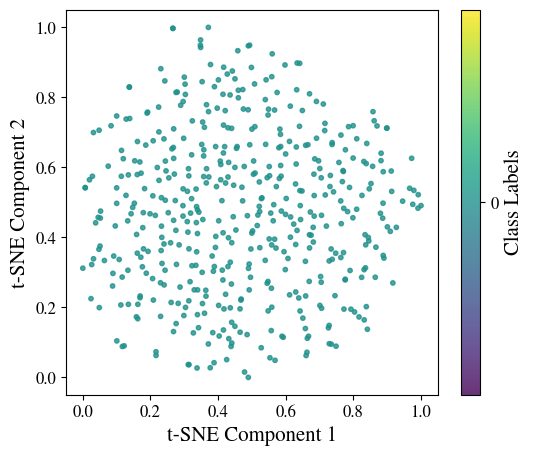

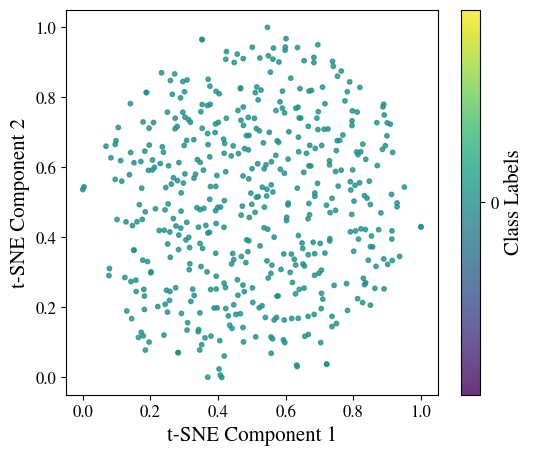

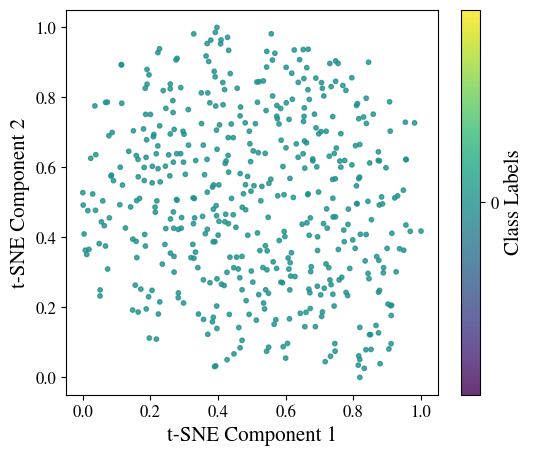

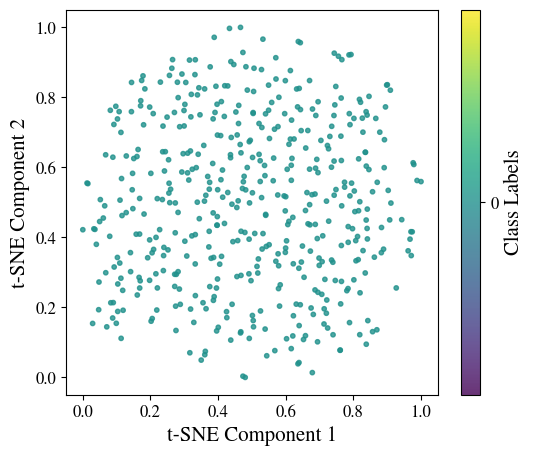

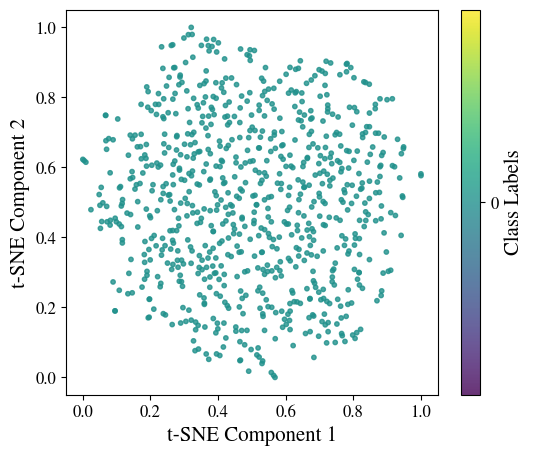

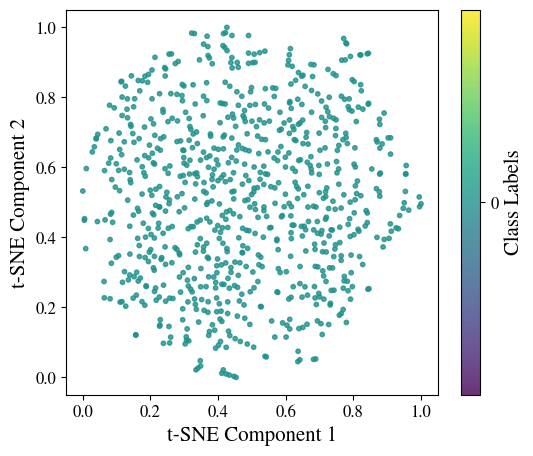

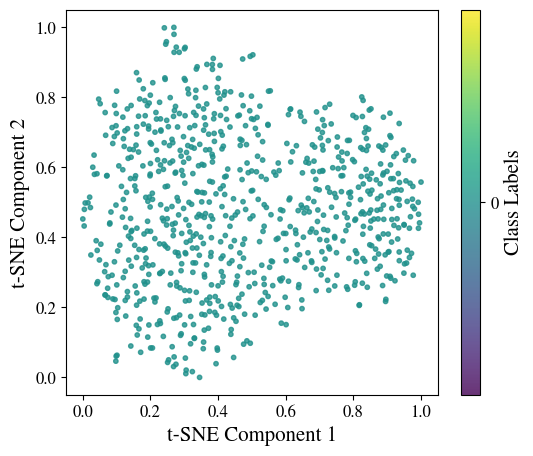

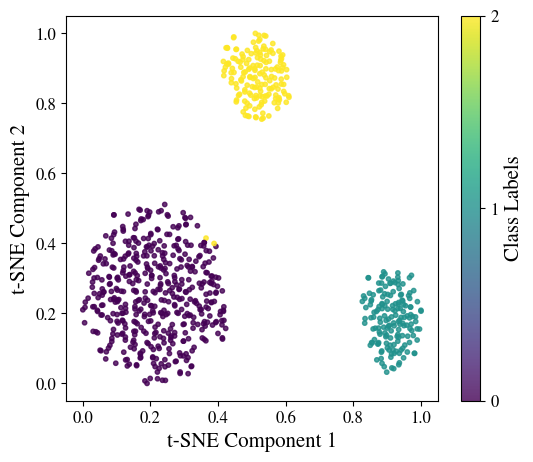

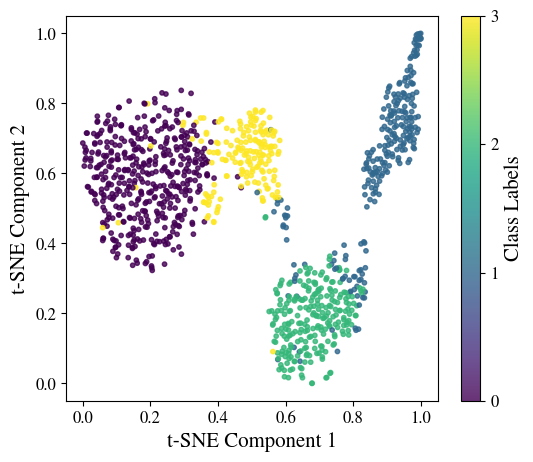

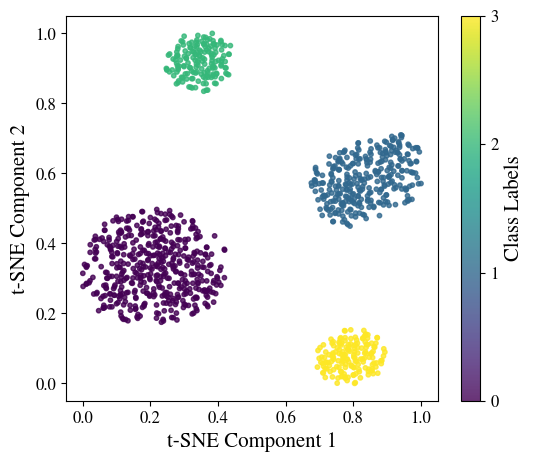

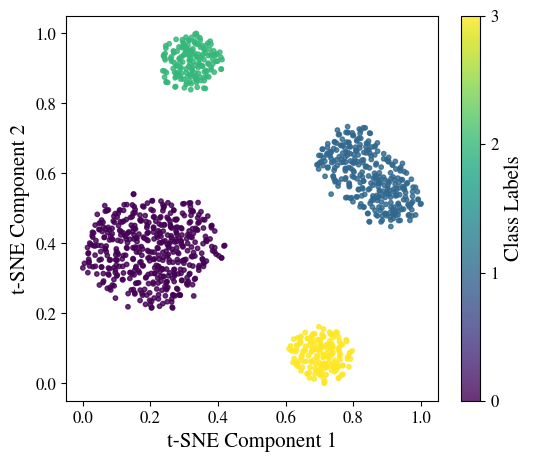

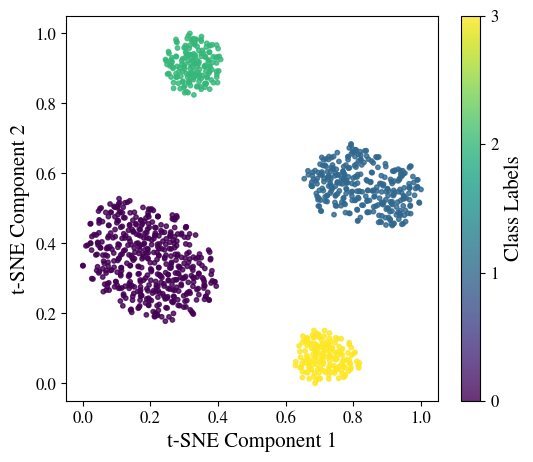

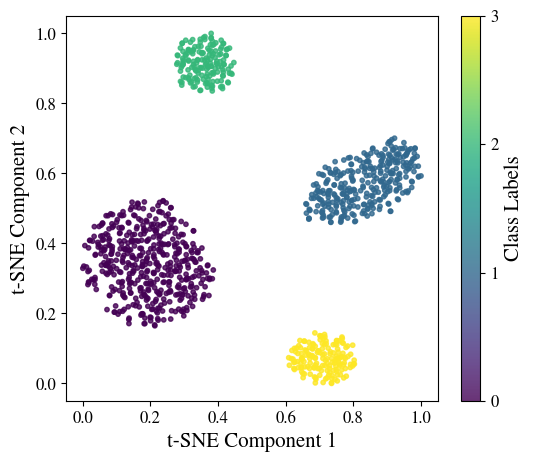

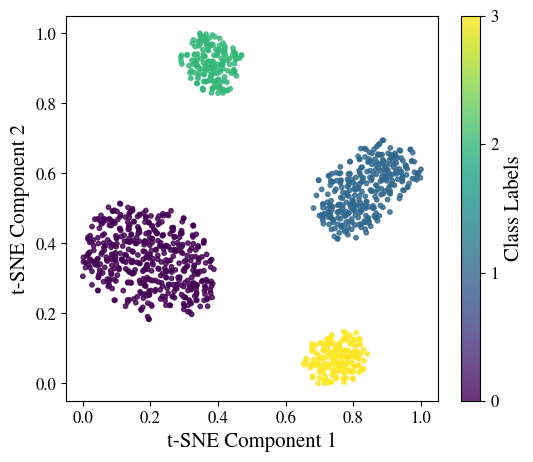

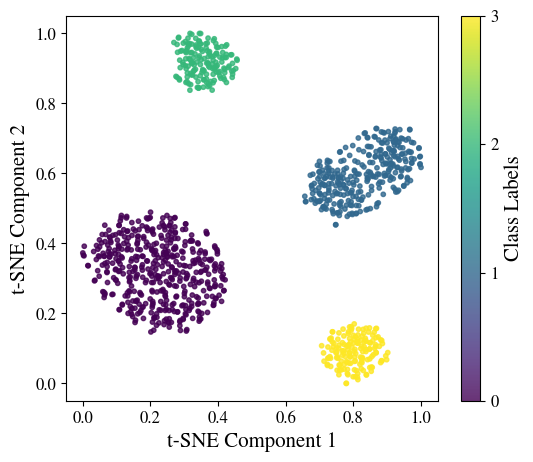

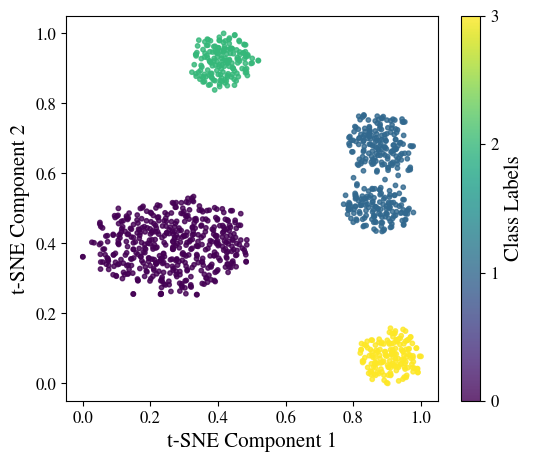

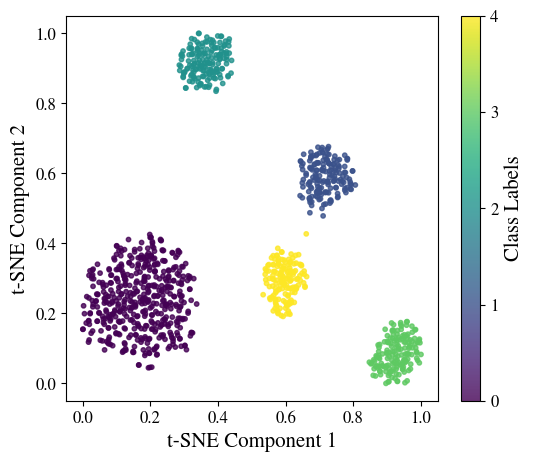

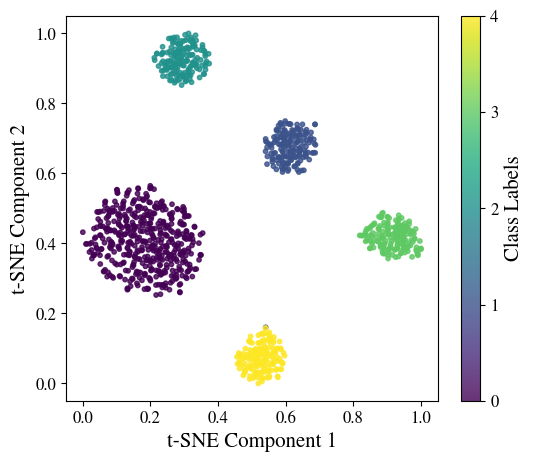

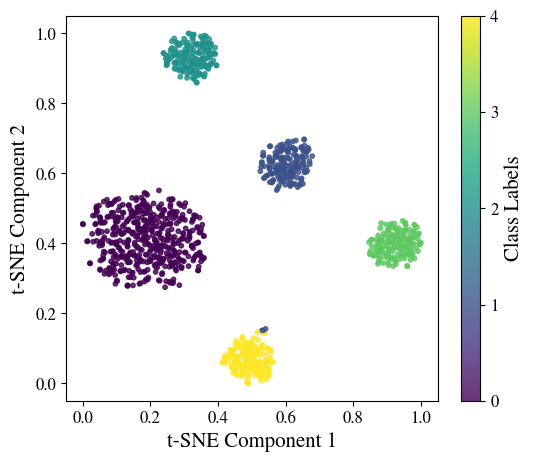

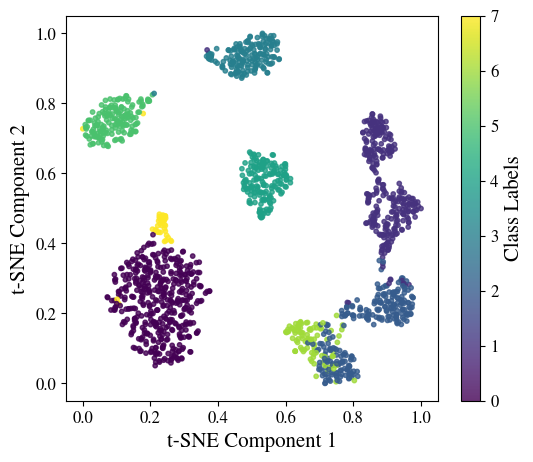

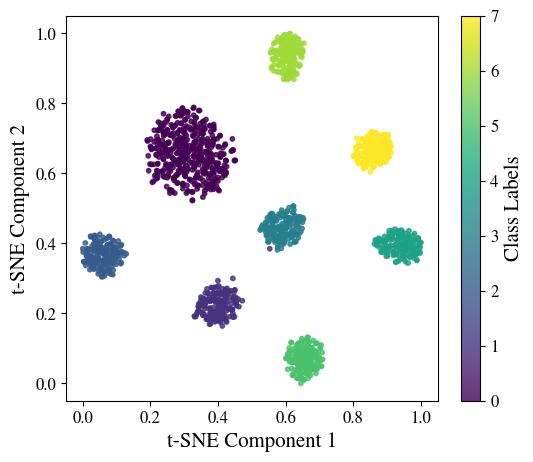

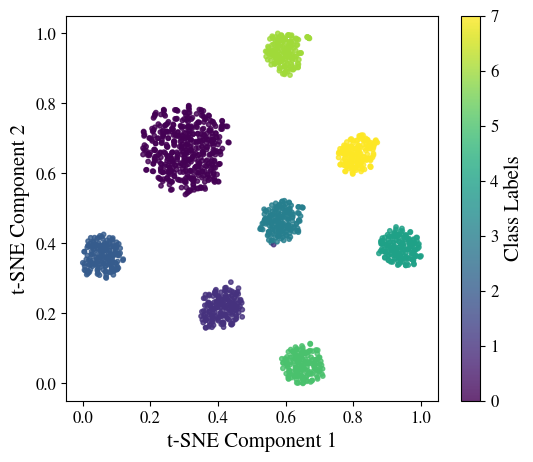

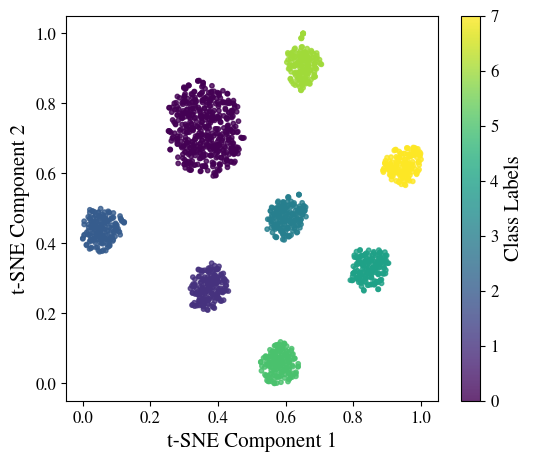

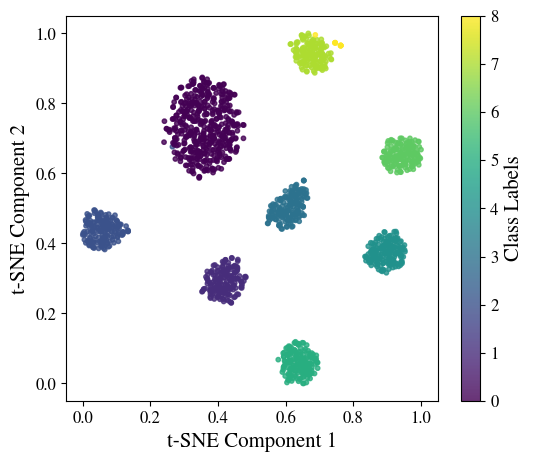

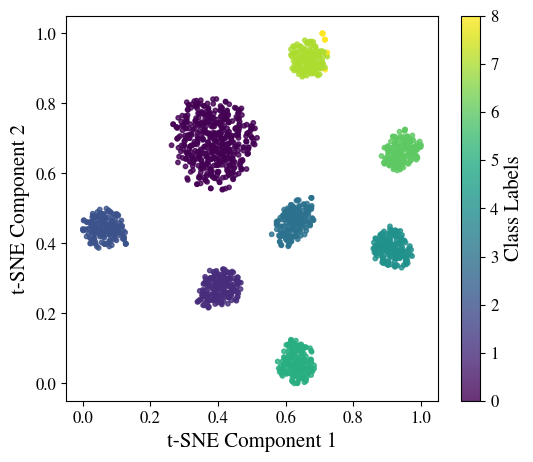

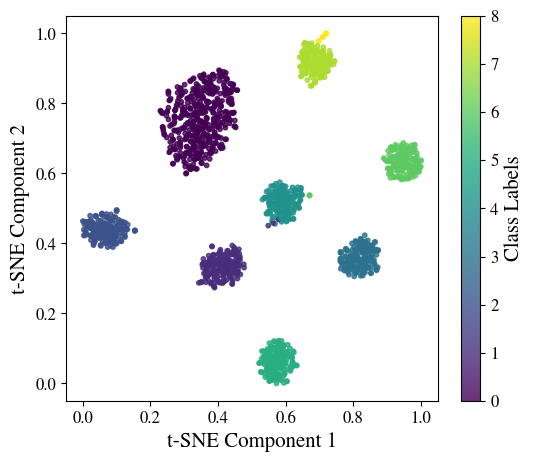

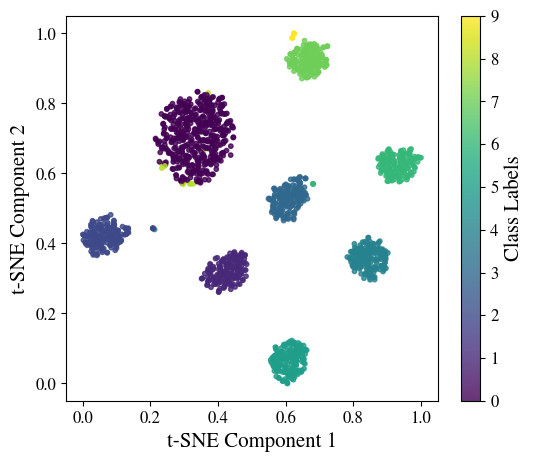

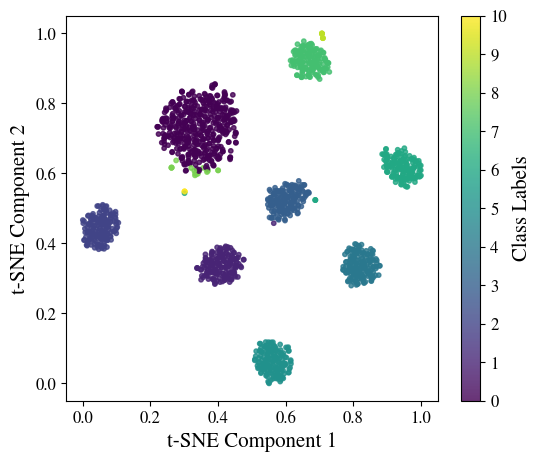

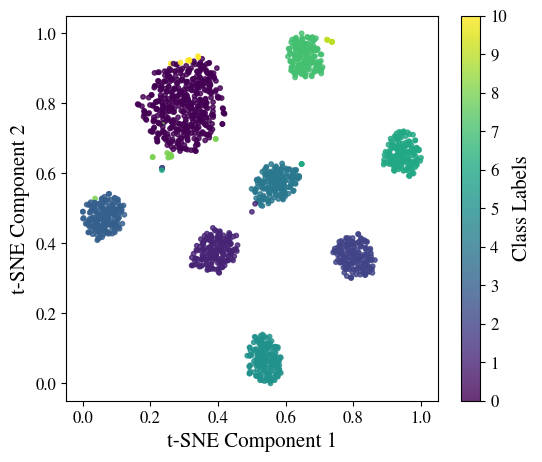

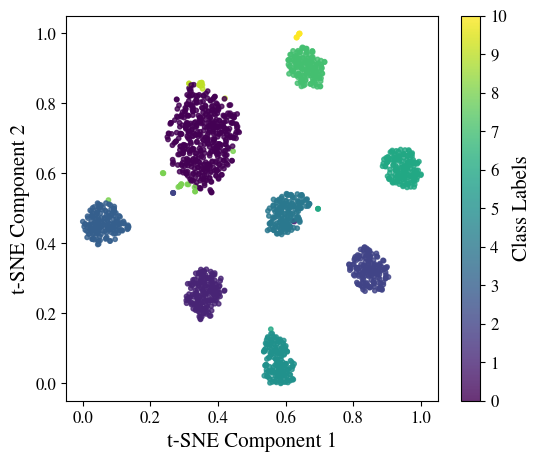

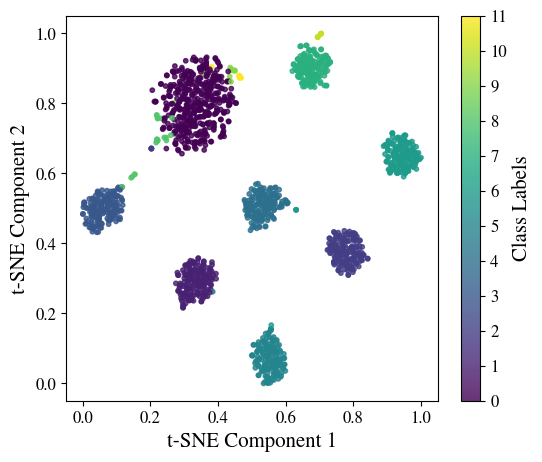

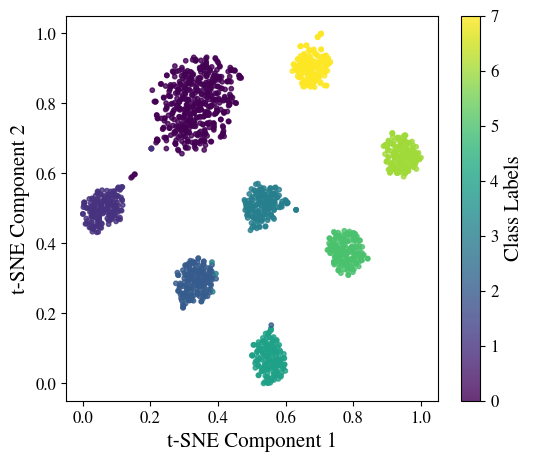

In [10]:
optimizer = optim.Adam(model.parameters(), lr = 5e-5, weight_decay = 0)

# total_epoch拟合DPGMM-训练vae 这一循环的epoch
total_epochs = 301
dpmm_init_epoch = 0

training_loss_epoch = []
recon_loss_epoch = []
kl_loss_epoch = []

val_loss_epoch = []
val_recon_loss_epoch = []
val_kl_loss_epoch = []

training_acc_epoch = []
val_acc_epoch = []
test_acc_epoch = []

dda_training_epoch = []
dda_val_epoch = []
dda_test_epoch = []


y_ground_truth = torch.tensor([])

add_epochs = [40,80,190]
plot_epochs = [i for i in np.arange(0, 301, 10)]

for epoch in range(total_epochs):
    # set train_loader, test_loader, and valid_loader conditioned on current epoch
    
    
    if epoch == add_epochs[0]:
        new_class1 =  1
        new_class2 = 2
        current_dataset = ConcatDataset([current_dataset, datasets[new_class1], datasets[new_class2]])
    
        train_size = int(0.8 * len(current_dataset))
        test_size = int(0.1 * len(current_dataset))
        valid_size = len(current_dataset) - train_size - test_size
        train_dataset, test_dataset, valid_dataset = random_split(current_dataset, [train_size, test_size, valid_size])

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    elif epoch == add_epochs[1]:
        new_class1 =  3
        new_class2 =  4
        current_dataset = ConcatDataset([current_dataset, datasets[new_class1], datasets[new_class2]])
    
        train_size = int(0.8 * len(current_dataset))
        test_size = int(0.1 * len(current_dataset))
        valid_size = len(current_dataset) - train_size - test_size
        train_dataset, test_dataset, valid_dataset = random_split(current_dataset, [train_size, test_size, valid_size])

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    elif epoch == add_epochs[2]:
        new_class1 =  5
        new_class2 =  6
        new_class3 =  7
        current_dataset = ConcatDataset([current_dataset, datasets[new_class1], datasets[new_class2], datasets[new_class3]])
    
        train_size = int(0.8 * len(current_dataset))
        test_size = int(0.1 * len(current_dataset))
        valid_size = len(current_dataset) - train_size - test_size
        train_dataset, test_dataset, valid_dataset = random_split(current_dataset, [train_size, test_size, valid_size])

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


    kl_weight = 1 # batch_size/len(train_loader.dataset)
    pbar = tqdm(train_loader, desc=f"current_epoch {epoch}/{total_epochs}")
        # training_loss_batch只记录training loss (total loss)
    training_loss_batch = []
    recon_loss_batch = []
    kl_loss_batch = []
        # train_loss_batch = [] 将一个epoch中所有mini_batch数据训练得出的loss存入一个列表, 包括 total loss， reconstruction loss， kl loss,‘z’,'components'
    train_loss_batch = []
    batch_idx = 0

    for batch_samples, batch_labels in pbar:

        if epoch == total_epochs - 1:
            y_ground_truth = torch.cat([y_ground_truth, batch_labels])

        batch_samples = batch_samples.to(device)

        train_loss = training_step(model, batch_samples, batch_labels, batch_idx, kl_weight)
        train_loss_batch.append(train_loss)
        

        # total loss in of a minibatch
        training_loss = train_loss['loss']
        training_loss_batch.append(train_loss['loss'].item())
        recon_loss_batch.append(train_loss['reconstruction_loss'].item())
        kl_loss_batch.append(kl_weight*train_loss['kld_loss'].item())


        optimizer.zero_grad()
        training_loss.backward()
        optimizer.step()

        batch_idx += 1


    #training_loss_epoch.append(np.mean(training_loss_batch)/batch_size)
    recon_loss_epoch.append(np.mean(recon_loss_batch))
    kl_loss_epoch.append(np.mean(kl_loss_batch))
    training_loss_epoch.append(recon_loss_epoch[epoch]+kl_loss_epoch[epoch])

    print(f"training_loss:{np.mean(training_loss_batch):.4f}", f"reconstruction_loss:{np.mean(recon_loss_batch):.4f}", f"kl_loss:{np.mean(kl_loss_batch):.4f}")

    if "comps" in train_loss_batch[0]:
        test_loss_batch = []
        batch_idx_test = 0
        
        for batch_samples, batch_labels in test_loader:
            batch_samples = batch_samples.to(device)
            test_loss = validation_step(model, batch_samples, batch_labels, batch_idx_test, kl_weight = 1)# batch_size/len(valid_loader.dataset))
            test_loss_batch.append(test_loss)
            batch_idx_test += 1

        test_acc, dda_test = test_epoch(epoch, total_epochs, test_loss_batch)
        test_acc_epoch.append(test_acc)
        dda_test_epoch.append(dda_test)
        

    if "comps" in train_loss_batch[0]:
        comps0, labels0, training_acc, dda_training = training_epoch_end(model, epoch, total_epochs, dpmm_init_epoch, train_loss_batch)
        training_acc_epoch.append(training_acc)
        dda_training_epoch.append(dda_training)

    else:
        training_epoch_end(model, epoch, total_epochs, dpmm_init_epoch, train_loss_batch)

    #if epoch > 0:
    with torch.no_grad():

        val_loss_batch = []
        valid_loss_batch = []
        val_recon_loss_batch = []
        val_kl_loss_batch = []
        batch_idx_val = 0

        for batch_samples, batch_labels in valid_loader:

            batch_samples = batch_samples.to(device)
            val_loss = validation_step(model, batch_samples, batch_labels, batch_idx_val, kl_weight = 1) #batch_size/len(valid_loader.dataset))
            val_loss_batch.append(val_loss)

            valid_loss_batch.append(val_loss['loss'].item())
            val_recon_loss_batch.append(val_loss['reconstruction_loss'].item())
            val_kl_loss_batch.append(kl_weight*val_loss['kld_loss'].item())

            batch_idx_val += 1
        
        #val_loss_epoch.append(np.mean(valid_loss_batch)/batch_size)
        val_recon_loss_epoch.append(np.mean(val_recon_loss_batch))
        val_kl_loss_epoch.append(np.mean(val_kl_loss_batch))
        val_loss_epoch.append(val_recon_loss_epoch[epoch]+val_kl_loss_epoch[epoch])

        if "comps" in train_loss_batch[0]:
            val_acc, dda_val = validation_epoch_end(epoch, total_epochs, val_loss_batch)
            val_acc_epoch.append(val_acc)
            dda_val_epoch.append(dda_val)
            print(f"valid_loss:{np.mean(valid_loss_batch):.4f}", f"val_reconstruction_loss:{np.mean(val_recon_loss_batch):.4f}", f"val_kl_loss:{np.mean(val_kl_loss_batch):.4f}")

    if epoch in plot_epochs:
        latent_variables = torch.tensor([])
        for i in range(len(train_loss_batch)): 
            latent_variables = torch.cat([latent_variables,train_loss_batch[i]['z'].cpu()],dim=0)
            
        print(latent_variables.shape)

        preds = model.current_result['hard_assign']
        # Create a random dataset with 6 dimensions and 2000 samples
        data = latent_variables.detach().cpu().numpy()
        # Create random labels for 6 classes
        labels = preds.squeeze()

        # Convert to tensors
        #data_tensor = torch.tensor(data, dtype=torch.float32)
        #labels_tensor = torch.tensor(labels, dtype=torch.int64)

        # Perform t-SNE
        tsne = TSNE(n_components=2, random_state=seed)
        tsne_results = tsne.fit_transform(data)
        tsne_max, tsne_min = tsne_results.max(0), tsne_results.min(0)
        tsne_results =  (tsne_results - tsne_min) / (tsne_max - tsne_min)

        matplotlib.rcParams['mathtext.fontset'] = 'stix'
        matplotlib.rcParams['font.family'] = 'STIXGeneral'
        size_ = 15
        plt.rc('figure', titlesize=size_)  # fontsize of the figure title
        plt.rc('axes', titlesize=size_)  # fontsize of the axes title
        plt.rc('axes', labelsize=size_)  # fontsize of the x and y labels
        plt.rc('xtick', labelsize=size_*0.8)  # fontsize of the tick labels
        plt.rc('ytick', labelsize=size_*0.8)  # fontsize of the tick labels
        plt.rc('legend', fontsize=size_*0.8)  # legend fontsize
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        colors += ['#db8233', '#8c564b', '#e377c2', "#8eab12"]
        # Plotting
        plt.figure(figsize=(6, 5))
        scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels.squeeze().int(), cmap='viridis', alpha=0.8, s=10)
        plt.colorbar(scatter, ticks=range(np.max(labels.detach().numpy())+1), label='Class Labels')
        #plt.title('t-SNE of the latent space with assigned clusters')
        plt.xlabel('t-SNE Component 1')
        plt.ylabel('t-SNE Component 2')
        plot_name = 'numerical_t-SNE_preds epoch ' + str(epoch) + '.png'
        plt.savefig(plot_name)
        #plt.show()

    if epoch == total_epochs - 1:
        latent_variables = torch.tensor([])
        for i in range(len(train_loss_batch)): 
            latent_variables = torch.cat([latent_variables,train_loss_batch[i]['z'].cpu()],dim=0)
            
        print(latent_variables.shape)
        data = latent_variables.detach().cpu().numpy()

        tsne = TSNE(n_components=2, random_state=seed)
        tsne_results = tsne.fit_transform(data)
        tsne_max, tsne_min = tsne_results.max(0), tsne_results.min(0)
        tsne_results =  (tsne_results - tsne_min) / (tsne_max - tsne_min)

        matplotlib.rcParams['mathtext.fontset'] = 'stix'
        matplotlib.rcParams['font.family'] = 'STIXGeneral'
        size_ = 15
        plt.rc('figure', titlesize=size_)  # fontsize of the figure title
        plt.rc('axes', titlesize=size_)  # fontsize of the axes title
        plt.rc('axes', labelsize=size_)  # fontsize of the x and y labels
        plt.rc('xtick', labelsize=size_*0.8)  # fontsize of the tick labels
        plt.rc('ytick', labelsize=size_*0.8)  # fontsize of the tick labels
        plt.rc('legend', fontsize=size_*0.8)  # legend fontsize
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        colors += ['#db8233', '#8c564b', '#e377c2', "#8eab12"]
        # Plotting
        plt.figure(figsize=(6, 5))
        scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_ground_truth.squeeze().int(), cmap='viridis', alpha=0.8, s=10)
        plt.colorbar(scatter, ticks=range(np.max(y_ground_truth.squeeze().int().detach().numpy())+1), label='Class Labels')
        #plt.title('t-SNE of the latent space with groundtruth labels')
        plt.xlabel('t-SNE Component 1')
        plt.ylabel('t-SNE Component 2')
        plot_name1 = 'numerical_t-SNE_ground_truth epoch ' + str(epoch) + '.png'
        plt.savefig(plot_name1)
        

        

Text(0, 0.5, 'Unsupervised Clustering Accuracy')

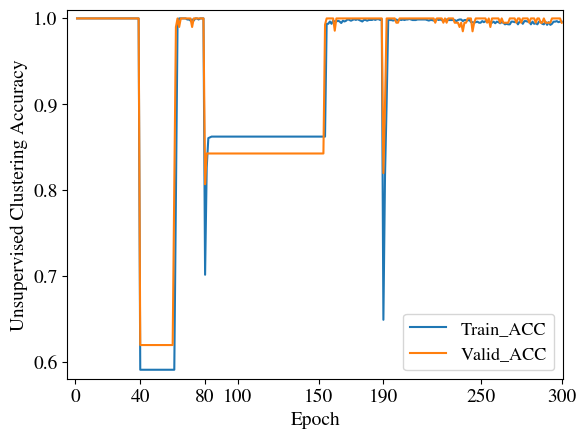

In [11]:
fig, ax = plt.subplots()
font= {'fontweight': 100, 'fontsize': 14}
x = [i for i in np.arange(1,len(training_acc_epoch)+1)]
ax.plot(x, training_acc_epoch[:])
ax.plot(x, val_acc_epoch[:])

ax.set_xticks([0, 40, 80, 100, 150, 190, 250, 300], labels = [0, 40, 80, 100, 150, 190, 250, 300], fontsize=14)
ax.set_yticks(np.arange(0.5,1.01,0.1), labels = [0.5,0.6,0.7,0.8,0.9,1.0], fontsize=14)
ax.set_xlim(-5,301)
ax.set_ylim(0.58,1.01)
#ax.plot(x, test_acc_epoch[:])
ax.legend(['Train_ACC', 'Valid_ACC'], fontsize=13)
ax.set_xlabel('Epoch', fontdict=font)
ax.set_ylabel('Unsupervised Clustering Accuracy',fontdict=font)
#plt.savefig('numerical_incremental_acc.png')

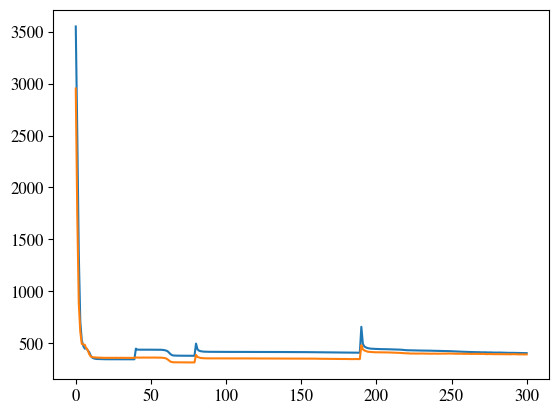

In [12]:
fig, ax = plt.subplots()
ax.plot(np.array(training_loss_epoch[:]))
ax.plot(np.array(val_loss_epoch[:]))

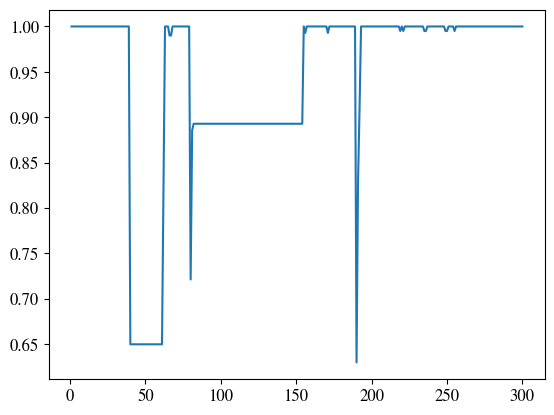

In [13]:
fig, ax = plt.subplots()
x = [i for i in np.arange(1,len(training_acc_epoch)+1)]
#ax.plot(training_acc_epoch[:])
#ax.plot(val_acc_epoch[:])
ax.plot(x, test_acc_epoch[:])

torch.Size([1600, 10])
(0.994375, 1, 8) 0.9875 0.9279453649900657 0.948865579692645


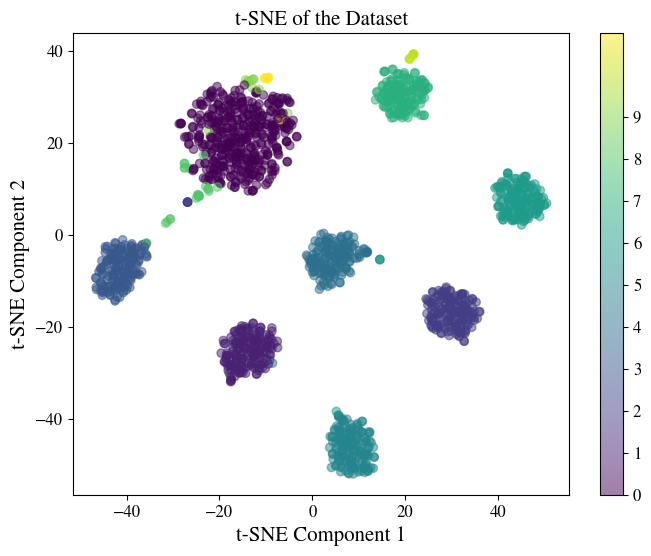

In [14]:
# Create a random dataset with 6 dimensions and 2000 samples
np.random.seed(12345)
latent_variables = torch.tensor([])
for i in range(len(train_loss_batch)): 
    latent_variables = torch.cat([latent_variables,train_loss_batch[i]['z'].cpu()],dim=0)
    
print(latent_variables.shape)

preds = model.current_result['hard_assign']

#  clustering accuracy of the training set
acc_training, assignment_training = unsupervised_clustering_accuracy(y_ground_truth.numpy().astype(int), preds.numpy())
ars_training = adjusted_rand_score(y_ground_truth.numpy().astype(int), preds.numpy())
nmi_training = normalized_mutual_info_score(y_ground_truth.numpy().astype(int), preds.numpy())

mapping = {}
try:
    for i,j in assignment_training:
        mapping[i] = j
    training_mapped_labels = [mapping[i] for i in preds.numpy()]
except:
    training_mapped_labels = y_ground_truth.numpy().astype(int)

dda_training = damage_detection_acc(y_ground_truth.numpy().astype(int), np.array(training_mapped_labels))
print(dda_training, acc_training, ars_training, nmi_training)
data = latent_variables.detach().cpu().numpy()
# Create random labels for 6 classes
labels = preds.squeeze()

# Convert to tensors
#data_tensor = torch.tensor(data, dtype=torch.float32)
#labels_tensor = torch.tensor(labels, dtype=torch.int64)

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(data)

# Plotting
plt.figure(figsize=(8, 6))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels.squeeze().int(), cmap='viridis', alpha=0.5)
plt.colorbar(scatter, ticks=range(10))
plt.title('t-SNE of the Dataset')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

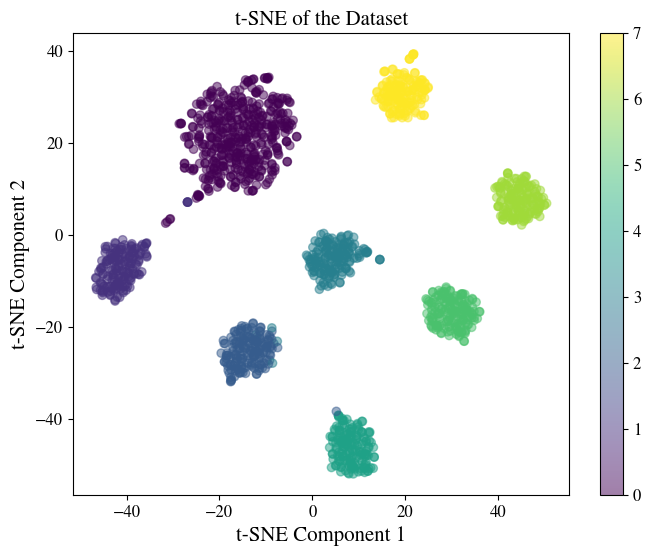

In [15]:
tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(data)

# Plotting
plt.figure(figsize=(8, 6))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_ground_truth.squeeze().int(), cmap='viridis', alpha=0.5)
plt.colorbar(scatter, ticks=range(10))
plt.title('t-SNE of the Dataset')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

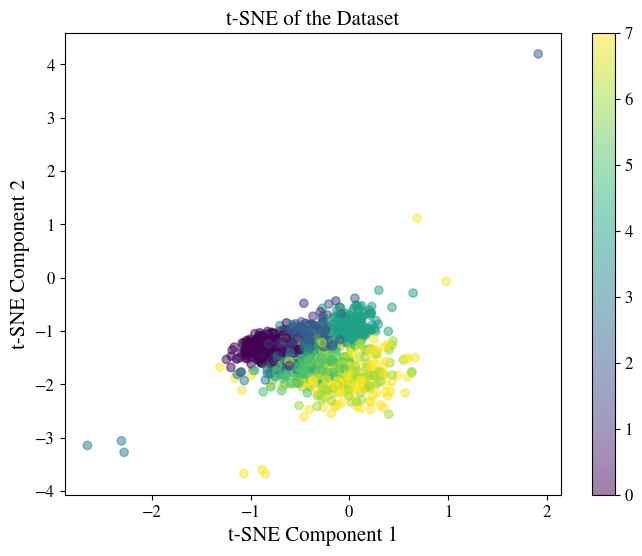

In [16]:
plt.figure(figsize=(8, 6))
data = latent_variables.detach().cpu().numpy()
labels = preds.squeeze()
scatter = plt.scatter(data[:, 0], data[:, 2], c=y_ground_truth.squeeze().int(), cmap='viridis', alpha=0.5)
plt.colorbar(scatter, ticks=range(10))
plt.title('t-SNE of the Dataset')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [17]:
y_valid = torch.tensor([])
for batch_samples, batch_labels in valid_loader:
    y_valid = torch.cat([y_valid, batch_labels], dim=0)

latent_val = torch.tensor([])
preds_val = torch.tensor([])
for i in range(len(val_loss_batch)): 
    latent_val = torch.cat([latent_val,val_loss_batch[i]['z'].cpu()],dim=0)
    preds_val = torch.cat([preds_val,val_loss_batch[i]['comps'].cpu()],dim=0)

acc_valid, assignment_valid = unsupervised_clustering_accuracy(y_valid.numpy().astype(int), preds_val.numpy())
ars_valid = adjusted_rand_score(y_valid.numpy().astype(int), preds_val.numpy())
nmi_valid = normalized_mutual_info_score(y_valid.numpy().astype(int), preds_val.numpy())

mapping = {}
try:
    for i,j in assignment_valid:
        mapping[i] = j
    valid_mapped_labels = [mapping[i] for i in preds_val.numpy()]
except:
    valid_mapped_labels = y_valid.numpy().astype(int)

dda_valid = damage_detection_acc(y_valid.numpy().astype(int), np.array(valid_mapped_labels))

print(dda_valid, acc_valid, ars_valid, nmi_valid)

(1.0, 0, 0) 0.995 0.9683042130871922 0.972468145937556


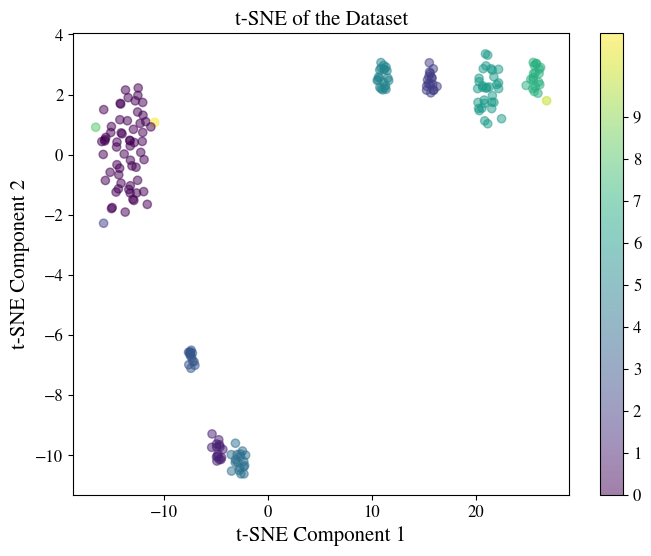

In [18]:
data = latent_val.detach().cpu().numpy()
# Create random labels for 6 classes
labels = preds_val.squeeze()

# Convert to tensors
#data_tensor = torch.tensor(data, dtype=torch.float32)
#labels_tensor = torch.tensor(labels, dtype=torch.int64)

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(data)

# Plotting
plt.figure(figsize=(8, 6))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels.squeeze().int(), cmap='viridis', alpha=0.5)
plt.colorbar(scatter, ticks=range(10))
plt.title('t-SNE of the Dataset')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [19]:
y_test = torch.tensor([])
for batch_samples, batch_labels in test_loader:
    y_test = torch.cat([y_test, batch_labels], dim=0)

latent_test = torch.tensor([])
preds_test = torch.tensor([])
for i in range(len(test_loss_batch)): 
    latent_test = torch.cat([latent_test,test_loss_batch[i]['z'].cpu()],dim=0)
    preds_test = torch.cat([preds_test,test_loss_batch[i]['comps'].cpu()],dim=0)


acc_test, assignment_test = unsupervised_clustering_accuracy(y_test.numpy().astype(int), preds_test.numpy())
ars_test = adjusted_rand_score(y_test.numpy().astype(int), preds_test.numpy())
nmi_test = normalized_mutual_info_score(y_test.numpy().astype(int), preds_test.numpy())


mapping = {}
try:
    for i,j in assignment_test:
        mapping[i] = j
    test_mapped_labels = [mapping[i] for i in preds_test.numpy()]
except:
    test_mapped_labels = y_test.numpy().astype(int)

dda_test = damage_detection_acc(y_test.numpy().astype(int), np.array(test_mapped_labels))

print(dda_test, acc_test, ars_test, nmi_test)

final_dda = (dda_training[0]*train_size + dda_valid[0]*valid_size + dda_test[0]*test_size) / len(current_dataset)
print(f'final dda: {final_dda}')
print(test_mapped_labels)
print(y_test.numpy().astype(int))

(1.0, 0, 0) 1.0 0.9533754548641602 0.9771014169485602
final dda: 0.9955
[1, 4, 7, 5, 7, 4, 4, 7, 0, 0, 5, 2, 5, 0, 7, 4, 4, 0, 1, 2, 3, 0, 1, 7, 6, 5, 0, 5, 6, 6, 0, 4, 0, 5, 1, 2, 4, 0, 0, 2, 1, 7, 4, 2, 0, 0, 4, 0, 1, 1, 5, 7, 0, 7, 0, 5, 4, 1, 5, 0, 7, 4, 6, 0, 0, 6, 0, 3, 0, 2, 4, 7, 7, 3, 0, 1, 0, 0, 7, 7, 0, 3, 3, 5, 4, 5, 3, 7, 1, 7, 2, 2, 0, 6, 0, 4, 6, 3, 4, 0, 7, 5, 4, 0, 6, 0, 5, 0, 0, 0, 0, 3, 5, 6, 5, 6, 0, 1, 4, 0, 3, 0, 0, 0, 2, 2, 0, 0, 1, 6, 3, 0, 5, 0, 0, 7, 0, 2, 0, 0, 2, 7, 0, 5, 2, 5, 6, 5, 0, 4, 6, 1, 6, 6, 3, 0, 3, 1, 0, 0, 7, 1, 0, 2, 2, 0, 0, 0, 3, 7, 2, 1, 0, 0, 5, 4, 5, 0, 0, 0, 6, 7, 7, 0, 0, 3, 0, 0, 5, 5, 4, 0, 0, 2, 0, 3, 1, 2, 0, 6]
[1 4 7 5 7 4 4 7 0 0 5 2 5 0 7 4 4 0 1 2 3 0 1 7 6 5 0 5 6 6 0 4 0 5 1 2 4
 0 0 2 1 7 4 2 0 0 4 0 1 1 5 7 0 7 0 5 4 1 5 0 7 4 6 0 0 6 0 3 0 2 4 7 7 3
 0 1 0 0 7 7 0 3 3 5 4 5 3 7 1 7 2 2 0 6 0 4 6 3 4 0 7 5 4 0 6 0 5 0 0 0 0
 3 5 6 5 6 0 1 4 0 3 0 0 0 2 2 0 0 1 6 3 0 5 0 0 7 0 2 0 0 2 7 0 5 2 5 6 5
 0 4 6 1 6 6 3 0 3 1 0 0 7 

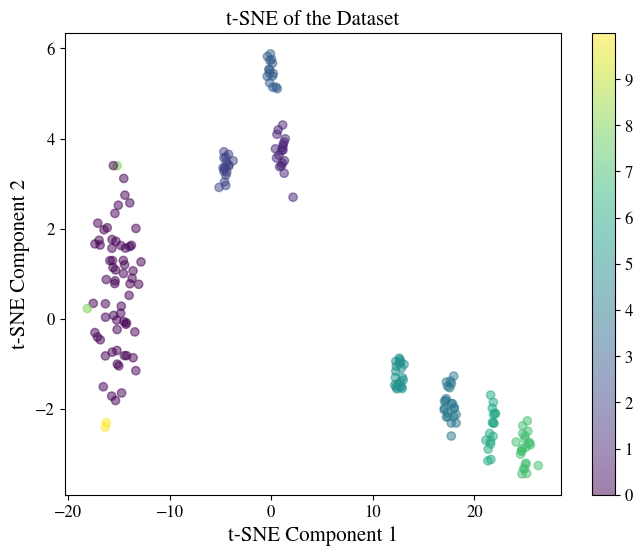

In [20]:
data = latent_test.detach().cpu().numpy()
# Create random labels for 6 classes
labels = preds_test.squeeze()

# Convert to tensors
#data_tensor = torch.tensor(data, dtype=torch.float32)
#labels_tensor = torch.tensor(labels, dtype=torch.int64)

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(data)

# Plotting
plt.figure(figsize=(8, 6))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels.squeeze().int(), cmap='viridis', alpha=0.5)
plt.colorbar(scatter, ticks=range(10))
plt.title('t-SNE of the Dataset')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

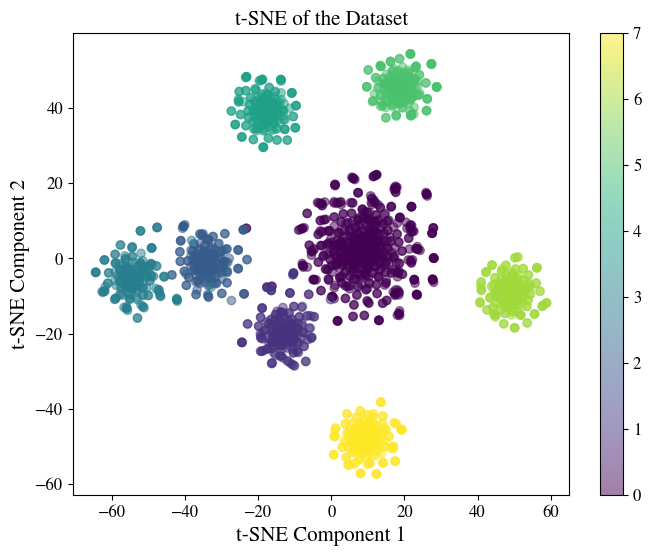

In [21]:
data = X.detach().cpu().numpy()
# Create random labels for 6 classes
labels = y.squeeze()

# Convert to tensors
#data_tensor = torch.tensor(data, dtype=torch.float32)
#labels_tensor = torch.tensor(labels, dtype=torch.int64)

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(data)

# Plotting
plt.figure(figsize=(8, 6))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels.squeeze().int(), cmap='viridis', alpha=0.5)
plt.colorbar(scatter, ticks=range(10))
plt.title('t-SNE of the Dataset')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()